## Baseline thesis experiment MVP
 
This notebook provides the proof of concept for the baseline experiment for the thesis. That is, this implements the **multi-task learning** experiment from Lazaridou, Potapenko and Tieleman (2020), using the MS COCO dataset. The goal of the notebook is to ensure the conceptal and technical correctness of the code; the efficiency and minor updates to the flow of the process are still subject to improvement. 

I would really appreciate feedback on code contained in cells indicated with **<-- please check me -->**; these are also the ones containing code which I have questions about. 

In [1]:
import torch
import torchvision
from torchvision import datasets as dset
from torchvision import transforms as transforms
import torch.nn as nn
import torchvision.models as models
from torch.utils.data import Dataset, DataLoader
import os
import json
from random import shuffle
from pycocotools.coco import COCO
from PIL import Image
import matplotlib.pyplot as plt
import pickle
from collections import Counter
from torchtext.data import get_tokenizer
import numpy as np
import math
import time
import sys
import re
import pandas as pd
import h5py
from tqdm import tqdm

In [2]:
# set seed
torch.manual_seed(1234)

### Utilities

First, some utility functions are implemented. The Vocabulary class instantiates or loads the vocabulary (full vocabulary constructed from the entire dataset for now). The Dataset class loads image-caption pairs. The `get_loader` provides a DataLoader for training. 

In [3]:
# utils: vocab used by the agents (shared)

class Vocabulary(object):

    def __init__(self,
        vocab_threshold,
        vocab_file='./vocab.pkl',
        start_word="START",
        end_word="END",
        unk_word="UNK",         
        annotations_file="captions_val2014.json",
        pad_word="PAD",
        vocab_from_file=False):
        """
        Initialize the vocabulary.
        Args:
        -----
          vocab_threshold: Minimum word count threshold.
          vocab_file: File containing the vocabulary.
          start_word: Special word denoting sentence start.
          end_word: Special word denoting sentence end.
          unk_word: Special word denoting unknown words.
          annotations_file: Path for train annotation file.
          pad_word: Pad token.
          vocab_from_file: If False, create vocab from scratch & override any existing vocab_file
                           If True, load vocab from from existing vocab_file, if it exists
        """
        self.vocab_threshold = vocab_threshold
        self.vocab_file = vocab_file
        self.start_word = start_word
        self.end_word = end_word
        self.unk_word = unk_word
        self.pad_word = pad_word
        self.annotations_file = annotations_file
        self.vocab_from_file = vocab_from_file
        # create / load the vocab
        self.get_vocab()

    def get_vocab(self):
        """
        Load the vocabulary from file OR build the vocabulary from scratch.
        """
        if os.path.exists(self.vocab_file) & self.vocab_from_file:
            with open(self.vocab_file, 'rb') as f:
                vocab = pickle.load(f)
                self.word2idx = vocab.word2idx
                self.idx2word = vocab.idx2word
            print('Vocabulary successfully loaded from vocab.pkl file!')
        else:
            self.build_vocab()
            with open(self.vocab_file, 'wb') as f:
                pickle.dump(self, f)
        
    def build_vocab(self):
        """
        Populate the dictionaries for converting tokens to integers (and vice-versa).
        """
        self.init_vocab()
        # add special tokens andd all tokens from all captions
        self.add_word(self.start_word)
        self.add_word(self.end_word)
        self.add_word(self.unk_word)
        self.add_word(self.pad_word)
        self.add_captions()

    def init_vocab(self):
        """
        Initialize the dictionaries for converting tokens to integers (and vice-versa).
        """
        self.word2idx = {} 
        self.idx2word = {} 
        self.idx = 0

    def add_word(self, word):
        """
        Add a token to the vocabulary.
        Args:
        ----
            word: str
                Token to be added.
        """
        if not word in self.word2idx:
            self.word2idx[word] = self.idx
            self.idx2word[self.idx] = word
            self.idx += 1

    def add_captions(self):
        """
        Loop over training captions and add all tokens to the vocabulary that meet or exceed the threshold.
        """
#         coco = COCO(self.annotations_file)
#         with open("../../../data/3dshapes_captions_short.json", "r") as fp:
#                 self.labels = json.load(fp)
        with open("../../../data/3dshapes_captions_fixed.json", "r") as fp:
                labels = json.load(fp)
        with open("../../../data/3dshapes_captions_short.json", "r") as fp:
                labels_short = json.load(fp)        
            
        
        ids = [i for lst in labels.keys() for i in labels[lst]]
        ids_short = [i for lst in labels_short.keys() for i in labels_short[lst]]
        ids.extend(ids_short)
        
        
#         ids = [i for lst in self.labels.keys() for i in self.labels[lst]]
        
        counter = Counter()
#         ids = coco.anns.keys()
        for i, id in enumerate(ids):
#             caption = str(coco.anns[id]['caption'])
            caption = str(id)
            caption = caption.lower().strip()
            caption = re.sub(r"[^a-zA-Z.,!?]+", r" ", caption)
            tokenizer = get_tokenizer("basic_english")
            tokens = tokenizer(caption) 
            counter.update(tokens)

            if i % 100000 == 0:
                print("[%d/%d] Tokenizing captions..." % (i, len(ids)))

        words = [word for word, cnt in counter.items() if cnt >= self.vocab_threshold]

        for i, word in enumerate(words):
            self.add_word(word)

    def __call__(self, word):
        """
        Return index of given word.
        Args:
        ----
            word: str
        Returns:
            int: index of word
        """
        if not word in self.word2idx:
            return self.word2idx[self.unk_word]
        return self.word2idx[word]

    def __len__(self):
        """
        Returns number of unique tokens in vocabulary. 
        """
        return len(self.word2idx)

In [4]:
ID_check = torch.load("../train_logs/pretrain_img_IDs_2imgs_512dim.pt").tolist()
len(ID_check)
max(ID_check)

829717

In [5]:
# build a dataset generator
# padding will be made more consistent across pre-training and reference game training

class COCOCaptionsDataset(Dataset):
    """
    Custom class for preprocessing datapoints and sampling a random caption per image.
    For training, 70.000 images are sampled.
    
    Args:
    ----
        file: str
            Path to annotations json file.
        download_dir: str
            Path to root directory containing images and annotations.
        img_transform: transformations.Compose
            Transformations to be applied to the loaded image before it is embedded.
        batch_size: int
            Batch size.
        mode: str
            Train, test or validation.
        vocab_threshold: int
            Minimal token frequency to be considered in the vocab.
        vocb_file: str
            Path to vocab file.
        start_toke, end_token, unk_token, pad_token: str
            Special tokens.
        vocab_from_file: bool
            Load existing vocab from file?
        max_sequence_length: int
            Max length to which captions will be truncated.
        
    """
    def __init__(self, file, download_dir, img_transform, batch_size, mode, 
                 vocab_threshold, vocab_file, start_token, end_token, unk_token, pad_token, 
                vocab_from_file, max_sequence_length=0):
        """
        Initialize a dataset instance loading image-caption pairs from the MS COCO Captions dataset.
        """
        self.transform = img_transform
        self.mode = mode
        self.batch_size = batch_size
        # instantiating the vocab object 
        self.vocab = Vocabulary(vocab_threshold, vocab_file, 
                                start_token, end_token, unk_token, file, pad_token, vocab_from_file) 
        self.max_sequence_length = max_sequence_length
        self.pad_token = pad_token
        
        # some distinctions below for Train and test mode (root dir and whether there are captions)
        if mode == "train":
            self.image_dir = os.path.join(download_dir, "train2014")
            self.coco = COCO(file) 
#             _ids = list(self.coco.anns.keys())
#             shuffle(_ids)
            # take 70.000 images from the dataset
    
            self.ids = torch.load("val_split_annIDs_singular_from_COCO_train_tensor.pt").tolist() # #_ids[:70000] # ("../pretrain_img_IDs_2imgs_512dim.pt")# torch.load("../pretrain_img_IDs_2imgs_512dim.pt").tolist() #
            
    ########## FOR EVAL LOSS COMPUTATIONS
#             
            # retrieve a subset of images for pretraining
#             self.ids = torch.load("../train_logs/pretrain_img_IDs_2imgs_512dim.pt").tolist()[:1000] #_ann_ids_flat
        
    ###########        
            
            print('Obtaining caption lengths...')
            tokenizer = get_tokenizer("basic_english") 
            all_tokens = [tokenizer(str(self.coco.anns[self.ids[index]]['caption']).lower()) for index in np.arange(len(self.ids))]
            self.caption_lengths = [len(token) for token in all_tokens]
            # get maximum caption length for padding
            self.max_caption_length = max(self.caption_lengths)
            
            # print pretraining IDs for later separation from functional training
#             with open("pretrain_img_IDs.txt", 'w') as f:
#                 f.write(",".join([str(i) for i in self.ids]))
                
        elif mode == "val":
            self.image_dir = os.path.join(download_dir, "val2014")
            self.coco = COCO(file) 
            self.ids = torch.load("../pretrain_img_IDs_2imgs_512dim.pt").tolist() #list(self.coco.anns.keys())
            print('Obtaining caption lengths...')
            tokenizer = get_tokenizer("basic_english")
            all_tokens = [tokenizer(str(self.coco.anns[self.ids[index]]['caption']).lower()) for index in np.arange(len(self.ids))] # tqdm(np.arange(len(self.ids)))
            self.caption_lengths = [len(token) for token in all_tokens]
            
        else:
            self.image_dir = os.path.join(download_dir, "val2014")
            # no annotations here 
            test_info = json.loads(open(file).read())
            self.paths = [item['file_name'] for item in test_info['images']]
    
    def __len__(self):
        """
        Return number of available data points.
        """
        if self.mode != "test":
            return len(self.ids)
        else:
            return len(self.paths)
    
    def __getitem__(self, idx):
        """
        Return an image-caption tuple. A random caption per images is chosen since the dataset maps captions onto images.
        
        Arguments:
        -------
        idx: int
            Index of the item to be returned.
        Returns:
        -----
        image: torch.tensor((3,224,224))
        caption: torch.tensor((len_caption))
        """
        
        # obtain image and caption if in training mode
        if self.mode != 'test':
            # get target and distractor indices
            target_idx = idx[0]
            distractor_idx = idx[1]
            
            ann_id = self.ids[target_idx]
            target_caption = self.coco.anns[ann_id]['caption']
            img_id = self.coco.anns[ann_id]['image_id']
            target_path = self.coco.loadImgs(img_id)[0]['file_name']

            # get distarctor
            dist_id = self.ids[distractor_idx]
            dist_img_id = self.coco.anns[dist_id]['image_id']
            distractor_path = self.coco.loadImgs(dist_img_id)[0]['file_name']

            # Convert image to tensor and pre-process using transform
            target_image = Image.open(os.path.join(self.image_dir, target_path)).convert('RGB')
            target_image = self.transform(target_image)

            distractor_image = Image.open(os.path.join(self.image_dir, distractor_path)).convert('RGB')
            distractor_image = self.transform(distractor_image)

            tokenizer = get_tokenizer("basic_english")
            tokens = tokenizer(str(target_caption).lower())
            # Convert caption to tensor of word ids, append start and end tokens.
            target_caption = []
            target_caption.append(self.vocab(self.vocab.start_word))

            # check if the sequence needs to be padded or truncated
            if self.max_sequence_length != 0:
                tokens = tokens[:self.max_sequence_length]

            target_caption.extend([self.vocab(token) for token in tokens])
            target_caption.append(self.vocab(self.vocab.end_word))
            target_caption = torch.Tensor(target_caption).long()
            return target_image, distractor_image, target_caption

        # obtain image if in test mode
        else:
            path = self.paths[idx[0]]

            # Convert image to tensor and pre-process using transform
            PIL_image = Image.open(os.path.join(self.image_dir, path)).convert('RGB')
            orig_image = np.array(PIL_image)
            image = self.transform(PIL_image)
            # return original image and pre-processed image tensor
            return orig_image, image
        
#     def get_train_indices(self):
#         """
#         Return a list of indices at which the captions have the same length which was sampled at random 
#         for the given batch. To be used for pretraining the speaker (base image-captioning model).
        
#         Returns:
#         -----
#             indices: list
#                 List of indices of caption-image pairs to be used in the batch.
#         """
#         sel_length = np.random.choice(self.caption_lengths)
#         all_indices = np.where([self.caption_lengths[i] == sel_length for i in np.arange(len(self.caption_lengths))])[0]
#         indices = list(np.random.choice(all_indices, size=self.batch_size))
        
#         return indices
    
    def get_func_train_indices(self):
        """
        Simple POC function returning two lists on indices for the functional training. 
        Returns a list of inidces for targets and a list f indices for distractors. 
        Captions are of same lengths for targets and distractors (will be optimized).
        
        Returns:
        -------
            list: (int, int)
                List of tuples of target and distractor indices, each for a single reference game iteration.
        """
        
        sel_length_t = np.random.choice(self.caption_lengths)

        all_indices_t = np.where([self.caption_lengths[i] == sel_length_t for i in np.arange(len(self.caption_lengths))])[0]

        indices_t = list(np.random.choice(all_indices_t, size=self.batch_size))
        possible_inds_dist = [x for x in np.arange(len(self.caption_lengths)) if x not in indices_t]
        indices_d = list(np.random.choice(possible_inds_dist, size=self.batch_size))
        
        return list(zip(indices_t, indices_d))

In [6]:
class threeDshapes_Dataset(Dataset):
    """
    Dataset class for loading the dataset of images and captions from the 3dshapes dataset.
    """
    def __init__(
        self,
        file, 
        download_dir, 
        img_transform, 
        text_transform, 
        batch_size, 
        mode, 
        vocab_threshold, 
        vocab_file, 
        start_token, 
        end_token,
        unk_token,
        pad_token, 
        vocab_from_file, 
        embedded_imgs,
        vocab_from_pretrained=False,
        max_sequence_length=0,
        categorize_imgs=False,
        ):

        self.transform = img_transform
        self.mode = mode # train or test or val
        self.batch_size = batch_size
        self.vocab = Vocabulary(vocab_threshold, vocab_file, 
                                start_token, end_token, unk_token, 
                                file, pad_token, vocab_from_file) 
        self.max_sequence_length = max_sequence_length
        self.pad_token=pad_token
        self.embedded_imgs=embedded_imgs
        self.tokenizer = get_tokenizer("basic_english")

        if mode == "train":
            self.image_dir = os.path.join(download_dir, "3dshapes_np.npy") # download_dir needs to be data/train/ then 
            self.images = np.load(self.image_dir) # ["images"] # os.path.join(download_dir, file)
            with open("../../../data/3dshapes_captions_fixed.json", "r") as fp:
                self.labels = json.load(fp)
            with open("../../../data/3dshapes_captions_short.json", "r") as fp:
                self.labels_short = json.load(fp)
            
#             imgIDs4train = torch.load("val_imgIDs_4PPL.pt")#list(np.random.choice(torch.load("../train_logs/val_img_IDs_unique_3dshapes.pt"), 1000)) # torch.load("../ref_game_imgIDs_unique_wShortCaps_3dshapes.pt")#np.random.choice(list(self.labels.keys()), 30000) # train split # np.random.choice(torch.load("../val_img_IDs_unique_3dshapes.pt"), 200) 
            
            imgIDs4train = torch.load("../train_logs/pretrain_img_IDs_unique_wShortCaps_3dshapes_exh.pt")[:1000]
            _ids = [(self.labels[i], i) for i in imgIDs4train]
            #             _ids = [(self.labels[i], i) for i in imgIDs4train] # list of tuples of shape (annID_lst, imgID)
#             _anns_flat = [i for lst in _ids for i in np.random.choice(lst[0], 5)] # only select 5 random captions among 40 possible 
#             self._img_ids_flat = torch.load( "../pretrain_img_IDs_flat_3dshapes_short.pt")#[i[1] for i in _ids for x in i[0][:5]]
#             _unique_IDs = list(set(self._img_ids_flat))
#             _anns_flat = []
#             for i in _unique_IDs:
#                 short_caps = np.random.choice(self.labels_short[i], 3)
#                 long_caps = np.random.choice(self.labels[i], 2)
#                 _anns_flat.extend(short_caps)
#                 _anns_flat.extend(long_caps)
                
            
#             self.ids = torch.load("../pretrain_anns_flat_3dshapes_short.pt")#_anns_flat
            self._img_ids_flat = [i[1] for i in _ids for x in i[0][:1]]
            # _unique_IDs = list(set(self._img_ids_flat))
            _anns_flat = []
            for i in imgIDs4train:
                short_caps = np.random.choice(self.labels_short[i], 3)
                long_caps = np.random.choice(self.labels[i], 1)
#                 _anns_flat.extend(short_caps)
                _anns_flat.extend(long_caps)
            self.ids = _anns_flat
            
            print("IDS ", len(self.ids), self.ids[:10])
            print("img IDs ", len(self._img_ids_flat), self._img_ids_flat[:10])

            print('Obtaining caption lengths...')
            tokenizer = get_tokenizer("basic_english") # nltk.tokenize.word_tokenize(str(self.coco.anns[self.ids[index]]['caption']).lower())
            all_tokens = [tokenizer(str(self.ids[index]).replace("-", " ")) for index in tqdm(np.arange(len(self.ids)))] 
            self.caption_lengths = [len(token) for token in all_tokens]
            
            # print pretraining IDs for later separation from functional training
            # save used indices to torch file
            print("Type check before saving: ", type(imgIDs4train[0]))
            torch.save(imgIDs4train, "val_imgIDs_4PPL.pt")
#             torch.save(self._img_ids_flat, "pretrain_img_IDs_flat_3dshapes.pt")
#             torch.save(self.ids, "pretrain_anns_flat_3dshapes.pt")
            
        if mode == "val":
            pass

    def __len__(self):
        return len(self.ids)
        # for extracting resnet features:
#         return len(self.images)

    def __getitem__(self, idx):
        if self.mode != "test":
            target_idx = idx[0]
            distractor_idx = idx[1]
            # just accessing images directly for resnet feature extraction
            target_img = self.images[int(self._img_ids_flat[target_idx])]
            target_lbl = self.ids[target_idx]
            
            dist_img = self.images[int(self._img_ids_flat[distractor_idx])] # self.images[int(distractor_idx)] #
            dist_lbl = self.ids[distractor_idx]

            target_img = np.asarray(target_img).astype('uint8')

            dist_img = np.asarray(dist_img).astype('uint8')

            target_img = self.transform(target_img)
            dist_img = self.transform(dist_img)

            target_features = self.embedded_imgs[int(self._img_ids_flat[target_idx])].squeeze(0)
            distractor_features = self.embedded_imgs[int(self._img_ids_flat[distractor_idx])].squeeze(0)

            tokens = self.tokenizer(str(target_lbl).lower().replace("-", " "))
            tokens_dist = self.tokenizer(str(dist_lbl).lower().replace("-", " "))
            # Convert caption to tensor of word ids, append start and end tokens.
            target_caption = []
            distractor_caption = []
            target_caption.append(self.vocab(self.vocab.start_word))
            distractor_caption.append(self.vocab(self.vocab.start_word))

            # check if the sequence needs to be padded or truncated
            if self.max_sequence_length != 0:
                tokens = tokens[:self.max_sequence_length]
                tokens_dist = tokens_dist[:self.max_sequence_length]

            target_caption.extend([self.vocab(token) for token in tokens])
            target_caption.append(self.vocab(self.vocab.end_word))
            target_caption = torch.Tensor(target_caption).long()

            distractor_caption.extend([self.vocab(token) for token in tokens_dist])
            distractor_caption.append(self.vocab(self.vocab.end_word))
            distractor_caption = torch.Tensor(distractor_caption).long()

            return target_img, dist_img, target_features, distractor_features, target_caption

    def get_func_train_indices(self):
        """
        Simple POC function returning two lists on indices for the functional training. 
        Returns a list of inidces for targets and a list f indices for distractors. 
        Captions are of same lengths for targets and distractors (will be optimized).
        
        Returns:
        -------
            list: (int, int)
                List of tuples of target and distractor indices, each for a single reference game iteration.
        """
        
        sel_length_t = np.random.choice(self.caption_lengths)

        all_indices_t = np.where([self.caption_lengths[i] == sel_length_t for i in np.arange(len(self.caption_lengths))])[0]

        indices_t = list(np.random.choice(all_indices_t, size=self.batch_size))
        # retrieve image ids of sampled ids to make sure we don't get target distractor pairs
        # consisiting of same images
        imgIDs_t = [self._img_ids_flat[i] for i in indices_t]
        possible_inds_dist = [x for x in np.arange(len(self.caption_lengths)) if x not in indices_t and self._img_ids_flat[x] not in imgIDs_t]
        indices_d = list(np.random.choice(possible_inds_dist, size=self.batch_size))
        
        return list(zip(indices_t, indices_d))


In [32]:
# torch.load("../pretrain_val_img_IDs_2imgs.pt").tolist()[:10] # 649113
coco_train = COCO("../../../data/train/annotations/captions_train2014.json")
list(coco_train.anns.keys())[:10]

loading annotations into memory...
Done (t=0.61s)
creating index...
index created!


[48, 67, 126, 148, 173, 188, 219, 255, 272, 288]

In [ ]:
coco_train_img = COCO("../../../data/train/annotations/instances_train2014.json")


In [34]:
# coco_train.loadAnns(272)
# coco_train.loadImgs(134754)
# coco_train.getAnnIds(134754)
# # [48, 126, 219, 255, 3555]
# coco_train.loadAnns([272, 425, 1022, 2972, 5759])
coco_train.imgToAnns[134754]

[{'image_id': 134754,
  'id': 272,
  'caption': 'The two people are walking down the beach.'},
 {'image_id': 134754,
  'id': 425,
  'caption': 'Two people carrying surf boards on a beach.'},
 {'image_id': 134754,
  'id': 1022,
  'caption': 'Two teenagers at a white sanded beach with surfboards.'},
 {'image_id': 134754,
  'id': 2972,
  'caption': 'A couple at the beach walking with their surf boards.'},
 {'image_id': 134754,
  'id': 5759,
  'caption': 'A guy and a girl are walking on the beach holding surfboards.'}]

In [7]:
# utility wrapper returning a DataLoader for training 
def get_loader(transform,
               mode='val',
               batch_size=1,
               vocab_threshold=None,
               vocab_file='./vocab.pkl',
               start_word="START",
               end_word="END",
               unk_word="UNK",
               pad_word="PAD",
               vocab_from_file=True,
               num_workers=0,
               download_dir="../../../data/val/",
              ):
    """
    Returns the data loader.
    Args:
    ----
      transform: transforms.Compose
          Image transform.
      mode: str 
          One of 'train', 'val' or 'test'.
      batch_size: int
          Batch size (if in testing mode, must have batch_size=1).
      vocab_threshold: int
          Minimum word count threshold.
      vocab_file: str
          File containing the vocabulary. 
      start_word, end_word, unk_word, pad_word: str
          Special tokens.
      vocab_from_file: bool
          If False, create vocab from scratch & override any existing vocab_file.
          If True, load vocab from from existing vocab_file, if it exists.
      num_workers: int
          Number of subprocesses to use for data loading 
      
    Returns:
    ------
        data_loader: torch.DataLoader
    """
    
    assert mode in ['train', 'test', 'val'], "mode must be one of 'train' or 'test'."
    if vocab_from_file==False: assert mode=='train' or mode=='val', "To generate vocab from captions file, must be in training mode (mode='train')."

    # Based on mode (train, val, test), obtain img_folder and annotations_file.
    if mode == 'val':
        if vocab_from_file==True: assert os.path.exists(vocab_file), "vocab_file does not exist.  Change vocab_from_file to False to create vocab_file."
        img_folder = os.path.join(download_dir, "val2014/") 
        annotations_file = os.path.join(download_dir, 'annotations/captions_val2014.json')
    if mode == 'train':
        if vocab_from_file==True: assert os.path.exists(vocab_file), "vocab_file does not exist.  Change vocab_from_file to False to create vocab_file."
        img_folder = os.path.join(download_dir, "train2014/") 
        annotations_file = os.path.join(download_dir, 'annotations/captions_train2014.json')
    if mode == 'test':
        # TBD
        assert batch_size==1, "Please change batch_size to 1 if testing your model."
        assert os.path.exists(vocab_file), "Must first generate vocab.pkl from training data."
        assert vocab_from_file==True, "Change vocab_from_file to True."
        img_folder = os.path.join(download_dir, "val2014/") #'test2014/'
        annotations_file = os.path.join(download_dir, 'annotations/captions_val2014.json') 

    # build COCO caption dataset.
    dataset = COCOCaptionsDataset(
        file=annotations_file,
        download_dir = download_dir, 
        img_transform=transform,
        batch_size=batch_size,
        mode=mode,
        vocab_threshold=vocab_threshold,
        vocab_file=vocab_file,
        start_token=start_word,
        end_token=end_word,
        unk_token=unk_word,
        pad_token=pad_word, 
        vocab_from_file=vocab_from_file,
        max_sequence_length=25,
    )
    

    if mode == 'train':
        # Randomly sample a caption length, and sample indices with that length.
        indices = dataset.get_func_train_indices()
        # Create and assign a batch sampler to retrieve a batch with the sampled indices.
        initial_sampler = torch.utils.data.sampler.SubsetRandomSampler(indices=indices)
        # data loader for COCO dataset.
        data_loader = torch.utils.data.DataLoader(dataset=dataset, 
                                      num_workers=num_workers,
                                      batch_sampler=torch.utils.data.sampler.BatchSampler(
                                          sampler=initial_sampler,
                                          batch_size=dataset.batch_size,
                                          drop_last=False),
                                                 )
    else:
        data_loader = torch.utils.data.DataLoader(
            dataset=dataset,
            batch_size=dataset.batch_size,
            shuffle=True)

    return data_loader

### Agents
Next, the agents (speaker and listener) are implemented. Each agent consists of a CNN encoder embedding the images, and an RNN language module. The RNN is decoder in case of the speaker, and an encoder in case of thelistener. All four models are coded separately for purposes of explicitness. 

In [6]:
# speaker visual module
class EncoderCNN(nn.Module):
    def __init__(self, embed_size):
        """
        Initialize pretrained Resnet 50 for the speaker. 
        Put a linear layer on top, mapping ResNet features to desired visual embedding dimensionality.
        """
        super(EncoderCNN, self).__init__()
        resnet = models.resnet50(pretrained=True)
        for param in resnet.parameters():
            param.requires_grad_(False)
        
        # remove the last fully connected layer, adding a Linear one
        modules = list(resnet.children())[:-1] 
        self.resnet = nn.Sequential(*modules)
        self.embed = nn.Linear(resnet.fc.in_features, embed_size)
        self.embed.weight.data.normal_(0., 0.02)
        self.embed.bias.data.fill_(0)
        
    def forward(self, images):
        """
        Performs a forward step for embedding a batch of images received by the speaker.
        Args:
        -----
            images: torch.tensor((batch_size, 3, 224, 224))
            
        Returns:
        ------
            features: torch.tensor((batch_size, visual_embed_size))
        """
        features = self.resnet(images)
        # reshape features to shape (batch_size, -1)
        resnet_features = features.view(features.size(0), -1)
        features = self.embed(resnet_features)
        return features, resnet_features

In [7]:
class ImageCaptioner(nn.Module):
    def __init__(self, embed_size, hidden_size, vocab_size, num_layers=1):
        """
        Initialize the langauge module consisting of a one-layer LSTM and 
        trainable embeddings. The image embedding is used as additional context at every step of the training 
        (prepended at the sentence beginning).
        
        Args:
        -----
            embed_size: int
                Dimensionality of trainable embeddings.
            hidden_size: int
                Hidden/ cell state dimensionality of the LSTM.
            vocab_size: int
                Length of vocabulary.
            num_layers: int
                Number of LST layers.
        """
        super(ImageCaptioner, self).__init__()
        self.num_layers = num_layers
        self.hidden_size = hidden_size
        self.embed_size= embed_size
        self.vocabulary_size = vocab_size
        self.lstm = nn.LSTM(self.embed_size, self.hidden_size , self.num_layers, batch_first=True)
        self.embed = nn.Embedding(self.vocabulary_size, self.embed_size) 
        self.linear = nn.Linear(hidden_size, self.vocabulary_size)
        self.embed.weight.data.uniform_(-0.1, 0.1)

        self.linear.weight.data.uniform_(-0.1, 0.1)
        self.linear.bias.data.fill_(0)

    def forward(self, features, captions):
        """
        Perform forward step through the LSTM.
        
        Args:
        -----
            features: torch.tensor((batch_size, embedd_size))
                Embeddings of images.
            captions: torch.tensor((batch_size, caption_length))
                Lists of indices representing tokens of each caption.
        Returns:
        ------
            outputs: torch.tensor((batch_size, caption_length, embedding_dim))
                Scores over vocabulary for each token in each caption.
        """
        
        embeddings = self.embed(captions)
        features = features.unsqueeze(1)
        # PREpend the feature embedding as additional context, cut off END token        
        embeddings = torch.cat((features, embeddings[:, :-1,:]), dim=1)
        hiddens, self.hidden = self.lstm(embeddings)
        
        outputs = self.linear(hiddens)
        return outputs
    

**<-- Please check me below -->**

Especially the sampling procedure and the retireval of the action probabilities therein is an important block which is employed in the reference game training and which is part of REINFORCE - quite unsure about the conceptual correctness of it. 

In [8]:
# speaker language module
class DecoderRNN(nn.Module):
    def __init__(self, embed_size, hidden_size, vocab_size, visual_embed_size, batch_size=1, num_layers=1):
        """
        Initialize the langauge module consisting of a one-layer LSTM and 
        trainable embeddings. The image embedding is used as additional context at every step of the training 
        (prepended at the sentence beginning).
        
        Args:
        -----
            embed_size: int
                Dimensionality of trainable embeddings.
            hidden_size: int
                Hidden/ cell state dimensionality of the LSTM.
            vocab_size: int
                Length of vocabulary.
            visual_embed_size: int
                Dimensionality of the image embedding to be appended at each time step as additional context.
            num_layers: int
                Number of LST layers.
        """
        super(DecoderRNN, self).__init__()
        self.num_layers = num_layers
        self.hidden_size = hidden_size
        self.embed_size= embed_size
        self.vocabulary_size = vocab_size
        self.visual_embed_size = visual_embed_size
        self.embed = nn.Embedding(self.vocabulary_size, self.embed_size) 
        # LSTM takes as input the word embedding with prepended embeddings of the two images at each time step
        self.lstm = nn.LSTM(self.embed_size + 2*self.visual_embed_size, self.hidden_size , self.num_layers, batch_first=True) #self.embed_size+
        self.linear = nn.Linear(hidden_size, self.vocabulary_size)
        self.project = nn.Linear(2048, self.visual_embed_size)
        self.batch_size = batch_size
        self.hidden = self.init_hidden(self.batch_size)
        self.embed.weight.data.uniform_(-0.1, 0.1)

        self.linear.weight.data.uniform_(-0.1, 0.1)
        self.linear.bias.data.fill_(0)

    def init_hidden(self, batch_size):
            
        """ 
        At the start of training, we need to initialize a hidden state;
        Defines a hidden state with all zeroes
        The axes are (num_layers, batch_size, hidden_dim)
        """
        device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
        return (torch.zeros((1, batch_size, self.hidden_size), device=device), \
                torch.zeros((1, batch_size, self.hidden_size), device=device))
    
    def forward(self, features, captions, prev_hidden):
        """
        Perform forward step through the LSTM.
        
        Args:
        -----
            features: torch.tensor((batch_size, embedd_size))
                Embeddings of images.
            captions: torch.tensor((batch_size, caption_length))
                Lists of indices representing tokens of each caption.
        Returns:
        ------
            outputs: torch.tensor((batch_size, caption_length, embedding_dim))
                Scores over vocabulary for each token in each caption.
        """
        
        image_emb = self.project(features)
        # print("Target emb after unsqueeze: ", target_emb.shape)
        # concat
        img_features = torch.cat((image_emb[:, 0, :], image_emb[:, 1, :]), dim=-1).unsqueeze(1)
        # print("concat features: ", img_features.shape)
        embeddings = self.embed(captions)
        # features = features.unsqueeze(1)
        
        # print("repeated img features: ", features_reps.shape)
        # PREpend the feature embedding as additional context AT EACH TIMESTEP, cut off END token 
        if self.training:
            features_reps = img_features.repeat(1, captions.shape[1]-1, 1) # captions.shape[1]-1
            embeddings = torch.cat((features_reps, embeddings[:, :-1,:]), dim=-1) # features_reps, dim=-1 # :-1
#         print("embeddings: ", embeddings.shape)
        else:
        # PUT BACK THE SHIFT FOR VALIDATION -- REMOVE FOR SAMPLING
            features_reps = img_features.repeat(1, captions.shape[1]-1, 1) # captions.shape[1]-1
            
            embeddings = torch.cat((features_reps, embeddings[:, :-1,:]), dim=-1)
        hiddens, hidden_state = self.lstm(embeddings, prev_hidden)
        # print("Hidden_state within forward: ", hidden_state)
        
        outputs = self.linear(hiddens)
        return outputs, hidden_state
    
    def sample(self, inputs, max_sequence_length):
        """
        Function for sampling a caption during functional (reference game) training.
        Implements greedy sampling. Sampling stops when END token is sampled or when max_sequence_length is reached.
        Also returns the log probabilities of the action (the sampled caption) for REINFORCE.
        
        Args:
        ----
            inputs: torch.tensor(1, 1, embed_size)
                pre-processed image tensor.
            max_sequence_length: int
                Max length of sequence which the nodel should generate. 
        Returns:
        ------
            output: list
                predicted sentence (list of tensor ids). 
        """
        
        
        output = []
        raw_outputs = [] # for structural loss computation
        log_probs = []
        entropies = []
        batch_size = inputs.shape[0] # batch_size is 1 at inference, inputs shape : (1, 1, embed_size)
        hidden = self.init_hidden(batch_size) # Get initial hidden state of the LSTM
        softmax = nn.Softmax(dim=-1)
        # create initial caption input: "START"
        caption = torch.tensor([0, 0]).repeat(1, 1) # two 0s since we cut off last token in forward step, so that we actually keep one
        # make initial forward step, get output of shape (batch_size, 1, vocab_size)
        init_hiddens = self.init_hidden(batch_size)
        ####
        # outsource first step bc of image projection
        out, hidden_state = self.forward(inputs, caption, init_hiddens)
        raw_outputs.extend(out)
#         out = out ** 5
        probs = softmax(out)
        if self.training:
            cat_dist = torch.distributions.categorical.Categorical(probs)
            cat_samples = cat_dist.sample()
            entropy = cat_dist.entropy()
            entropies.append(entropy)
            log_p = cat_dist.log_prob(cat_samples)
        else:
            max_probs, cat_samples = torch.max(probs, dim = -1)
            log_p = torch.log(max_probs)
            entropy = -max_probs * log_p
            entropies.append(entropy)

        output.append(cat_samples)
        cat_samples = torch.cat((cat_samples, cat_samples), dim=-1)
        # print("Cat samples ", cat_samples)
        log_probs.append(log_p)
        # output.append(cat_samples)
        word_emb = self.embed(cat_samples)

        # while True:
        for i in range(max_sequence_length-1):
            out, hidden_state = self.forward(inputs, cat_samples, hidden_state)
            # lstm_out, hidden_state = self.lstm(word_emb, hidden_state)
            # print("Self hidden after an iter of sampling loop: ", hidden_state )
            # out = self.linear(lstm_out)
            
            # get and save probabilities and save raw outputs
            raw_outputs.extend(out)
            # power sampling
#             out = out**5
            probs = softmax(out)
            ####
            if self.training:
                # try sampling from a categorical
                cat_dist = torch.distributions.categorical.Categorical(probs)
                cat_samples = cat_dist.sample()
                entropy = cat_dist.entropy()
                entropies.append(entropy)
                log_p = cat_dist.log_prob(cat_samples)
            else: 
                # if in eval mode, take argmax
                max_probs, cat_samples = torch.max(probs, dim = -1)
                log_p = torch.log(max_probs)
                
                top5_probs, top5_inds = torch.topk(probs, 5, dim=-1)
                
            output.append(cat_samples)
            cat_samples = torch.cat((cat_samples, cat_samples), dim=-1)
            # print("Cat samples ", cat_samples)
            log_probs.append(log_p)
            # embed predicted tokens
            word_emb = self.embed(cat_samples)
            
        output = torch.stack(output, dim=-1).squeeze(1)
        # stack
        log_probs = torch.stack(log_probs, dim=1).squeeze(-1)
        entropies = torch.stack(entropies, dim=1).squeeze(-1)
        
        ####
        # get effective log prob and entropy values - the ones up to (including) END (word2idx = 1)  
        # mask positions after END - both entropy and log P should be 0 at those positions
        end_mask = output.size(-1) - (torch.eq(output, 1).to(torch.int64).cumsum(dim=-1) > 0).sum(dim=-1)
        # include the END token
        end_inds = end_mask.add_(1).clamp_(max=output.size(-1)) # shape: (batch_size,)
        for pos, i in enumerate(end_inds):  
            # zero out log Ps and entropies
            log_probs[pos, i:] = 0
            entropies[pos, i:] = 0
        ####
    
        raw_outputs = torch.stack(raw_outputs, dim=1).view(batch_size, -1, self.vocabulary_size)
        return output, log_probs, raw_outputs, entropies
    
#     def sample(self, inputs, max_sequence_length):
#         """
#         Function for sampling a caption during functional (reference game) training.
#         Implements greedy sampling. Sampling stops when END token is sampled or when max_sequence_length is reached.
#         Also returns the log probabilities of the action (the sampled caption) for REINFORCE.
        
#         Args:
#         ----
#             inputs: torch.tensor(1, 1, embed_size)
#                 pre-processed image tensor.
#             max_sequence_length: int
#                 Max length of sequence which the nodel should generate. 
#         Returns:
#         ------
#             output: list
#                 predicted sentence (list of tensor ids). 
#         """
        
        
#         output = []
#         raw_outputs = [] # for structural loss computation
#         scores = []
#         topk = []
#         batch_size = inputs.shape[0] # batch_size is 1 at inference, inputs shape : (1, 1, embed_size)
#         hidden = self.init_hidden(batch_size) # Get initial hidden state of the LSTM
#         softmax = nn.Softmax(dim=-1)
#         # embed the start token, repeat once for each item in the batch
#         word_emb = torch.tensor([0, 0]).unsqueeze(0).repeat(1, 1).long()
#         print("Init start tensor: ", word_emb.shape)
#         # init hidden
#         hiddens = self.init_hidden(batch_size)
#         # make initial forward step:

#         # below will be optimized
#         for i in range(max_sequence_length):
#             out, hiddens = self.forward(inputs, word_emb, hiddens)



#             # inputs_lstm = torch.cat((inputs, word_emb), dim=-1)
#             # lstm_out, hidden = self.lstm(inputs_lstm, hidden) # lstm_out shape : (1, 1, hidden_size)
#             # outputs = self.linear(lstm_out)  # outputs shape : (1, 1, vocab_size)
#             raw_outputs.extend(out) # outputs
#             # get the log probs of the actions
#             probs = softmax(out) # outputs
#             max_probs, max_inds = torch.max(probs, dim=-1)
#             top5_probs, top5_inds = torch.topk(probs, 5, dim=-1)
#             print("Top 5 inds: ", top5_inds)
#             scores.append(max_probs)
            
#             out = out.squeeze(1) # outputs shape : (1, vocab_size)
#             # _, max_indice = torch.max(out, dim=1) # predict the most likely next word, max_indice shape : (1)
#             output.append(max_inds)
#             topk.append(top5_inds)
#             if (torch.equal(max_inds, torch.ones((batch_size, 1), dtype=torch.int64))) or (len(output) == max_sequence_length):
#                 # We predicted the <end> word or reached max length, so there is no further prediction to do
#                 break
            
#             ## Prepare to embed the last predicted word to be the new input of the lstm
#             word_emb = torch.cat((word_emb, max_inds.long()), dim=-1) # inputs shape : (1, embed_size) # torch.tensor([max_inds.item(), max_inds.item()]).long() #
# #             word_emb = word_emb.unsqueeze(1) # inputs shape : (1, 1, embed_size)
            
#         # turn raw scores into log probabilities
#         log_probs = torch.log(scores[-1])#torch.log(torch.stack(scores, dim=1))
        
# #         if len(output) < max_sequence_length:
# #             # get the embedding and softmax output for pad
# #             pad = torch.tensor([3]).repeat(batch_size)
# #             pad_input = self.embed(pad).unsqueeze(1)
# #             pad_lstm_input = torch.cat((inputs, pad_input), dim=-1)
# #             lstm_pad, _ = self.lstm(pad_lstm_input, hidden)
# #             pad_output = self.linear(lstm_pad)
            
# #             while len(output) < max_sequence_length:
# #                 output.append(pad) # pad
# #                 raw_outputs.extend(pad_output)
        
#         return output, log_probs, raw_outputs, topk

In [88]:
torch.tensor([[0.1, 0.1], [0.2, 0.5]])**5

tensor([[1.0000e-05, 1.0000e-05],
        [3.2000e-04, 3.1250e-02]])

**<-- Please check me below -->**

The forward steps includes the computation of the dot product based on which the listener makes its guess - not sure if the output scores are correct for cross entropy loss.

In [9]:
# Listener visual module
# has a different forward step than the speaker visual module

class ListenerEncoderCNN(EncoderCNN):
       
    def forward(self, features1, features2, caption): # self, images, caption
        """
        Performs forward pass through the listener ResNet 50 CNN.
        Computes the dot product between two images and the caption provided by the speaker.
        Outputs the index of the image which has the highest dot product with the caption - it is the predicted target.
        
        Args:
        ----
        images1: torch.tensor((batch_size, 3, 224, 224))
            List of images (potentially containing either targets or distractors).
        images2: torch.tensor((batch_size, 3, 224, 224))
            List of images (potentially containing either targets or distractors).
        caption: torch.tensor((batch_size, sentence_length, embed_size))
            Last hidden state of the RNN.
        Returns:
        ----
            indices: torch.tensor(batch_size)
                List of predicted target indices. 
            
        """
        # will be improved
#         images1 = torch.stack([im[0] for im in image_pairs])
#         images2 = torch.stack([im[1] for im in image_pairs])
#         features1 = self.resnet(images1) #images[0]
#         features2 = self.resnet(images2) # images[1]
        # reshape features to shape (batch_size, -1) - adapt to first dim
        features1 = features1.view(features1.size(0), -1)
        features1 = self.embed(features1)
        features2 = features2.view(features2.size(0), -1)
        features2 = self.embed(features2)
        # compute dot product between images and caption
        # compute mean over words as sentence embedding representation
        print("Caption shape in forward of listener CNN: ", caption.shape)
#         caption = caption.mean(1)
        dot_products_1 = torch.bmm(features1.view(images1.size()[0], 1, features1.size()[1]),
                                   caption.view(images1.size()[0], features1.size()[1], 1))
        dot_products_2 = torch.bmm(features2.view(images2.size()[0], 1, features2.size()[1]),
                                   caption.view(images2.size()[0], features2.size()[1], 1))
        # compose targets and distractors dot products
        # stack into pairs, assuming dim=0 is the batch dimension
        pairs = torch.stack((dot_products_1, dot_products_2), dim=1) 
        pairs_flat = pairs.squeeze(-1).squeeze(-1)
        
        return pairs_flat

In [10]:
# Listener language module
class ListenerEncoderRNN(nn.Module):
    def __init__(self, embed_size, hidden_size, vocab_size, num_layers=1):
        """
        Initialize the langauge module consisting of a one-layer LSTM and 
        trainable embeddings. The image embedding is used as additional context at every step of the training 
        (prepended at the embedding beginning). 
        
        Args:
        -----
            embed_size: int
                Dimensionality of trainable embeddings.
            hidden_size: int
                Hidden/ cell state dimensionality of the LSTM.
            vocab_size: int
                Length of vocabulary.
            num_layers: int
                Number of LST layers.
        """
        super(ListenerEncoderRNN, self).__init__()
        self.num_layers = num_layers
        self.hidden_size = hidden_size
        self.embed_size= embed_size
        self.vocabulary_size = vocab_size
        self.embed = nn.Embedding(self.vocabulary_size, self.embed_size) 
        self.lstm = nn.LSTM(self.embed_size, self.hidden_size , self.num_layers, batch_first=True)
        self.embed.weight.data.uniform_(-0.1, 0.1)
        
    def init_hidden(self, batch_size):
        """ 
        Initialize a hidden state with all zeroes.
        The axes are (num_layers, batch_size, hidden_dim)
        """
        return (torch.zeros((1, batch_size, self.hidden_size), device=device), \
                torch.zeros((1, batch_size, self.hidden_size), device=device))
    
    def forward(self, captions):
        """
        Compute forward step through the listener LSTM.
        
        Args:
        -----
            captions: torch.tensor((1, caption_length))
                Caption received from speaker
        Returns:
        -----
            hiddens: torch.tensor((1, caption_length, embed_size))
                Hidden sentence representations.
        """
        embeddings = self.embed(captions)
        hiddens, self.hidden = self.lstm(embeddings)
        print("LISTENER encoder last hidden out: ", self.hidden[0].shape)
        return hiddens, self.hidden[0] 

**<-- Please check me below -->**

Not sure if it is okay to just treat the LSTM time steps as iterations, and to use no discount factor. Also not sure about the computation of the batch update as sum. 

In [11]:
# utility function
def update_policy(rewards, log_probs):
    """
    This function calculates the weight updates accoring to the REINFORCE rule.
    
    Args:
    ----
        rewards: list
            List of rewards of length batch_size
        log_probs: torch.tensor((batch_size, caption_length))
            Log probabilities of each word in each predicted sentence.
    Returns:
    -----
        policy_gradient: torch.tensor
            Update to be applied together with the other loss components to the speaker parameters. 
    """

    policy_gradient = []
    print("Policy log probs in: ", log_probs.shape)
    sentence_prob = log_probs.sum(dim=1)
    print("Policy log probs by sentence (num=batch size): ", sentence_prob.shape, sentence_prob)
    for log_prob, Gt in zip(sentence_prob, rewards):
        policy_gradient.append(-log_prob * Gt)
    # here, we just sum to get the batch loss - consider average
    print("Policy update by datapoint: ", policy_gradient)
    policy_gradient = torch.stack(policy_gradient).mean()
    print("Policy gradient out: ", policy_gradient.shape, policy_gradient)
    return policy_gradient

### Pre-training set up

First, the speaker pretraining will be completed. The loop below exempliefies how that will be done; the full scale model has not been pretrained yet. The training details like the optimizer are kept maximally simple. For exploration purposes, the entire vocabulary is used.

All components are loaded, a training loop is started. 

In [16]:
# pre-training set up 

batch_size = 128         # batch size
vocab_threshold = 11        # minimum word count threshold
vocab_from_file = True    # if True, load existing vocab file
embed_size = 300           # dimensionality of word embeddings
visual_embed_size = 1024   # dimensionality of the image embeding
hidden_size = 512          # number of features in hidden state of the RNN decoder
num_epochs = 1             # number of training epochs (1 for testing)
save_every = 1             # determines frequency of saving model weights
print_every = 200          # determines window for printing average loss
log_file = 'training_log_train_prepend_2imgs.txt'       # name of file with saved training loss and perplexity

transform_train = transforms.Compose([ 
    transforms.Resize(256),                          # smaller edge of image resized to 256
    transforms.RandomCrop(224),                      # get 224x224 crop from random location
    transforms.RandomHorizontalFlip(),               # horizontally flip image with probability=0.5
    transforms.ToTensor(),                           # convert the PIL Image to a tensor
    transforms.Normalize((0.485, 0.456, 0.406),      # normalize image for pre-trained model
                         (0.229, 0.224, 0.225))])

# Build data loader.
data_loader = get_loader(transform=transform_train,
                         mode='train',
                         batch_size=batch_size,
                         vocab_threshold=vocab_threshold,
                         vocab_from_file=vocab_from_file,
                         download_dir="../../../data/train", 
                        )

# The size of the vocabulary.
vocab_size = len(data_loader.dataset.vocab)
print("Vocab size: ", vocab_size)


Vocabulary successfully loaded from vocab.pkl file!
loading annotations into memory...
Done (t=0.53s)
creating index...
index created!
Obtaining caption lengths...
Vocab size:  6039


In [18]:
# Initialize the encoder and decoder. 
encoder = EncoderCNN(visual_embed_size)
decoder = DecoderRNN(embed_size, hidden_size, vocab_size, visual_embed_size)

# Move models to GPU if CUDA is available. 
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
encoder.to(device)
decoder.to(device)

# Define the loss function. 
criterion = nn.CrossEntropyLoss().cuda() if torch.cuda.is_available() else nn.CrossEntropyLoss()

# Specify the learnable parameters of the model.
params = list(decoder.lstm.parameters()) + list(decoder.linear.parameters()) + list(encoder.embed.parameters()) 

# Define the optimizer.
optimizer = torch.optim.Adam(params, lr=0.001, betas=(0.9, 0.999), eps=1e-08)

# Set the total number of training steps per epoch.
total_step = math.ceil(len(data_loader.dataset.caption_lengths) / data_loader.batch_sampler.batch_size)
print("Total steps: ", total_step)

Total steps:  547


In [20]:
test_emb = torch.zeros([128, 13, 300])
test_vis = torch.ones([128, 1, 1024])
print(test_vis.shape)
test_vis_rep = test_vis.repeat(1, test_emb.shape[1]-1, 1)
print(test_vis_rep.shape)
test_concat = torch.cat((test_vis_rep, test_emb[:, :-1,:]), dim=-1)
# test_concat


torch.Size([128, 1, 1024])
torch.Size([128, 12, 1024])


In [26]:
# Open the training log file.
f = open(log_file, 'w')

csv_out = "pretraining_losses_2imgs_"

speaker_losses=[]
perplexities = []
steps = []

for epoch in range(1, num_epochs+1):
    
    
    for i_step in range(1, total_step+1):
                
        # Randomly sample a caption length, and sample indices with that length.
        indices = data_loader.dataset.get_func_train_indices()
        # Create and assign a batch sampler to retrieve a batch with the sampled indices.
        new_sampler = torch.utils.data.sampler.SubsetRandomSampler(indices=indices)
        data_loader.batch_sampler.sampler = new_sampler
        
        # Obtain the batch.
        targets, distractors, target_captions = next(iter(data_loader))
        print("target caption shape: ", target_captions.shape)
        print("target images shape: ", targets.shape)
        print("distractors imgaes shape: ", distractors.shape)
        # Move batch of images and captions to GPU if CUDA is available.
        targets = targets.to(device)
        distractors = distractors.to(device)
        target_captions = target_captions.to(device)
        
        # Zero the gradients (reset).
        decoder.zero_grad()
        encoder.zero_grad()
        
        # Pass the inputs through the CNN-RNN model.
        target_features = encoder(targets)
        distractor_features = encoder(distractors)
        both_images = torch.cat((target_features, distractor_features), dim=-1)
        print("Concatenated images shape: ", both_images.shape)
        outputs = decoder(both_images, target_captions)
        
        # Calculate the batch loss.
        print("Without START: ", target_captions[:, 1:].shape)
        loss = criterion(outputs.contiguous().view(-1, vocab_size), target_captions[:, 1:].reshape(-1))
        # Backward pass.
        loss.backward()
        
        
        # Update the parameters in the optimizer.
        optimizer.step()
            
        # Get training statistics.
        stats = 'Epoch [%d/%d], Step [%d/%d], Loss: %.4f, Perplexity: %5.4f' % (epoch, num_epochs, i_step, total_step, loss.item(), torch.exp(loss))
        
        speaker_losses.append(loss.item())
        steps.append(i_step)
        perplexities.append(torch.exp(loss).item())
        
        # Print training statistics (on same line).
        print('\r' + stats, end="")
        sys.stdout.flush()
        
        # Print training statistics to file.
        f.write(stats + '\n')
        f.flush()
        
        # Print training statistics (on different line).
        if i_step % print_every == 0:
            print('\r' + stats)
            
    # Save the weights.
    if epoch % save_every == 0:
        torch.save(decoder.state_dict(), os.path.join('./models', 'func-decoder-2imgs-%d.pkl' % epoch))
        torch.save(encoder.state_dict(), os.path.join('./models', 'func-encoder-2imgs-%d.pkl' % epoch))
    
    # save the training metrics
    df_out = pd.DataFrame({
        "steps": steps,
        "losses": speaker_losses,
        "perplexities": perplexities
    })
    df_out.to_csv(csv_out + "epoch_" + str(epoch) + ".csv", index=False )
    
# Close the training log file.
f.close()

Original number of possible dist indices:  70000
Filtered number of possible dist indices:  69872
target caption shape:  torch.Size([128, 14])
target images shape:  torch.Size([128, 3, 224, 224])
distractors imgaes shape:  torch.Size([128, 3, 224, 224])
Concatenated images shape:  torch.Size([128, 2048])
Embeddings:  torch.Size([128, 14, 300])
Features:  torch.Size([128, 1, 2048])
Repeated features:  torch.Size([128, 13, 2048])
EMBEDDING At EACH TIMESTEP:  torch.Size([128, 13, 2348])
Outputs shape:  torch.Size([128, 13, 6039])
Without START:  torch.Size([128, 13])
Epoch [1/1], Step [1/547], Loss: 8.6951, Perplexity: 5973.5405Original number of possible dist indices:  70000
Filtered number of possible dist indices:  69887
target caption shape:  torch.Size([128, 20])
target images shape:  torch.Size([128, 3, 224, 224])
distractors imgaes shape:  torch.Size([128, 3, 224, 224])
Concatenated images shape:  torch.Size([128, 2048])
Embeddings:  torch.Size([128, 20, 300])
Features:  torch.Size

KeyboardInterrupt: 

In [33]:
# TODO preprocess all images with ResNet and save them to avoid the CNN computations over and over again

# the architecture will then be: 1) ResNet preprocessed images from file 
# 2) a trainable model with 1 linear layer (MLP)

class ResNetPreprocessor(nn.Module):
    def __init__(self):
        """
        Initialize pretrained Resnet 50.
        """
        super(ResNetPreprocessor, self).__init__()
        resnet = models.resnet50(pretrained=True)
        for param in resnet.parameters():
            param.requires_grad_(False)
        
        # remove the last fully connected layer
        modules = list(resnet.children())[:-1] 
        self.resnet = nn.Sequential(*modules)
        
    def forward(self, images):
        features = self.resnet(images)
        # reshape features to shape (300, -1) - adapt to first dim
        features = features.view(features.size(0), -1)
        
        return features
    
class EncoderMLP(nn.Module):
    def __init__(self, feature_size, embed_size):
        """
        Create the trainable projection layer on top of the resnet features.
        """
        super(EncoderMLP, self).__init__()
        self.embed = nn.Linear(feature_size, embed_size)
        self.embed.weight.data.normal_(0., 0.02)
        self.embed.bias.data.fill_(0)
        
    def forward(self, features):
        embedded_features = self.embed(features)
        
        return embedded_features

In [27]:
resnet = ResNetPreprocessor()
resnet.eval()
steps_total = 1#274
batch_size = 256
# load target image IDs
img_ids = torch.load("../pretrain_img_IDs_2imgs.pt")
data_loader = get_loader(transform=transform_train,
                         mode='train',
                         batch_size=1,
                         vocab_threshold=93,
                         vocab_from_file=True,
                         download_dir="../../../data/train", 
                        )
# saved_target_features = torch.index_select(embedded_imgs, 0,  test_targets)
# print(saved_target_features.shape)
# extract features for target from model
encoder_cnn = EncoderCNN(1048)

# print(resnet_ftr.shape)
# print("features equal?: ", torch.equal(saved_target_features, resnet_ftr))

Vocabulary successfully loaded from vocab.pkl file!
loading annotations into memory...
Done (t=0.45s)
creating index...
index created!
Obtaining caption lengths...


In [86]:
# data_loader = torch.utils.data.DataLoader(
#             dataset=dataset,
#             batch_size=dataset.batch_size,
#             shuffle=True)
data_loader.dataset.ids = img_ids.tolist()
img_ids_list = img_ids.tolist()
preprocessed_images = []
for i in range(10): # 70000
    torch.manual_seed(42)
    resnet.eval()
    # get the batch of ids (256)
    # Obtain the batch.
    index_tup = [(i, 0)]
    print("Inds: ", index_tup[0])
    print("Idx at the i: ", img_ids_list[i])
    new_sampler = torch.utils.data.sampler.SubsetRandomSampler(indices=index_tup)
    data_loader.batch_sampler.sampler = new_sampler
#     data_loader.dataset.batch_size = 1    
    # get the images from the data loader
    targets, distractors, target_captions = next(iter(data_loader))
#     print("Target sgape", targets.shape)
    ftr, resnet_ftr = encoder_cnn(targets)
    print(resnet_ftr)
    # pass them through the resnet
    features = resnet(targets)
    print(features)
    print("features equal?: ", torch.equal(features, resnet_ftr))
    print("Equals to saved features?: ", torch.equal(embedded_imgs[i, :], resnet_ftr))
    print("Embedded index selected and indexed equal? ", torch.equal(embedded_imgs[i, :], torch.index_select(embedded_imgs, 0, torch.tensor([i]).long())))
    print(embedded_imgs[i, :])
    print(torch.index_select(embedded_imgs, 0, torch.tensor([i]).long()))
    #     print("Targets features shape: ", features.shape)
    # get the out dimensionality for future reference
    # intermediate save 
    preprocessed_images.append(features)
#     print(preprocessed_images)
    
    # save all images then
preprocessed_images_tensor = torch.stack(preprocessed_images)
print(preprocessed_images_tensor.shape)
torch.save(preprocessed_images_tensor, "resnet_pretrain_embedded_imgs_10.pt")


Inds:  (0, 0)
Idx at the i:  541501
Ann_id in getitem:  541501
tensor([[0.3498, 0.5552, 0.4481,  ..., 0.2971, 0.4736, 0.3348]])
tensor([[0.1604, 0.1163, 0.1399,  ..., 0.0016, 0.2591, 0.2636]])
features equal?:  False
Equals to saved features?:  False
Embedded index selected and indexed equal?  False
tensor([0.3697, 0.5119, 0.4790,  ..., 0.3194, 0.4705, 0.3377])
tensor([[0.3697, 0.5119, 0.4790,  ..., 0.3194, 0.4705, 0.3377]])
Inds:  (1, 0)
Idx at the i:  774587
Ann_id in getitem:  774587
tensor([[0.3984, 0.5538, 0.4955,  ..., 0.3621, 0.4461, 0.2992]])
tensor([[0.0669, 0.9167, 0.1100,  ..., 0.5856, 0.3734, 0.0842]])
features equal?:  False
Equals to saved features?:  False
Embedded index selected and indexed equal?  False
tensor([0.3307, 0.5159, 0.4600,  ..., 0.3671, 0.4328, 0.3210])
tensor([[0.3307, 0.5159, 0.4600,  ..., 0.3671, 0.4328, 0.3210]])
Inds:  (2, 0)
Idx at the i:  90649
Ann_id in getitem:  90649
tensor([[0.3258, 0.5500, 0.4559,  ..., 0.3508, 0.4057, 0.3086]])
tensor([[0.7959,

In [35]:
torch.manual_seed(42)
test_saved_features = torch.load("resnet_pretrain_embedded_imgs_10.pt")
new_sampler = torch.utils.data.sampler.SubsetRandomSampler(indices=[(1,0)])
print(new_sampler)
data_loader.batch_sampler.sampler = new_sampler
#     data_loader.dataset.batch_size = 1    
    # get the images from the data loader
targets, distractors, target_captions = next(iter(data_loader))
#     print("Target sgape", targets.shape)
ftr, resnet_ftr = encoder_cnn(targets)
    
print(test_saved_features[1, :])
print(resnet_ftr)

Ann_id in getitem:  774587
tensor([[0.0669, 0.9167, 0.1100,  ..., 0.5856, 0.3734, 0.0842]])
tensor([[0.3984, 0.5538, 0.4955,  ..., 0.3621, 0.4461, 0.2992]])


In [59]:
# 651428 : 0.3464...
# resnet.training

True

In [46]:
# same for the validation images
resnet = ResNetPreprocessor()
img_ids = torch.load("../pretrain_val_img_IDs_2imgs.pt")
# data_loader = torch.utils.data.DataLoader(
#             dataset=dataset,
#             batch_size=dataset.batch_size,
#             shuffle=True)
data_loader.dataset.ids = img_ids.tolist()
print(len(data_loader.dataset.ids))
preprocessed_images = []
for i in range(0, 3700):
    # get the batch of ids (256)
    # Obtain the batch.
    index_tup = [(i, 0)]
    print("Inds: ", index_tup[0])
    new_sampler = torch.utils.data.sampler.SubsetRandomSampler(indices=index_tup)
    data_loader.batch_sampler.sampler = new_sampler
#     data_loader.dataset.batch_size = 1    
    # get the images from the data loader
    targets, distractors, target_captions = next(iter(data_loader))
#     print("Target sgape", targets.shape)
    # pass them through the resnet
    features = resnet(targets)
#     print("Targets features shape: ", features.shape)
    # get the out dimensionality for future reference
    # intermediate save 
    preprocessed_images.extend(features)
    
    # save all images then
preprocessed_images_tensor = torch.stack(preprocessed_images)
print(preprocessed_images_tensor.shape)
torch.save(preprocessed_images_tensor, "resnet_pretrain_embedded_val_imgs.pt")


3700
Inds:  (0, 0)
Ann_id in getitem:  649113
Inds:  (1, 0)
Ann_id in getitem:  651428
Inds:  (2, 0)
Ann_id in getitem:  782868
Inds:  (3, 0)
Ann_id in getitem:  430837
Inds:  (4, 0)
Ann_id in getitem:  145409
Inds:  (5, 0)
Ann_id in getitem:  279459
Inds:  (6, 0)
Ann_id in getitem:  769124
Inds:  (7, 0)
Ann_id in getitem:  558327
Inds:  (8, 0)
Ann_id in getitem:  786836
Inds:  (9, 0)
Ann_id in getitem:  569827
Inds:  (10, 0)
Ann_id in getitem:  258587
Inds:  (11, 0)
Ann_id in getitem:  460519
Inds:  (12, 0)
Ann_id in getitem:  511418
Inds:  (13, 0)
Ann_id in getitem:  829135
Inds:  (14, 0)
Ann_id in getitem:  463000
Inds:  (15, 0)
Ann_id in getitem:  44567
Inds:  (16, 0)
Ann_id in getitem:  228182


KeyboardInterrupt: 

## Reference game setup

Here, the actually interesting steps are hapenning. Both agents, the speaker and the listener, are trained in the reference game set up. 

For this, the speaker is initialized with a pretrained model and then further fine-tuned. To do so, a functional training dataset object is created which samples image pairs rather than single image-caption pairs as for pretraining the speaker. A respective data_loader is defined. 


Below, all the training parameters are instantiated, the pretrained speaker model is loaded.

In [28]:
batch_size = 5
vocab_threshold = 1        # minimum word count threshold
listener_embed_size = 512

# NOTE: embed_size for speaker is 1024, different from listener
speaker_vis_embed_size = 1024
speaker_embed_size = 300
vocab_from_file = True    # if True, load existing vocab file
hidden_size = 512          # number of features in hidden state of the RNN decoder
num_epochs = 1             # number of training epochs (1 for testing)
save_every = 1             # determines frequency of saving model weights
print_every = 1          # determines window for printing average loss
log_file = 'reference_game_log_train_2imgs_notebook.txt'       # name of file with saved training loss and perplexity
lambda_s = 0.1 # weight of the structural loss from the original paper

# define a data loader returning two images
transform_train = transforms.Compose([ 
    transforms.Resize(256),                          # smaller edge of image resized to 256
    transforms.RandomCrop(224),                      # get 224x224 crop from random location
    transforms.RandomHorizontalFlip(),               # horizontally flip image with probability=0.5
    transforms.ToTensor(),                           # convert the PIL Image to a tensor
    transforms.Normalize((0.485, 0.456, 0.406),      # normalize image for pre-trained model
                         (0.229, 0.224, 0.225))])

# Build data loader.
data_loader_pairs = get_loader(transform=transform_train,
                         mode='train',
                         batch_size=batch_size,
                         vocab_threshold=vocab_threshold,
                         vocab_from_file=vocab_from_file,
                         download_dir="../../../data/train", 
                        )
vocab_size = len(data_loader_pairs.dataset.vocab)

# data_loader_pairs.dataset.ids = torch.load("../pretrain_img_IDs_2imgs.pt").tolist()

Vocabulary successfully loaded from vocab.pkl file!
loading annotations into memory...
Done (t=0.42s)
creating index...
index created!
Obtaining caption lengths...


In [23]:
embedded_imgs = torch.load("resnet_pretrain_embedded_imgs.pt")
embedded_imgs.shape

torch.Size([70000, 2048])

In [30]:
len(data_loader_pairs.dataset.ids)

70000

In [35]:
speaker_encoder = EncoderCNN(speaker_vis_embed_size)
speaker_decoder = DecoderRNN(speaker_embed_size, hidden_size, vocab_size, speaker_vis_embed_size)
# out features from resnet to desired embed size
speaker_mlp = EncoderMLP(2048, speaker_vis_embed_size)
# speaker_encoder.load_state_dict(torch.load(os.path.join('../models', 'encoder-earlystoppiing-4.pkl')))
# speaker_decoder.load_state_dict(torch.load(os.path.join('../models', 'decoder-earlystopping-4.pkl')))


listener_encoder = ListenerEncoderCNN(listener_embed_size)
listener_rnn = ListenerEncoderRNN(listener_embed_size, hidden_size, vocab_size)

# Move models to GPU if CUDA is available. 
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
speaker_encoder.to(device)
speaker_encoder.eval()
speaker_decoder.to(device)
listener_encoder.to(device)
listener_rnn.to(device)

# Define the loss function. 
criterion = nn.CrossEntropyLoss().cuda() if torch.cuda.is_available() else nn.CrossEntropyLoss()

# Specify the learnable parameters of the model.
# different sets of params are defined because they are optimized with different losses
speaker_params = list(speaker_decoder.embed.parameters()) + list(speaker_decoder.lstm.parameters()) + list(speaker_decoder.linear.parameters()) + list(speaker_mlp.embed.parameters()) 
listener_params = list(listener_rnn.lstm.parameters()) + list(listener_encoder.embed.parameters()) # + list(listener_rnn.linear.parameters())

# Define the optimizer.
speaker_optimizer = torch.optim.Adam(speaker_params, lr=0.001, betas=(0.9, 0.999), eps=1e-08)
listener_optimizer = torch.optim.Adam(listener_params, lr=0.001, betas=(0.9, 0.999), eps=1e-08)

total_step = math.ceil(len(data_loader_pairs.dataset.caption_lengths) / data_loader_pairs.batch_sampler.batch_size)
print("Total steps: ", total_step)

Total steps:  14000


Below, the model is trained. The conceptual steps are:
* sample (target, distractor, target_index) tuples
* pass target images to the speaker which samples corresponding captions
* pass the produced captions to the listener LSTM
* pass both images and corresponding captions through the listener CNN
* compute speaker loss consisting of the structural (cross entropy) and the functional (REINFORCE) loss
* compute listener loss consisting of the cross entropy loss (predicted vs target image)

**<-- Please check me below -->**

Really not sure if the training loop is technically correct for computing all the loss components and training the model as expected.

In [43]:
# language drift metric (a)
# compute the difference between the token overlap between the ground truth caption of the target 
# and the ground truth caption of the distractor
# the larger the difference, the more discriminative the caption
# overlap computed as sum over 1 iff token match, 0 otherwise
# pretty instable since we might get semantically similar tokens but would count them as bad as completely unrelated ones
# check if START END etc need to be treated separately smh to avoid biasing the computation
# TODO: also return distractor caps during training 
def compute_discrete_overlap(generated_cap, target_cap, distractor_cap):
    """
    Compute an overlap score over the generated caption with the two ground truth captions.
    This score is an attempt to capture language drift, while being agnostic towards compositional alternations.
    
    For batched input, expected input shape is (batch_size, caption_len), output is (batch_size,)
    generated_cap: index lists
        Caption generated by the speaker.
    target_cap:
        Ground truth caption for the target image.
    distractor_cap:
        Ground truth caption for the distractor image.
    """
    target_score_list = [i == j for i, j in list(zip(generated_cap, target_cap))]
    # target_score_list = torch.eq(generated_cap, target_cap)
    distractor_score_list = [i == j for i, j in list(zip(generated_cap, distractor_cap))]
    # distractor_score_list = torch.eq(generated_cap, distractor_cap)
    overlap_score = sum(target_score_list) - sum(distractor_score_list)
    # overlap_score = target_score_list.sum(dim=1) - distractor_score_list.sum(dim=1) 
    
    return overlap_score

In [174]:
# language drift metric (b)
# same as above, but on the embeddings, to be more sensitive to actual semantic similarity

def compute_cont_overlap(generated_cap, target_cap, distractor_cap):
    """
    Compute an overlap score over the generated caption with the two ground truth captions.
    This score is an attempt to capture language drift, while being agnostic towards compositional alternations.
    
    generated_cap: embeddings tensors (batch_size, len_caption, embed_size)
        Caption generated by the speaker.
    target_cap:
        Ground truth caption for the target image.
    distractor_cap:
        Ground truth caption for the distractor image.
        
    Returns:
        overlap_scor (batch_size,)
            tensor of cosine similarity scores by-caption.
    """
    target_dist = nn.functional.cosine_similarity(generated_cap, target_cap, dim=-1) # elementwise, then take average 
    print(target_dist)
    distractor_dist = nn.functional.cosine_similarity(generated_cap, distractor_cap, dim=-1)
    print(distractor_dist)
    overlap_score = target_dist.mean(dim=1) - distractor_dist.mean(dim=1)
    return overlap_score

In [5]:
from transformers import TransfoXLLMHeadModel, TransfoXLTokenizer, TransfoXLConfig


In [8]:
# Lazaridou's original drift metrics


def structural_drift(caption, tokenizer, model):
    """
    P(caption) under some pretrained language model. 
    
    Caption needs to be natural language str.
    """
#     inputs_str = clean_sentence(caption)
    inputs_str = caption
    inputs = tokenizer(inputs_str, return_tensors="pt")
    model.eval()
    with torch.no_grad():
        # pass labels in order to get neg LL estimates of the inputs as the loss
        outputs = model(**inputs, labels = inputs["input_ids"])
        neg_ll = outputs[0]
    # compute sentence-level LL
    sent_ll = -neg_ll.sum(-1)
    return sent_ll


def semantic_drift(caption, image, visual_embed_size, embed_size, hidden_size, vocab_size):
    """
    P(caption|image) under image caption model pretrained on one image only.
    
    image: (batch_size, 3, 224, 224)
    caption: (batch_size, caption_len)
    
    Returns:
    -------
        prob: (batch_size,)
            Tensor of conditional log probabilities measuring the semantic drift. 
    """
    # load pretrained models
    encoder = EncoderCNN(visual_embed_size)
    decoder = ImageCaptioner(embed_size, hidden_size, vocab_size) # this is a 1-image conditioned one now (with prepenading of embedding)
    encoder.load_state_dict(torch.load("../models/encoder-earlystoppiing-4_semantic-drift.pkl"))
    decoder.load_state_dict(torch.load("../models/decoder-earlystopping-4_semantic-drift.pkl"))
    device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
    encoder.to(device)
    decoder.to(device)
    # set to .eval()
    encoder.eval()
    decoder.eval()
    # softmax for computing the probabilities over the scores
    softmax = nn.Softmax(dim=-1)
    sent_probs = []
    with torch.no_grad():   
        # embed image
        features = encoder(image)
        # pass image, embedded caption through lstm
        scores = decoder(features, caption) # TODO which format does the caption have to have?
        # retrieve log probs of the target tokens (probs at given indices) 
        scores_prob = softmax(scores) 
        # exclude START and END tokens
        sent_probs = []
        for num, cap in enumerate(caption.tolist()):
            sent_probs.append(torch.stack([scores_prob[num][i][j] for i, j in enumerate(cap[1:-1])]))
        # compute log probability of the sentence
        prob = torch.log(torch.stack(sent_probs)).sum(dim=1)
    return prob

def ngram_drift():
    pass

In [180]:
target = torch.tensor([[[1,2,3,1], [4,5,6,7]], [[1,2,3,1], [4,5,6,7]]]).to(torch.float64)
ground = torch.tensor([[[1,2,3,1], [8,9,10,3]], [[1,2,3,1], [4,5,6,7]]]).to(torch.float64)
dist = torch.tensor([[[2,2,2,2], [0,0,0,0]], [[1,2,3,1], [4,5,6,7]]]).to(torch.float64)
compute_cont_overlap(ground,target,dist)
# torch.eq(target, ground).sum(dim=1) - torch.eq(target, ground).sum(dim=1)
# target.shape
cap.tolist()

tensor([[1.0000, 0.8832],
        [1.0000, 1.0000]], dtype=torch.float64)
tensor([[0.9037, 0.0000],
        [1.0000, 1.0000]], dtype=torch.float64)


[[0, 4, 1173, 2114, 22, 1173, 328, 78, 4, 1208, 1],
 [0, 4, 134, 336, 136, 36, 4, 714, 205, 19, 1]]

In [192]:
embed_size = 1024
hidden_size = 512
visual_embed_size = 1024
vocab_size = len(data_loader_pairs.dataset.vocab)

print(semantic_drift(cap, orig_image, visual_embed_size, embed_size, hidden_size, vocab_size))
print(semantic_drift(cap, image, visual_embed_size, embed_size, hidden_size, vocab_size))


tensor([-75.5244, -73.8117])
tensor([-82.0249, -84.7585])


In [6]:
# instantiate model
# huggingface GPT-2 (Masked models don't really work?)
# check out smaller ones
# TODO
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")

model_id = "transfo-xl-wt103"
# configuration = TransfoXLConfig(sample_softmax = 1) # try returning softmaxed probs already from model
model = TransfoXLLMHeadModel.from_pretrained(model_id).to(device)
tokenizer = TransfoXLTokenizer.from_pretrained(model_id)

In [11]:
# img, dist, cap = next(iter(data_loader))
# print(clean_sentence(cap))
cap_orig = "Start a plate with ham, eggs, sausage, mushrooms and bread . end"
cap_pred = "A water water water water water water water water water cell and water water water water water"
str_drift = structural_drift(cap_orig, tokenizer, model)
pred_drift = structural_drift(cap_pred, tokenizer, model)
print("Ground truth log P: ", str_drift)
print("{Prediction log P: ", pred_drift)
# str_drift

Ground truth log P:  tensor([-84.3197])
{Prediction log P:  tensor([-110.8140])


In [47]:
str_drift.sum(dim=-1)

tensor([[1.0001, 1.0001, 1.0001, 1.0001, 1.0001, 1.0001, 1.0001, 1.0001, 1.0001,
         1.0000, 1.0001, 1.0000, 1.0001, 1.0000]])

In [38]:
# Open the training log file.
f = open(log_file, 'w')

csv_out = "functional_training_losses_2imgs_"

speaker_losses_structural = []
speaker_losses_functional = []
listener_losses = []
perplexities = []
steps = []
accuracies = []

for epoch in range(1, num_epochs+1):
    
    for i_step in range(1, total_step+1):
        
        # Randomly sample a caption length, and sample indices with that length.
        indices_pairs = data_loader_pairs.dataset.get_func_train_indices()
        # get separate lists for retrieving image embeddings
        target_inds = torch.tensor([x[0] for x in indices_pairs]).long()
        distractor_inds = torch.tensor([x[1] for x in indices_pairs]).long()
        print("Target inds: ", target_inds)
        
        # Create and assign a batch sampler to retrieve a target batch with the sampled indices.
        new_sampler_pairs = torch.utils.data.sampler.SubsetRandomSampler(indices=indices_pairs)
        
        data_loader_pairs.batch_sampler.sampler = new_sampler_pairs
        # Obtain the target batch.
        images1, images2, captions = next(iter(data_loader_pairs))
        # create target-distractor image tuples
#         train_pairs = list(zip(images1, images2))
        # Move batch of images and captions to GPU if CUDA is available.
#         images1 = images1.to(device)
#         images2 = images2.to(device)
        captions = captions.to(device)
        #######
        # NB  I did this weird shuffling before the training loop in order to not induce any bias
        # now Lazaridou et al 2017 just always have the first image as the target - maybe it's fine?
        # try to do this at a different point / avoid the wrangling for the speaker embedding
        # only the targets need to have the same length captions for batching because these are the only ones used
        #######
        
        # Zero the gradients (reset).
        speaker_encoder.zero_grad()
        speaker_decoder.zero_grad()
        speaker_mlp.zero_grad()
        listener_encoder.zero_grad()
        listener_rnn.zero_grad()
        
        ###### Pass the targets through the speaker model.
        
        # sample caption from speaker 
        # zip images and target indices such that we can input correct image into speaker
#         train_pairs = list(zip(zip(images1, images2), targets))
#         target_images = [im[j] for im, j in train_pairs]
        preds_out = []
        log_probs_batch = []
        speaker_features_batch = []
        speaker_raw_output = []
        # get predicted captions for each image in the batch (to be made more efficient)
#         for i, im in enumerate(images1): 
            # TODO
            # can I only embed this by-image, or can I concatenate more efficiently?
            # is this even correct to just call the visual encoder twice? because of the learning of the Linear layer later?
        #################
        # get image features
        target_speaker_features = torch.index_select(embedded_imgs, 0, target_inds)
        print("Retrieved target features shape: ", target_speaker_features.shape)
        distractor_speaker_features = torch.index_select(embedded_imgs, 0, distractor_inds)
        # project them with the linear layer
        target_speaker_features_emb = speaker_mlp(target_speaker_features)
        print("Projected features target: ", target_speaker_features_emb.shape )
        distractor_speaker_features_emb = speaker_mlp(distractor_speaker_features)
        print("Projected features dist: ", distractor_speaker_features_emb.shape )
        
        ##########
#         target_speaker_features = speaker_encoder(images1)
#         distractor_speaker_features = speaker_encoder(images2)
#         speaker_features_batch.append(speaker_features)
            # get predicted caption and its log probability
        # concatenate the two images 
        feature_pairs = torch.cat((target_speaker_features_emb, distractor_speaker_features_emb), dim=-1)
        print("Feature pairs shape before sampling: ", feature_pairs.shape)
        captions_pred, log_probs, raw_outputs = speaker_decoder.sample(feature_pairs.unsqueeze(1), max_sequence_length=captions[i].shape[0])

#         preds_out.append(captions_pred)
#         log_probs_batch.append(log_probs)
#         speaker_raw_output.extend(raw_outputs)
            
        #########################
        # assume train_pairs is just (img1, img2, cap_img1)
        # TODO make this batch-level
        targets_list = []
        features1_list = []
        features2_list = []
        target_indices = np.random.choice([0,1], size=captions.shape[0]).tolist()
        print("Sampled target indices: ", target_indices)
        for i, target in enumerate(target_indices):
            if target == 0:
#                 listener_img = (train_pairs[i][0], train_pairs[i][1])  
                features1_list.append(target_speaker_features[i])
                features2_list.append(distractor_speaker_features[i])
            else:
#                 listener_img = (train_pairs[i][1], train_pairs[i][0])
                features2_list.append(target_speaker_features[i])
                features1_list.append(distractor_speaker_features[i])
#             train_pairs[i] = listener_img    
            # memorize the target index    
            targets_list.append(target)
        features1 = torch.stack(features1_list)
        features2 = torch.stack(features2_list)
        print("Optimized features1 / 2 lists: ", features1.shape)
        print("Optimized features1 / 2 lists: ", features2.shape)
#         train_pairs.to(device)
#         target_idx = idx[target]
#         distractor_idx = idx[(1-target)]
        #######    
        
#         targets = targets.to(device)
        # TODO
        targets_list = torch.tensor(targets_list).to(device)
        print("Tensor targets list: ", targets_list)
        ############################
        # transform predicted word indices to tensor
#         preds_out_tensor = [torch.stack(x) for x in preds_out]
        preds_out = torch.stack(captions_pred, dim=-1)#.squeeze(-1)    
        print("Stacked preds out: ", preds_out.shape)
        print(torch.stack(captions_pred, dim=-1).squeeze(-1).shape  )
        print("Log probs out:", log_probs.shape, log_probs)
        #######
        # pass images and generated message form speaker through listener
        hiddens_scores, hidden = listener_rnn(preds_out) #  captions_pred
        print("Listener RNN output: ", hidden.shape)
        print(hidden.shape)
        # TODO this will change for new sampler, it will just take images which is batch of tuples (img1, img2)
        predictions = listener_encoder(features1, features2, hidden.squeeze(0)) # train_pairs
        print("Listener CNN output: ", predictions.shape)
        # retrieve the index of the larger dot product
        predicted_max_dots, predicted_inds = torch.max(predictions, dim = 1)
        print("Max dots and inds: ", predicted_max_dots, predicted_inds)
        ######
        # RL step
#         log_probs = torch.stack(log_probs_batch)
        # if target index and output index match, 1, else -1
        
        accuracy = torch.sum(torch.eq(targets_list, predicted_inds).to(torch.int64))/predicted_inds.shape[0]
        print("Batch average accuracy: ", accuracy)
        accuracies.append(accuracy.item())
        rewards = [1 if x else -1 for x in torch.eq(targets_list, predicted_inds).tolist()]
        print("Rewards: ", rewards)
        # compute REINFORCE update
        rl_grads = update_policy(rewards,  log_probs)
        
        
        # Calculate the batch loss.
        
        # REINFORCE for functional part, applied to speaker LSTM weights (maybe also Linear ones)
        # cross entropy for Listener
        # and also cross entropy for Speaker params, optimizing against target caption of the target image
        # (last implemented just like for pretraining), this is the structural loss component
        
        # combine structural loss and functional loss for the speaker # torch.stack(speaker_raw_output)
        print("Raw outputs: ", torch.stack(raw_outputs))
        loss_structural = criterion(torch.stack(raw_outputs).contiguous().view(-1, vocab_size), captions.reshape(-1)) 
        speaker_loss =  lambda_s*loss_structural + rl_grads
        
        print("L_s: ", loss_structural, " L_f: ", rl_grads)
        
        # listener loss
        listener_loss = criterion(predictions, targets_list)
        
        
        # Backward pass.
        speaker_loss.backward(retain_graph=True)
        listener_loss.backward(retain_graph=True)
        
        # Update the parameters in the respective optimizer.
        speaker_optimizer.step()
        listener_optimizer.step()
        
        # Get training statistics.
        # perplexity computation questionable
        stats = 'Epoch [%d/%d], Step [%d/%d], Speaker loss: %.4f, Listener loss: %.4f, Perplexity: %5.4f' % (epoch, num_epochs, i_step, total_step, speaker_loss.item(), listener_loss.item(), torch.exp(speaker_loss))
        
        speaker_losses_structural.append(loss_structural.item())
        speaker_losses_functional.append(rl_grads.item())
        listener_losses.append(listener_loss.item())
        perplexities.append(torch.exp(speaker_loss).item())
        steps.append(i_step)
        
        # Print training statistics (on same line).
        print('\r' + stats, end="")
        sys.stdout.flush()
        
        # Print training statistics to file.
        f.write(stats + '\n')
        f.flush()
        
        # Print training statistics (on different line).
        if i_step % print_every == 0:
            print('\r' + stats)
            
    # Save the weights.
    if epoch % save_every == 0:
        torch.save(decoder.state_dict(), os.path.join('./models', 'decoder-2imgs-%d.pkl' % epoch))
        torch.save(encoder.state_dict(), os.path.join('./models', 'encoder-2imgs-%d.pkl' % epoch))
        
    # save the training metrics
    df_out = pd.DataFrame({
        "steps": steps,
        "speaker_s": speaker_losses_structural,
        "speaker_f": speaker_losses_functional,
        "listener": listener_losses,
        "perplexities": perplexities
    })
    df_out.to_csv(csv_out + "epoch_" + str(epoch) + ".csv", index=False )

# Close the training log file.
f.close()

Target inds:  tensor([12951, 60545, 40509, 59784, 65574])
Retrieved target features shape:  torch.Size([5, 2048])
Projected features target:  torch.Size([5, 1024])
Projected features dist:  torch.Size([5, 1024])
Feature pairs shape before sampling:  torch.Size([5, 2048])
Sampled target indices:  [0, 0, 0, 0, 1]
Optimized features1 / 2 lists:  torch.Size([5, 2048])
Optimized features1 / 2 lists:  torch.Size([5, 2048])
Tensor targets list:  tensor([0, 0, 0, 0, 1])
Stacked preds out:  torch.Size([5, 11])
torch.Size([5, 11])
Log probs out: torch.Size([5, 11, 1]) tensor([[[-8.1754],
         [-7.8983],
         [-7.7656],
         [-7.6954],
         [-7.6557],
         [-7.6324],
         [-7.6184],
         [-7.6098],
         [-7.6044],
         [-7.6010],
         [-7.5989]],

        [[-8.1493],
         [-7.8583],
         [-7.7185],
         [-7.6449],
         [-7.6039],
         [-7.5802],
         [-7.5660],
         [-7.5574],
         [-7.5522],
         [-7.5489],
         [-7.

Epoch [1/1], Step [3/14000], Speaker loss: 1.4928, Listener loss: 0.7168, Perplexity: 4.4498
Target inds:  tensor([43805, 48311, 66067, 68747, 12549])
Retrieved target features shape:  torch.Size([5, 2048])
Projected features target:  torch.Size([5, 1024])
Projected features dist:  torch.Size([5, 1024])
Feature pairs shape before sampling:  torch.Size([5, 2048])
Sampled target indices:  [0, 0, 1, 1, 1]
Optimized features1 / 2 lists:  torch.Size([5, 2048])
Optimized features1 / 2 lists:  torch.Size([5, 2048])
Tensor targets list:  tensor([0, 0, 1, 1, 1])
Stacked preds out:  torch.Size([5, 13])
torch.Size([5, 13])
Log probs out: torch.Size([5, 13, 1]) tensor([[[-0.0356],
         [-0.0018],
         [-0.0010],
         [-0.0009],
         [-0.0008],
         [-0.0008],
         [-0.0008],
         [-0.0008],
         [-0.0008],
         [-0.0008],
         [-0.0008],
         [-0.0008],
         [-0.0008]],

        [[-0.0354],
         [-0.0018],
         [-0.0010],
         [-0.0009],


L_s:  tensor(12.6014, grad_fn=<NllLossBackward0>)  L_f:  tensor(-0.0997, grad_fn=<MeanBackward0>)
Epoch [1/1], Step [6/14000], Speaker loss: 1.1604, Listener loss: 0.7346, Perplexity: 3.1913
Target inds:  tensor([21923, 52183, 17939,  5367, 57829])
Retrieved target features shape:  torch.Size([5, 2048])
Projected features target:  torch.Size([5, 1024])
Projected features dist:  torch.Size([5, 1024])
Feature pairs shape before sampling:  torch.Size([5, 2048])
Sampled target indices:  [0, 0, 0, 0, 0]
Optimized features1 / 2 lists:  torch.Size([5, 2048])
Optimized features1 / 2 lists:  torch.Size([5, 2048])
Tensor targets list:  tensor([0, 0, 0, 0, 0])
Stacked preds out:  torch.Size([5, 10])
torch.Size([5, 10])
Log probs out: torch.Size([5, 10, 1]) tensor([[[-0.1511],
         [-0.0156],
         [-0.0108],
         [-0.0102],
         [-0.0101],
         [-0.0100],
         [-0.0100],
         [-0.0100],
         [-0.0100],
         [-0.0100]],

        [[-0.1516],
         [-0.0157],
  

LISTENER encoder last hidden out:  torch.Size([1, 5, 512])
Listener RNN output:  torch.Size([1, 5, 512])
torch.Size([1, 5, 512])
Caption shape in forward of listener CNN:  torch.Size([5, 512])
Listener CNN output:  torch.Size([5, 2])
Max dots and inds:  tensor([-5.7924, -6.1392, -5.7091, -5.8610, -5.9224], grad_fn=<MaxBackward0>) tensor([1, 1, 0, 1, 0])
Batch average accuracy:  tensor(0.2000)
Rewards:  [-1, 1, -1, -1, -1]
Policy log probs in:  torch.Size([5, 12, 1])
Policy log probs by sentence (num=batch size):  torch.Size([5, 1]) tensor([[-0.3900],
        [-0.3896],
        [-0.3895],
        [-0.3897],
        [-0.3886]], grad_fn=<SumBackward1>)
Policy update by datapoint:  [tensor([-0.3900], grad_fn=<MulBackward0>), tensor([0.3896], grad_fn=<MulBackward0>), tensor([-0.3895], grad_fn=<MulBackward0>), tensor([-0.3897], grad_fn=<MulBackward0>), tensor([-0.3886], grad_fn=<MulBackward0>)]
Policy gradient out:  torch.Size([]) tensor(-0.2336, grad_fn=<MeanBackward0>)
Raw outputs:  tensor

Epoch [1/1], Step [11/14000], Speaker loss: 1.3544, Listener loss: 0.5798, Perplexity: 3.8745
Target inds:  tensor([ 7518, 57070, 41251, 19162, 46798])
Retrieved target features shape:  torch.Size([5, 2048])
Projected features target:  torch.Size([5, 1024])
Projected features dist:  torch.Size([5, 1024])
Feature pairs shape before sampling:  torch.Size([5, 2048])
Sampled target indices:  [1, 0, 0, 1, 0]
Optimized features1 / 2 lists:  torch.Size([5, 2048])
Optimized features1 / 2 lists:  torch.Size([5, 2048])
Tensor targets list:  tensor([1, 0, 0, 1, 0])
Stacked preds out:  torch.Size([5, 11])
torch.Size([5, 11])
Log probs out: torch.Size([5, 11, 1]) tensor([[[-0.2280],
         [-0.0307],
         [-0.0224],
         [-0.0214],
         [-0.0213],
         [-0.0213],
         [-0.0213],
         [-0.0213],
         [-0.0213],
         [-0.0213],
         [-0.0213]],

        [[-0.2280],
         [-0.0307],
         [-0.0224],
         [-0.0214],
         [-0.0213],
         [-0.0213],

Epoch [1/1], Step [14/14000], Speaker loss: 1.1372, Listener loss: 0.5935, Perplexity: 3.1179
Target inds:  tensor([61737, 42422, 62045, 22738, 45108])
Retrieved target features shape:  torch.Size([5, 2048])
Projected features target:  torch.Size([5, 1024])
Projected features dist:  torch.Size([5, 1024])
Feature pairs shape before sampling:  torch.Size([5, 2048])
Sampled target indices:  [1, 1, 0, 1, 0]
Optimized features1 / 2 lists:  torch.Size([5, 2048])
Optimized features1 / 2 lists:  torch.Size([5, 2048])
Tensor targets list:  tensor([1, 1, 0, 1, 0])
Stacked preds out:  torch.Size([5, 13])
torch.Size([5, 13])
Log probs out: torch.Size([5, 13, 1]) tensor([[[-0.2331],
         [-0.0322],
         [-0.0236],
         [-0.0226],
         [-0.0225],
         [-0.0225],
         [-0.0225],
         [-0.0225],
         [-0.0225],
         [-0.0225],
         [-0.0225],
         [-0.0225],
         [-0.0225]],

        [[-0.2331],
         [-0.0322],
         [-0.0236],
         [-0.0226],

Epoch [1/1], Step [17/14000], Speaker loss: 1.0922, Listener loss: 0.8013, Perplexity: 2.9809
Target inds:  tensor([13647, 24974, 20902, 56017, 27727])
Retrieved target features shape:  torch.Size([5, 2048])
Projected features target:  torch.Size([5, 1024])
Projected features dist:  torch.Size([5, 1024])
Feature pairs shape before sampling:  torch.Size([5, 2048])
Sampled target indices:  [1, 0, 1, 0, 0]
Optimized features1 / 2 lists:  torch.Size([5, 2048])
Optimized features1 / 2 lists:  torch.Size([5, 2048])
Tensor targets list:  tensor([1, 0, 1, 0, 0])
Stacked preds out:  torch.Size([5, 12])
torch.Size([5, 12])
Log probs out: torch.Size([5, 12, 1]) tensor([[[-0.2279],
         [-0.0325],
         [-0.0241],
         [-0.0231],
         [-0.0229],
         [-0.0229],
         [-0.0229],
         [-0.0229],
         [-0.0229],
         [-0.0229],
         [-0.0229],
         [-0.0229]],

        [[-0.2279],
         [-0.0325],
         [-0.0241],
         [-0.0231],
         [-0.0229],

Epoch [1/1], Step [19/14000], Speaker loss: 0.8640, Listener loss: 0.7796, Perplexity: 2.3725
Target inds:  tensor([11437, 30596, 29716, 47830, 50280])
Retrieved target features shape:  torch.Size([5, 2048])
Projected features target:  torch.Size([5, 1024])
Projected features dist:  torch.Size([5, 1024])
Feature pairs shape before sampling:  torch.Size([5, 2048])
Sampled target indices:  [0, 1, 1, 0, 0]
Optimized features1 / 2 lists:  torch.Size([5, 2048])
Optimized features1 / 2 lists:  torch.Size([5, 2048])
Tensor targets list:  tensor([0, 1, 1, 0, 0])
Stacked preds out:  torch.Size([5, 12])
torch.Size([5, 12])
Log probs out: torch.Size([5, 12, 1]) tensor([[[-0.2325],
         [-0.0348],
         [-0.0260],
         [-0.0250],
         [-0.0249],
         [-0.0249],
         [-0.0249],
         [-0.0249],
         [-0.0249],
         [-0.0249],
         [-0.0249],
         [-0.0249]],

        [[-0.2327],
         [-0.0348],
         [-0.0261],
         [-0.0250],
         [-0.0249],

Epoch [1/1], Step [22/14000], Speaker loss: 1.3422, Listener loss: 0.6147, Perplexity: 3.8275
Target inds:  tensor([34276,   659, 57861, 33076, 25347])
Retrieved target features shape:  torch.Size([5, 2048])
Projected features target:  torch.Size([5, 1024])
Projected features dist:  torch.Size([5, 1024])
Feature pairs shape before sampling:  torch.Size([5, 2048])
Sampled target indices:  [1, 0, 0, 0, 0]
Optimized features1 / 2 lists:  torch.Size([5, 2048])
Optimized features1 / 2 lists:  torch.Size([5, 2048])
Tensor targets list:  tensor([1, 0, 0, 0, 0])
Stacked preds out:  torch.Size([5, 14])
torch.Size([5, 14])
Log probs out: torch.Size([5, 14, 1]) tensor([[[-0.2478],
         [-0.0414],
         [-0.0317],
         [-0.0306],
         [-0.0305],
         [-0.0304],
         [-0.0304],
         [-0.0304],
         [-0.0304],
         [-0.0304],
         [-0.0304],
         [-0.0304],
         [-0.0304],
         [-0.0304]],

        [[-0.2478],
         [-0.0414],
         [-0.0317],

Epoch [1/1], Step [25/14000], Speaker loss: 0.6046, Listener loss: 1.0023, Perplexity: 1.8306
Target inds:  tensor([18147, 14819, 60129, 10298, 19229])
Retrieved target features shape:  torch.Size([5, 2048])
Projected features target:  torch.Size([5, 1024])
Projected features dist:  torch.Size([5, 1024])
Feature pairs shape before sampling:  torch.Size([5, 2048])
Sampled target indices:  [1, 0, 0, 0, 0]
Optimized features1 / 2 lists:  torch.Size([5, 2048])
Optimized features1 / 2 lists:  torch.Size([5, 2048])
Tensor targets list:  tensor([1, 0, 0, 0, 0])
Stacked preds out:  torch.Size([5, 14])
torch.Size([5, 14])
Log probs out: torch.Size([5, 14, 1]) tensor([[[-0.2271],
         [-0.0401],
         [-0.0313],
         [-0.0302],
         [-0.0301],
         [-0.0301],
         [-0.0301],
         [-0.0301],
         [-0.0301],
         [-0.0301],
         [-0.0301],
         [-0.0301],
         [-0.0301],
         [-0.0301]],

        [[-0.2271],
         [-0.0401],
         [-0.0313],

Epoch [1/1], Step [28/14000], Speaker loss: 0.7760, Listener loss: 0.7905, Perplexity: 2.1727
Target inds:  tensor([ 4106, 18652, 53966, 66604, 46676])
Retrieved target features shape:  torch.Size([5, 2048])
Projected features target:  torch.Size([5, 1024])
Projected features dist:  torch.Size([5, 1024])
Feature pairs shape before sampling:  torch.Size([5, 2048])
Sampled target indices:  [1, 1, 0, 1, 1]
Optimized features1 / 2 lists:  torch.Size([5, 2048])
Optimized features1 / 2 lists:  torch.Size([5, 2048])
Tensor targets list:  tensor([1, 1, 0, 1, 1])
Stacked preds out:  torch.Size([5, 14])
torch.Size([5, 14])
Log probs out: torch.Size([5, 14, 1]) tensor([[[-0.2445],
         [-0.0491],
         [-0.0392],
         [-0.0380],
         [-0.0379],
         [-0.0379],
         [-0.0379],
         [-0.0379],
         [-0.0379],
         [-0.0379],
         [-0.0379],
         [-0.0379],
         [-0.0379],
         [-0.0379]],

        [[-0.2445],
         [-0.0491],
         [-0.0392],

Sampled target indices:  [1, 1, 1, 1, 1]
Optimized features1 / 2 lists:  torch.Size([5, 2048])
Optimized features1 / 2 lists:  torch.Size([5, 2048])
Tensor targets list:  tensor([1, 1, 1, 1, 1])
Stacked preds out:  torch.Size([5, 10])
torch.Size([5, 10])
Log probs out: torch.Size([5, 10, 1]) tensor([[[-0.3197],
         [-0.0768],
         [-0.0631],
         [-0.0614],
         [-0.0612],
         [-0.0612],
         [-0.0612],
         [-0.0612],
         [-0.0612],
         [-0.0612]],

        [[-0.3197],
         [-0.0768],
         [-0.0631],
         [-0.0614],
         [-0.0612],
         [-0.0612],
         [-0.0612],
         [-0.0612],
         [-0.0612],
         [-0.0612]],

        [[-0.3197],
         [-0.0768],
         [-0.0631],
         [-0.0614],
         [-0.0612],
         [-0.0612],
         [-0.0612],
         [-0.0612],
         [-0.0612],
         [-0.0612]],

        [[-0.3197],
         [-0.0768],
         [-0.0631],
         [-0.0614],
         [-0.0612],
 

KeyboardInterrupt: 

In [41]:
accuracies

[tensor(0.6000), tensor(0.2000), tensor(0.6000), tensor(0.)]

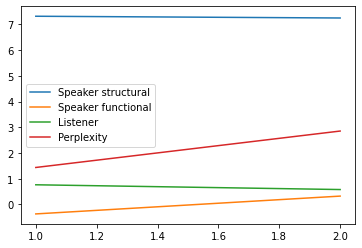

In [24]:
plt.plot(steps, speaker_losses_structural, label="Speaker structural")
plt.plot(steps, speaker_losses_functional, label="Speaker functional")
plt.plot(steps, listener_losses, label="Listener")
plt.plot(steps, perplexities, label="Perplexity")
plt.legend()
plt.show()

### Testing the pretrained sepaker

Below, some initial code for testing the pretrained speaker (basic image captioning model) is provided. Ignore for now.

In [9]:
embedded_imgs = torch.load("../train_logs/COCO_train_ResNet_features_reshaped_dict.pt")
# embedded_imgs = torch.load("../train_logs/3dshapes_all_ResNet_features_reshaped_all_sq.pt")

In [9]:
def get_loader_3dshapes(transform,
               mode='train',
               batch_size=1,
               vocab_threshold=None,
               vocab_file='../../data/vocab.pkl',
               start_word="START",
               end_word="END",
               unk_word="UNK",
               pad_word="PAD",
               vocab_from_file=True,
               num_workers=0,
               download_dir="../../../data/",
               vocab_from_pretrained=False,
               categorize_imgs=False,
               embedded_imgs="COCO_train_ResNet_features_reshaped_dict.pt",
              ):
    """Returns the data loader.
    Args:
      transform: Image transform.
      mode: One of 'train' or 'test'.
      batch_size: Batch size (if in testing mode, must have batch_size=1).
      vocab_threshold: Minimum word count threshold.
      vocab_file: File containing the vocabulary. 
      start_word: Special word denoting sentence start.
      end_word: Special word denoting sentence end.
      unk_word: Special word denoting unknown words.
      vocab_from_file: If False, create vocab from scratch & override any existing vocab_file.
                       If True, load vocab from from existing vocab_file, if it exists.
      num_workers: Number of subprocesses to use for data loading 
      cocoapi_loc: The location of the folder containing the COCO API: https://github.com/cocodataset/cocoapi
    """
    
    img_folder = os.path.join(download_dir, "") #'test2014/'
    annotations_file = os.path.join(download_dir, '') #image_info_test2014

    # TODO: alternatively, modify / sort the image IDS on the instantiated dataset.ids object 
    # COCO caption dataset.
    dataset = threeDshapes_Dataset(
        file=annotations_file,
        download_dir = download_dir, 
        img_transform=transform,
        text_transform=None,
        batch_size=batch_size,
        mode=mode,
        vocab_threshold=vocab_threshold,
        vocab_file=vocab_file,
        start_token=start_word,
        end_token=end_word,
        unk_token=unk_word,
        pad_token=pad_word,
        vocab_from_file=vocab_from_file,
        vocab_from_pretrained=vocab_from_pretrained,
        max_sequence_length=25,
        categorize_imgs=categorize_imgs,
        embedded_imgs=embedded_imgs,
    )
    

    if mode == 'train':
        # Randomly sample a caption length, and sample indices with that length.
        indices = dataset.get_func_train_indices()
        # Create and assign a batch sampler to retrieve a batch with the sampled indices.
        initial_sampler = torch.utils.data.sampler.SubsetRandomSampler(indices=indices)
        # data loader for COCO dataset.
        data_loader = torch.utils.data.DataLoader(
            dataset=dataset, 
            num_workers=num_workers,
            batch_sampler=torch.utils.data.sampler.BatchSampler(sampler=initial_sampler,
                                                                batch_size=dataset.batch_size,
                                                                drop_last=False))

    return data_loader

In [10]:
# transforms like in train # 
transform_test = transforms.Compose([#transforms.ToPILImage(),
                                     transforms.Resize((224, 224)), 
                                     transforms.ToTensor(), \
                                     transforms.Normalize((0.485, 0.456, 0.406), \
                                                          (0.229, 0.224, 0.225))])
data_loader_test = get_loader(transform=transform_test,
                         mode='train',
                         batch_size=1,
                         vocab_threshold=25,
                         vocab_from_file=True,
                         download_dir="../../../data/train", 
                              vocab_file="vocab4000.pkl"
#                          vocab_file='../../../data/vocab.pkl'
                        )
# data_loader_test = get_loader_3dshapes(transform=transform_test,
#                          mode='train',
#                          batch_size=1,
#                          vocab_threshold=25,
#                          vocab_from_file=True,
#                          download_dir="../../../data", 
#                               vocab_file="vocab3dshapes_short.pkl", # _short
# #                          vocab_file='../../../data/vocab.pkl'
#                                        embedded_imgs = embedded_imgs,
#                         )

Vocabulary successfully loaded from vocab.pkl file!
loading annotations into memory...
Done (t=0.50s)
creating index...
index created!
Obtaining caption lengths...


In [9]:
print(len(data_loader_test.dataset.vocab))
# data_loader_test.dataset.vocab.word2idx

49


In [17]:
# extract features for target from file
sanity_check = torch.load("../pretrain_img_IDs_2imgs_512dim.pt").tolist()

saved_target_features = embedded_imgs[str(sanity_check[test_targets.item()])]#torch.index_select(embedded_imgs, 0,  test_targets).squeeze(1)
print(str(sanity_check[test_targets.item()]))
saved_dist_features = embedded_imgs[str(sanity_check[test_dists.item()])]#torch.index_select(embedded_imgs, 0,  test_dists).squeeze(1)
print(str(sanity_check[test_dists.item()]))
# print(saved_target_features.shape)
# # extract features for target from model
# encoder_cnn = EncoderCNN(1048)
# ftr, resnet_ftr = encoder_cnn(orig_image)
# print(resnet_ftr.shape)
# print("features equal?: ", torch.equal(saved_target_features, resnet_ftr))
# print("features equal?: ", torch.equal(embedded_imgs[test_targets.item(), :], resnet_ftr))

603148
462417


In [35]:
scheck = torch.load( "../pretrain_img_IDs_flat_3dshapes_short.pt")
acheck = torch.load("../pretrain_anns_flat_3dshapes_short.pt")

In [36]:
print(scheck[:10])
acheck[:10]

['171367', '171367', '171367', '171367', '171367', '408965', '408965', '408965', '408965', '408965']


['a pink ball on dark blue floor',
 'a ball on the right',
 'there is a giant ball on dark blue floor',
 'the picture shows a gigantic pink ball on the right on dark blue floor in front of a dark blue wall',
 'the picture shows a gigantic pink ball on dark blue floor in front of a dark blue wall on the right',
 'there is a purple block on light green floor',
 'there is a purple block in front of a purple wall',
 'there is a block in the middle',
 'a large purple block located on light green floor in the middle in front of a purple wall',
 'a large purple block on light green floor in the middle in front of a purple wall']

In [47]:
len(data_loader_test.dataset.ids)
data_loader_test.dataset.labels['408965']


['a tiny yellow block nearly in the middle in front of a cyan wall on purple floor',
 'a tiny yellow block nearly in the middle on purple floor in front of a cyan wall',
 'a tiny yellow block on purple floor nearly in the middle in front of a cyan wall',
 'a tiny yellow block on purple floor in front of a cyan wall nearly in the middle',
 'the picture shows a tiny yellow block nearly in the middle in front of a cyan wall on purple floor',
 'the picture shows a tiny yellow block nearly in the middle on purple floor in front of a cyan wall',
 'the picture shows a tiny yellow block on purple floor nearly in the middle in front of a cyan wall',
 'the picture shows a tiny yellow block on purple floor in front of a cyan wall nearly in the middle',
 'a tiny yellow block located nearly in the middle in front of a cyan wall on purple floor',
 'a tiny yellow block located nearly in the middle on purple floor in front of a cyan',
 'a tiny yellow block located on purple floor nearly in the middle 

In [57]:
# create a testing split from the unused part of the train split bc i have extracted features for those
coco_train_keys = coco_train.anns.keys()
val_split = set(coco_train_keys) - set(sanity_check)
# torch.save(list(val_split), "val_split_IDs_from_COCO_train.pt")

In [52]:
sanity_check[138448]

508123

In [11]:
def clean_sentence(output):
    """
    Transform list of indices to a sentence.
    """
    list_string = []
    
    for idx in output:
#         print(idx)
        for i in idx:
#             print("i: ", i)
            try:
                list_string.append(data_loader_test.dataset.vocab.idx2word[i.item()])
            except ValueError:
                for y in i:
                    list_string.append(data_loader_test.dataset.vocab.idx2word[y.item()])
    list_string = list_string[:] # Discard <start> and <end> words
    sentence = ' '.join(list_string) # Convert list of string to full string
    sentence = sentence.capitalize()  # Capitalize the first letter of the first word
    return sentence


In [54]:
len(data_loader_test.dataset.ids)

150000

In [10]:
# Visualize sample image, before pre-processing.
# for img, dist, cap in iter(data_loader_test):
orig_image, dist_image, orig_ft, dist_ft, cap = next(iter(data_loader_test)) # 
# print(cap)
#     dist_img, dist, cap_dist = next(iter(data_loader_test))
plt.imshow(orig_image[0].squeeze(0).permute(1,2,0))
plt.title(clean_sentence(cap))
#     plt.imshow(dist_image[0].squeeze(0).permute(1,2,0))
#     plt.title("Distractor")
    
plt.show()
# orig_image.squeeze(0).shape

ValueError: not enough values to unpack (expected 5, got 3)

In [43]:
clean_sentence(cap)

'Start a car dashboard with a led display and a plush rabbit'

In [118]:
test_tensor = torch.Tensor([   [   4,   96,  217,   40,    4,   35,   22,    4,    2,    2,    2,    2]])
print(clean_sentence(test_tensor))

A person sitting on a street with a unk unk unk


Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


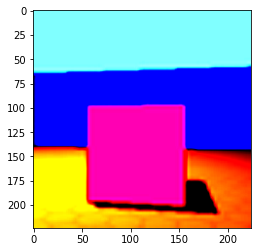

In [17]:
plt.imshow(dist_image[0].squeeze(0).permute(1,2,0))
# plt.title(clean_sentence(cap_dist))

plt.show()

In [50]:
orig_image.shape

torch.Size([1, 3, 224, 224])

In [17]:

# decoder_file = 'final_pretrained_speaker_coco_4000vocab_tf_desc05_padding_pureDecoding_cont_2__2.pkl' 
decoder_file = 'final_pretrained_speaker_coco_4000vocab_tf_desc05_padding_pureDecoding_cont_4__3.pkl' # 'decoder-noEnc-prepend-1024dim-4000vocab-rs1234-1.pkl'
# decoder_file = 'decoder-3dshapes-512dim-47vocab-rs1234-wEmb-short-5.pkl'
# decoder_file = 'decoder-3dshapes-512dim-49vocab-rs1234-exh-3.pkl'

embed_size = 512
visual_embed_size = 512
hidden_size = 512

# The size of the vocabulary.
vocab_size = len(data_loader_test.dataset.vocab)
print("VOCAB: ", vocab_size)
# Initialize the encoder and decoder, and set each to inference mode.
# encoder = EncoderMLP(2*2048, 2*visual_embed_size)
# encoder.eval()
decoder = DecoderRNN(embed_size, hidden_size, vocab_size, visual_embed_size)
decoder.train()

# Load the trained weights.
# encoder.load_state_dict(torch.load(os.path.join('./../models', encoder_file)))
decoder.load_state_dict(torch.load(os.path.join('../../../data/final/models', decoder_file)))

# Move models to GPU if CUDA is available.
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
# encoder.to(device)
decoder.to(device)

VOCAB:  4054


DecoderRNN(
  (embed): Embedding(4054, 512)
  (lstm): LSTM(1536, 512, batch_first=True)
  (linear): Linear(in_features=512, out_features=4054, bias=True)
  (project): Linear(in_features=2048, out_features=512, bias=True)
)

In [41]:
# test_dists = torch.tensor([0, 1]).long()
# test_target = torch.tensor([2, 3]).long()
# torch.equal(embedded_imgs[0, :], embedded_imgs[1, :])
data_loader_test.dataset.vocab.word2idx["sized"]
# print(saved_target_features)
# saved_dist_features

33

Ground truth:  Start a group of elephants walk past a group of trees . end
Loss:  3.0790011882781982
Loss:  3.1368932723999023
Loss:  3.061558961868286
Ground truth:  Start the head of a giraffe reaching out its tongue near a small boy . end
Loss:  5.2022857666015625
Loss:  4.971893310546875
Loss:  5.152209281921387
Ground truth:  Start a group of three remote controls on top of three papers . end
Loss:  4.437345504760742
Loss:  4.3579182624816895
Loss:  4.5421319007873535
Ground truth:  Start a young man holding a tennis racquet in his right hand . end
Loss:  3.785541534423828
Loss:  3.792574644088745
Loss:  3.7123894691467285
Ground truth:  Start a bird sitting on top of a tree branch in a forest . end
Loss:  3.2254903316497803
Loss:  3.093050003051758
Loss:  3.2437853813171387


/Users/polinatsvilodub/.local/lib/python3.7/site-packages/ipykernel_launcher.py:100: UserWarning: Matplotlib is currently using module://ipykernel.pylab.backend_inline, which is a non-GUI backend, so cannot show the figure.


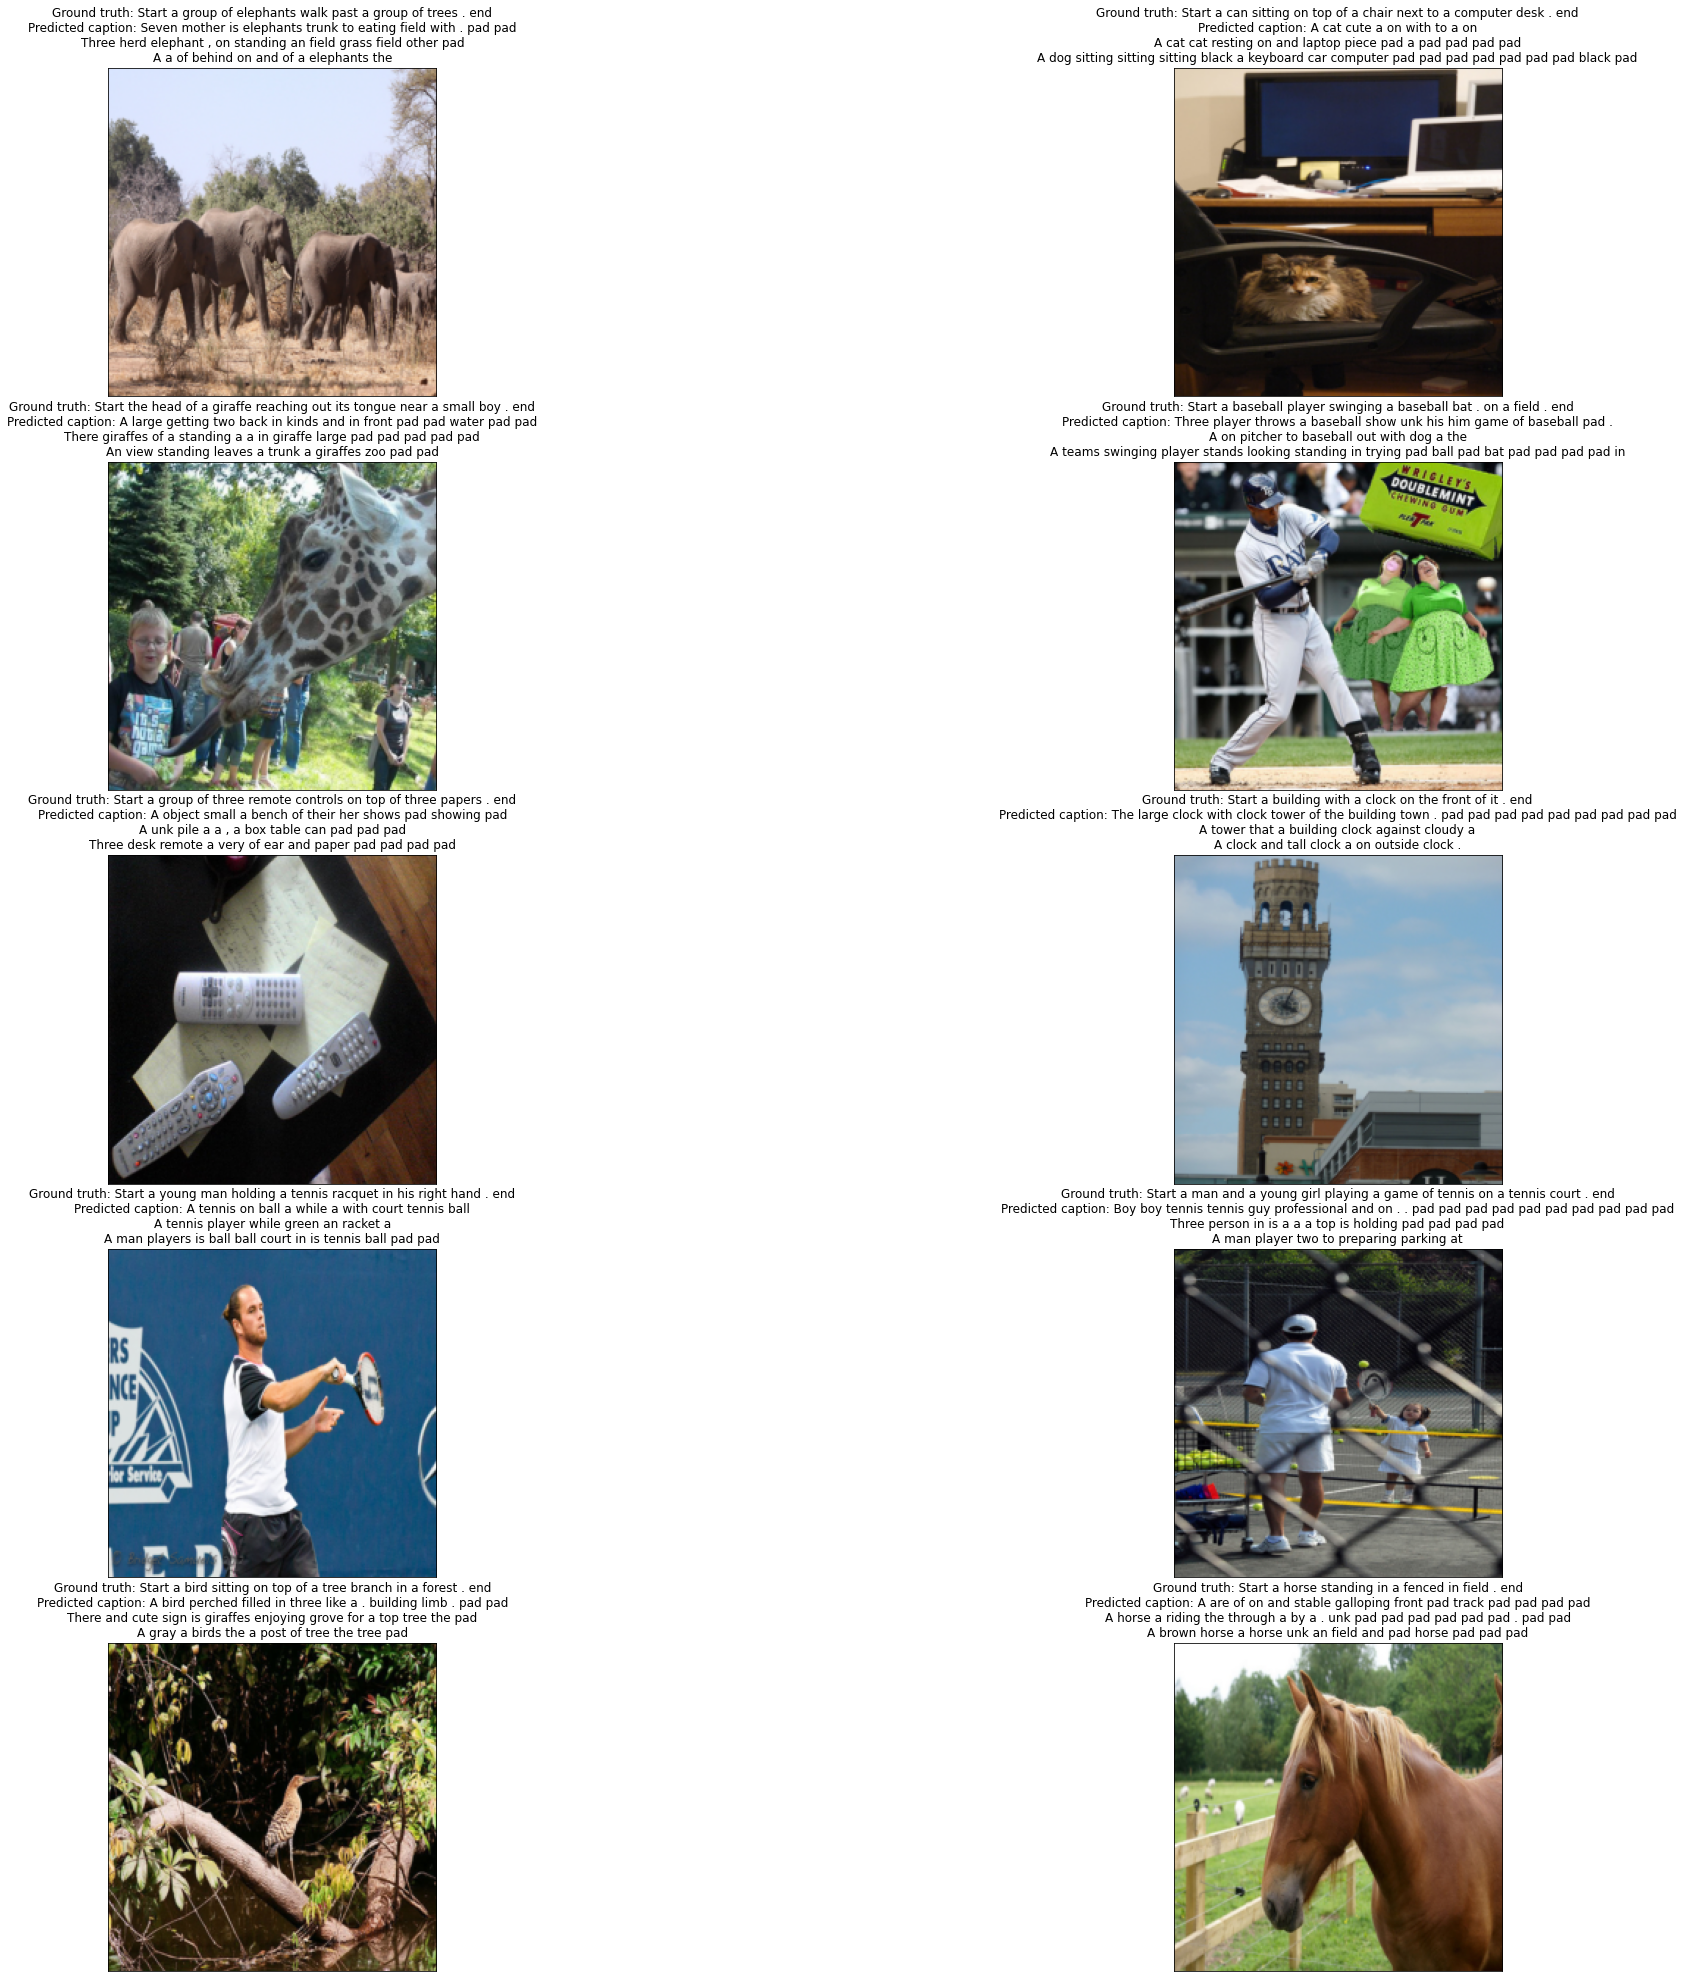

In [18]:
# iterate over 15 image pairs to manually inspect performance of the model
fig, axs = plt.subplots(nrows=5, ncols=2, figsize=(35, 35))

# helper for un-transforming the images for viz purposes
inv_transform = transforms.Compose([
    transforms.Normalize(mean = [ 0., 0., 0. ], 
                         std = [ 1/0.229, 1/0.224, 1/0.225 ]),
    transforms.Normalize(mean = [ -0.485, -0.456, -0.406 ],
                         std = [ 1., 1., 1. ]),
])

# collect some stats about the generated captions
ground_truth_num_tokens = 0
ground_truth_num_tokens_lst = []
predicted_num_tokens = 0
predicted_num_tokens_lst = []
sentences = []

# this same loop can be used for collecting results on ground truth vs generated caption lengths 
# it is especially interesting to see if the model is able to generate shorter captions 
# i.e. filter occurences of ground truth short captions and check average difference to predicted length
# just comment out plotting part
criterion = nn.CrossEntropyLoss().cuda() if torch.cuda.is_available() else nn.CrossEntropyLoss()

for i in range(5):
    test_indices = data_loader_test.dataset.get_func_train_indices() 
    test_targets = torch.tensor([x[0] for x in test_indices]).long()
    test_dists = torch.tensor([x[1] for x in test_indices]).long()
    
    # Create and assign a batch sampler to retrieve a batch with the sampled indices.
    new_sampler = torch.utils.data.sampler.SubsetRandomSampler(indices=test_indices)
    data_loader_test.batch_sampler.sampler = new_sampler        
    
    # get the images
    orig_image, dist_image, cap = next(iter(data_loader_test))    # saved_target_features, saved_dist_features,
    ground_truth_num_tokens += cap.shape[1] - 2 # remove start and end token 
    ground_truth_num_tokens_lst.append(cap.shape[1]-2)
    print("Ground truth: ", clean_sentence(cap))
    
    # retrieve saved features 
    saved_target_features = embedded_imgs[str(data_loader_test.dataset.ids[test_targets.item()])]#torch.index_select(embedded_imgs, 0,  test_targets).squeeze(1)
    saved_dist_features = embedded_imgs[str(data_loader_test.dataset.ids[test_dists.item()])]#torch.index_select(embedded_imgs, 0,  test_dists).squeeze(1)
#     saved_target_features = embedded_imgs[int(data_loader_test.dataset._img_ids_flat[test_targets.item()])]
#     saved_dist_features = embedded_imgs[int(data_loader_test.dataset._img_ids_flat[test_dists.item()])]
    
    # both_images = [saved_target_features, saved_dist_features] #torch.cat((saved_target_features, saved_dist_features), dim=-1)
    both_images = torch.cat((saved_target_features.unsqueeze(0).unsqueeze(0), saved_dist_features.unsqueeze(0).unsqueeze(0)), dim=1)
    
#     both_images = torch.cat((saved_target_features.unsqueeze(1), saved_dist_features.unsqueeze(1)), dim=1)
    three_caps = []
    for x in range(3):
        output, log_p, raw, topk = decoder.sample(both_images, cap.shape[-1]-1) # features_emb.unsqueeze(1)
    # out, hidden_state = decoder(both_images, cap, decoder.init_hidden(1))
    # print("Output", out)
        sentence_t = clean_sentence(output)
#         print('example sentence for target:\n', sentence_t)
        
        if "end" in sentence_t:
            len_sentence_t = sum([1 for x in sentence_t.split(" ")[:sentence_t.split(" ").index("end")] if x != "end" ])
        else:
            len_sentence_t = len(sentence_t.split(" "))
        
        predicted_num_tokens += len_sentence_t
        predicted_num_tokens_lst.append(len_sentence_t)
#         sentences.append(" ".join(sentence_t.split()[:len_sentence_t]))
        three_caps.append(" ".join(sentence_t.split()[:len_sentence_t]))
        sentences.extend(three_caps)
        
        loss = criterion(raw.transpose(1,2), cap[:, 1:])
        print("Loss: ", loss.item())
    both_images_d = torch.cat((saved_dist_features.unsqueeze(0).unsqueeze(1), saved_target_features.unsqueeze(0).unsqueeze(1)), dim=1) #[saved_dist_features, saved_target_features] #torch.cat((saved_dist_features, saved_target_features), dim=-1)
#     both_images_d = torch.cat((saved_dist_features.unsqueeze(0), saved_target_features.unsqueeze(0)), dim=1) #[saved_dist_features, saved_target_features] #torch.cat((saved_dist_features, saved_target_features), dim=-1)
    
    three_caps_d = []
    for x in range(3):
        output2, log_p2, raw2, topk2 = decoder.sample(both_images_d, 20) #both_features_d.unsqueeze(1)
        sentence_d = clean_sentence(output2)
#         print('example sentence for distractor:\n', sentence_d)
        if "end" in sentence_d :
            len_sentence_d = sum([1 for x in sentence_d.split(" ")[:sentence_d.split(" ").index("end")] if x != "end" ])
        else:
            len_sentence_d = len(sentence_d.split(" "))
        three_caps_d.append(" ".join(sentence_d.split()[:len_sentence_d]))
    # permute the images to get the ground truth caption of the distractor
    test_indices_d = [(test_indices[0][1], test_indices[0][0])]
    
    new_sampler_d = torch.utils.data.sampler.SubsetRandomSampler(indices=test_indices_d)
    data_loader_test.batch_sampler.sampler = new_sampler_d        
    _, _, cap_dist = next(iter(data_loader_test))
    
#     show the image, ground truth caption and predicted caption
    axs[i, 0].imshow(inv_transform(orig_image)[0].squeeze(0).permute(1,2,0))
    axs[i, 0].set_title("Ground truth: " + clean_sentence(cap) + "\nPredicted caption: " + "\n".join(three_caps))
    axs[i, 0].tick_params(left = False, right = False , labelleft = False , labelbottom = False, bottom = False)
#     # distractor 
    axs[i, 1].imshow(inv_transform(dist_image)[0].squeeze(0).permute(1,2,0))
    axs[i, 1].set_title("Ground truth: " + clean_sentence(cap_dist) + "\nPredicted caption: " + "\n".join(three_caps_d))
    axs[i, 1].tick_params(left = False, right = False , labelleft = False , labelbottom = False, bottom = False)

fig.show()

In [99]:
print(len(predicted_num_tokens_lst))
torch.save(predicted_num_tokens_lst, "1000valImgs_sentence_lengths_3dshapes_wShort.pt")
torch.save(ground_truth_num_tokens_lst, "1000valImgs_ground_truth_lengths_3dshapes_wShort.pt")

3000


In [100]:
# write out generated sentences
print(len(sentences))
pd.DataFrame({"val_predicted_sentences": sentences}).to_csv("1000valImgs_sentence_predictions_3dshapes_wShort.csv")

6000


In [31]:
print("Avg ground truth caption length: ", ground_truth_num_tokens/10)
print("Avg predicted caption length: ", predicted_num_tokens / 10)
sent_lens_df = pd.DataFrame({"ground": ground_truth_num_tokens_lst, "pred": predicted_num_tokens_lst})

Avg ground truth caption length:  18.5
Avg predicted caption length:  19.2


In [41]:
print(sent_lens_df["ground"].unique())
print(sent_lens_df["pred"].unique())
min_len_subset = sent_lens_df[sent_lens_df["ground"] < ground_truth_num_tokens/100]
min_len_subset["diff"] = abs(min_len_subset["ground"] - min_len_subset["pred"])
print("Average difference in lengths for below-avg ground truth captions: ", sum(min_len_subset["diff"])/len(min_len_subset["diff"]))
min_len_subset

[ 9 12 10  8 11 13 14 17 15 16  7]
[ 8 11 10 12 13  9]
Average difference in lengths for below-avg ground truth captions:  1.5


/Users/polinatsvilodub/.local/lib/python3.7/site-packages/ipykernel_launcher.py:4: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  after removing the cwd from sys.path.


,ground,pred,diff
0,9,8,1
3,10,10,0
4,10,11,1
5,9,10,1
6,10,12,2
...,...,...,...
92,10,9,1
93,9,10,1
95,11,10,1
97,8,11,3


In [67]:
# create a val split of the 3dshapes dataset 
trainIds_3dshapes = torch.load("../pretrain_img_IDs_unique_wShortCaps_3dshapes.pt")
print(len(trainIds_3dshapes))
valIDs_3dshapes = set(list(np.arange(480000))) - set([int(i) for i in trainIds_3dshapes])
print(len(valIDs_3dshapes))
valIDs_3dshapes_str = [str(i) for i in valIDs_3dshapes]
# torch.save(valIDs_3dshapes_str, "../val_img_IDs_wShort_unique_3dshapes.pt")

30000
450904


In [28]:
# init validation data loader
data_loader_val = get_loader(transform=transform_test,
                         mode='train',
                         batch_size=64,
                         vocab_threshold=25,
                         vocab_from_file=True,
                         download_dir="../../../data/train", 
                              vocab_file="vocab4000.pkl"
#                          vocab_file='vocab3dshapes.pkl',
                             
                        )
# data_loader_val = get_loader_3dshapes(transform=transform_test,
#                          mode='train',
#                          batch_size=1,
#                          vocab_threshold=25,
#                          vocab_from_file=True,
#                          download_dir="../../../data", 
#                               vocab_file="vocab3dshapes_short.pkl",
# #                          vocab_file='../../../data/vocab.pkl'
#                                        embedded_imgs = embedded_imgs,
#                         )
# data_loader_val.dataset.ids = val_split
print(len(data_loader_val.dataset.ids))

Vocabulary successfully loaded from vocab.pkl file!
loading annotations into memory...
Done (t=0.39s)
creating index...
index created!
Obtaining caption lengths...
1000


In [110]:
data_loader_val.dataset.ids[:10]
# data_loader_val.dataset._img_ids_flat[:10]

[524288, 524289, 524290, 524291, 524300, 524307, 524308, 524309, 524310, 28]

In [29]:
# validate
val_running_loss = 0.0
val_running_ppl = 0.0
losses_list = []
ppl_list = []
counter = 0
total = 0
sentences = []

total_steps = math.ceil(len(data_loader_val.dataset.ids) / data_loader_val.batch_sampler.batch_size)
print("Val total steps: ", total_steps+1)
criterion = nn.CrossEntropyLoss().cuda() if torch.cuda.is_available() else nn.CrossEntropyLoss()

decoder.train()

with torch.no_grad():
        print("Validating the model...")
        for i in range(1, total_steps+1): 
            
            hidden = decoder.init_hidden(batch_size=64)
             # get val indices
            indices = data_loader_val.dataset.get_func_train_indices()
            # create separate lists for retrieving the image emebddings
            target_inds = [x[0] for x in indices]
            distractor_inds = [x[1] for x in indices]

            new_sampler = torch.utils.data.sampler.SubsetRandomSampler(indices=indices)
            data_loader_val.batch_sampler.sampler = new_sampler

            counter += 1
            # print("Counter: ", counter)
            # Obtain the batch.
#             targets, distractors, target_features_arr, distractor_features_arr, target_captions = next(iter(data_loader_val))
            targets, distractors, target_captions = next(iter(data_loader_val))

                
            # Move batch of images and captions to GPU if CUDA is available.
            device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
            targets = targets.to(device)
            distractors = distractors.to(device)
            target_captions = target_captions.to(device)
            # Pass the inputs through the CNN-RNN model.
            # after retrieving the resnet embeddings
            # target_features = torch.index_select(embedded_imgs, 0, target_inds)
            # distractor_features = torch.index_select(embedded_imgs, 0, distractor_inds)

            # compute val predictions and loss
#             target_features = encoder(targets)#encoder(target_features)
#             distractor_features = encoder(distractors) #encoder(distractor_features)
            test_targets = [str(data_loader_val.dataset.ids[i]) for i in target_inds]
            test_dists = [str(data_loader_val.dataset.ids[i]) for i in distractor_inds]
            target_features = [embedded_imgs[i] for i in test_targets]
            target_features_arr = torch.stack(target_features)
            
            distractor_features = [embedded_imgs[i] for i in test_dists]
            distractor_features_arr = torch.stack(distractor_features)
            
            both_images = torch.cat((target_features_arr.unsqueeze(1), distractor_features_arr.unsqueeze(1)), dim=1)
            outputs, hidden = decoder(both_images, target_captions, hidden)
            
            # IF SAMPLING:
#             _, _, outputs, _ = decoder.sample(both_images, target_captions.shape[-1]-1)
            
            # The size of the vocabulary.
            vocab_size = len(data_loader_val.dataset.vocab)

            # Calculate the batch loss.
            loss = criterion(outputs.transpose(1,2), target_captions[:, 1:]) 
            losses_list.append(loss)
            ppl = np.exp(loss.item())
            ppl_list.append(ppl)

            val_running_loss += loss.item()
            val_running_ppl += ppl
            
            print("val running loss: ", val_running_loss)
            print("current PPL: ", ppl)
            
        print("Counter: ", counter)
        val_loss = val_running_loss / counter
        ppl_avg = val_running_ppl / counter
        print("FINAL VAL LOSS ", val_loss)
        print("FINAL AVG PPL ", ppl_avg)


Val total steps:  17
Validating the model...
val running loss:  5.5745439529418945
current PPL:  263.62930085101897
val running loss:  10.877657413482666
current PPL:  200.9615227321271
val running loss:  16.748932361602783
current PPL:  354.7009173761762
val running loss:  22.329455852508545
current PPL:  265.2104046880433
val running loss:  28.158838272094727
current PPL:  340.1485451118687
val running loss:  34.25915193557739
current PPL:  445.99764131855744
val running loss:  40.29095125198364
current PPL:  416.46370560539447
val running loss:  46.177491188049316
current PPL:  360.1569598688668
val running loss:  52.32956504821777
current PPL:  469.6904497506402
val running loss:  57.288145542144775
current PPL:  142.3915267328592
val running loss:  62.89880847930908
current PPL:  273.3253755061031
val running loss:  68.16877698898315
current PPL:  194.4098403197642
val running loss:  74.06137752532959
current PPL:  362.34635506400406
val running loss:  79.60580110549927
current PP

In [96]:
# len(ppl_list)
# csv_val = pd.DataFrame({"losses":losses_list, "ppl": ppl_list})
# csv_val.to_csv("val_results_leon_df_fixed.csv")

In [19]:
# plot the train and val losses and perplexities
# train_losses_1 = pd.read_csv('../../../data/pretraining_losses_epoch_1.csv')
# train_losses_2 = pd.read_csv('../../../data/pretraining_losses_epoch_2.csv')
# train_losses_3 = pd.read_csv('../../../data/pretraining_losses_epoch_3.csv')
# val_losses = pd.read_csv('../../../data/pretraining_2imgs_token0_1024dim_val_losses_6000vocab_epoch_8.csv')
# val_losses_1 = pd.read_csv('../../../data/pretrain_val_losses_epoch_1.csv')
# val_losses_2 = pd.read_csv('../../../data/pretrain_val_losses_epoch_2.csv')
# val_losses_3 = pd.read_csv('../../../data/pretrain_val_losses_epoch_3.csv')

train_losses = pd.read_csv('../../../data/final/losses_final_pretrained_speaker_coco_4000vocab_tf_desc05_padding_pureDecoding_cont_4_epoch_3.csv')#.append(pd.read_csv("../../../data/final/losses_final_pretrained_speaker_coco_4000vocab_tf_desc05_padding_pureDecoding_cont_epoch_1.csv")).append(pd.read_csv("../../../data/final/losses_final_pretrained_speaker_coco_4000vocab_tf_desc05_padding_pureDecoding_cont_2_epoch_2.csv"))
# train_losses = pd.read_csv('../../../data/final/losses_final_pretrained_speaker_3dshapes_exh_49vocab_tf_desc05_padding_pureDecoding_cont4_epoch_3.csv')#.append(pd.read_csv("../../../data/pretrain_3dshapes_512dim_losses_47vocab_rs1234_wEmb_short_cont_4.csv"))

# train_losses = pd.read_csv("../functional_training_losses_wPretrained_noEnc_vocab4000_metrics_epoch_1.csv")
# train_losses = pd.read_csv("../../../data/pretrain_noEnc_prepend_512dim_losses_4000vocab_rs1234_wEmb_epoch_1.csv").append(pd.read_csv("../../../data/pretrain_noEnc_prepend_512dim_losses_4000vocab_rs1234_wEmb_cont_epoch_7.csv"))

In [17]:
# investigate the teacher forcing rates produced in the scheduled sampling approach
scheduled_sampling = pd.read_csv("../../../data/pretrain_coco_512dim_scheduled_sampling_wGreedyDecoding_k150_epoch_2.csv")
print(scheduled_sampling.head())
len(scheduled_sampling["forcing_rate"].unique())

   steps    losses  perplexities          train_type  forcing_rate
0      1  8.328910   4141.899902  scheduled_sampling      0.993333
1      2  7.892308   2676.614990  scheduled_sampling      0.993289
2      3  6.876417    969.147339  scheduled_sampling      0.993245
3      4  6.935735   1028.375122  scheduled_sampling      0.993200
4      5  6.438577    625.515869  scheduled_sampling      0.993155


4690

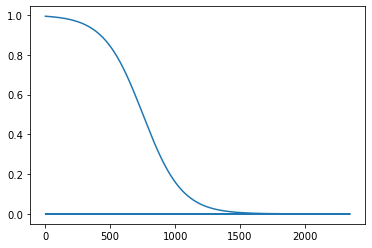

In [18]:
plt.plot(scheduled_sampling['steps'], scheduled_sampling["forcing_rate"])

In [40]:
150/(150 + np.exp(1000/150))

0.16029545757440783

In [20]:
# len(val_losses)
# val_steps = [i*1000 for i in range(1, len(val_losses)+1)]
# # val_losses.head()
# train_losses["speaker"] = train_losses["speaker_s"] + train_losses["speaker_f"]
# train_losses["plot_steps"] = list(range(0, len(train_losses["listener"])))
train_losses.head()
# len(train_losses)

,steps,losses,perplexities,train_type,forcing_rate
0,0,3.084542,21.857454,auto_regression,0.007812
1,1,3.305084,27.250824,auto_regression,0.007812
2,2,3.087251,21.916740,auto_regression,0.007812
3,3,3.085474,21.877831,auto_regression,0.007812
4,4,3.106795,22.349297,auto_regression,0.007812


In [18]:
train_losses.groupby(["forcing_rate"]).mean("losses")

,steps,losses,perplexities
forcing_rate,,,
0.0625,1171.5,3.231699,25.645987
0.1250,1171.5,3.257625,26.512215
0.2500,1171.5,3.220060,26.324109
0.5000,1171.5,3.055625,25.853949
1.0000,1171.5,2.601841,20.525332


In [21]:
# train_losses[train_losses["train_type"]=="auto_regression"].loc[:2345, :]
train_losses["forcing_rate"].unique()

array([0.0078125 , 0.00390625, 0.00195312])

In [22]:
inds2keep = list(np.arange(0, len(train_losses), 20))
train_losses_plot = train_losses.reset_index()[train_losses.reset_index().index.isin(inds2keep)]
len(train_losses_plot)
train_losses_plot.head(-5)

,index,steps,losses,perplexities,train_type,forcing_rate
0,0,0,3.084542,21.857454,auto_regression,0.007812
20,20,20,3.005953,20.205456,auto_regression,0.007812
40,40,40,3.159844,23.566917,auto_regression,0.007812
60,60,60,3.233210,25.360931,auto_regression,0.007812
80,80,80,3.077809,21.710779,auto_regression,0.007812
...,...,...,...,...,...,...
6840,6840,2152,3.358077,28.733883,auto_regression,0.001953
6860,6860,2172,3.314871,27.518847,auto_regression,0.001953
6880,6880,2192,3.232121,25.333338,auto_regression,0.001953
6900,6900,2212,3.022384,20.540211,auto_regression,0.001953


In [20]:
max(inds2keep)
0.015625*0.5

0.0078125

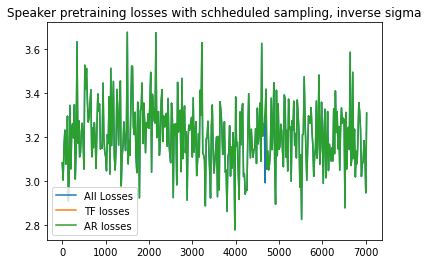

In [23]:
plt.plot(list(train_losses_plot.index), train_losses_plot['losses'], label="All Losses")
plt.plot(list(train_losses_plot[train_losses_plot["train_type"] == "teacher_forcing"].index), train_losses_plot[train_losses_plot["train_type"] == "teacher_forcing"]['losses'], label="TF losses")
plt.plot(list(train_losses_plot[train_losses_plot["train_type"] == "auto_regression"].index), train_losses_plot[train_losses_plot["train_type"] == "auto_regression"]['losses'], label="AR losses")

# plt.plot(val_steps, val_losses["val_losses"], label="Val")
# plt.plot(list(range(0, len(train_losses["perplexities"]))), train_losses['perplexities'], label="PPL")
# plt.plot(list(range(0, len(train_losses["perplexities"])))[200:], train_losses['perplexities'][200:], label="PPL")
# plt.plot(list(range(0, len(train_losses["listener"]))), train_losses['speaker_f'], label="S F")
# plt.plot(list(range(0, len(train_losses["listener"]))), train_losses['listener'], label="Listener")
# plt.plot(list(range(0, len(train_losses["listener"]))), train_losses['accuracies'], label="Acc")

# plt.ylim(ymax=10, ymin=4)
plt.legend()
plt.title("Speaker pretraining losses with schheduled sampling, inverse sigma")
plt.show()

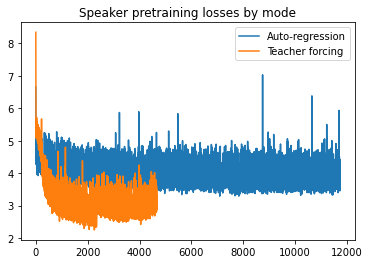

In [24]:
plt.plot(list(range(0, len(train_losses[train_losses["train_type"] == "auto_regression"]["steps"]))), train_losses[train_losses["train_type"] == "auto_regression"]['losses'], label="Auto-regression")
plt.plot(list(range(0, len(train_losses[train_losses["train_type"] == "teacher_forcing"]["steps"]))), train_losses[train_losses["train_type"] == "teacher_forcing"]['losses'], label="Teacher forcing")
plt.legend()
plt.title("Speaker pretraining losses by mode")
plt.show()

In [3]:
# drift metrics test 
pretrain_drift = pd.read_csv("../pretrain_noEnc_prepend_512dim_metrics_4000vocab_wEmb_epoch_7.csv")#.append(pd.read_csv("../pretrain_noEnc_prepend_512dim_metrics_4000vocab_wEmb_epoch_7.csv") )#"../pretrain_speaker_structural_drift_metrics_3dshapes-epoch_3.csv")
# pretrain_drift = pd.read_csv("../pretrain_3dshapes_512dim_metrics_47vocab_wEmb_short_epoch_5.csv")#.append(pd.read_csv("../pretrain_3dshapes_512dim_metrics_47vocab_wEmb_epoch_5.csv" ))

In [4]:
len(pretrain_drift)/64
# print(len(pretrain_drift))
# pretrain_drift.head(10)


28.0

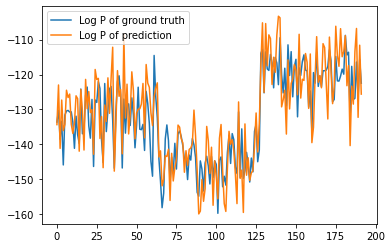

In [38]:
plt.plot(list(range(64*3)), pretrain_drift[pretrain_drift["steps"] == 2000]["structural_drift_true"], label="Log P of ground truth")
plt.plot(list(range(64*3)), pretrain_drift[pretrain_drift["steps"] == 2000]["structural_drift_pred"], label="Log P of prediction")

plt.legend()
plt.show()

In [5]:
pretrain_drift["epoch"] = [1]*64*4 + [2]*64*4 + [3]*64*4 + [4]*64*4 + [5]*64*4 + [6]*64*4 + [7]*64*4 #+ [8]*64*4

In [6]:
pretrain_drift_summary = pretrain_drift.groupby(["steps", "epoch"]).mean() 
pretrain_drift_summary

structural_drift_true  structural_drift_pred
steps epoch                                              
500   1                 -75.964035             -64.458128
      2                 -71.633559             -61.291456
      3                 -83.695331             -80.002268
      4                 -76.790443             -66.318938
      5                 -76.652094             -65.944334
      6                 -79.193741             -69.973420
      7                 -78.500953             -71.892909
1000  1                 -87.768488             -81.560779
      2                 -82.884094             -77.948304
      3                 -80.912749             -73.976877
      4                 -72.194356             -63.017132
      5                 -97.202672            -100.743834
      6                 -80.943838             -71.592072
      7                 -75.612047             -63.748493
1500  1                 -74.257171             -60.201356
      2                 -76.627204             -64.798575
      3                 -76.376746             -65.948057
      4                 -81.190784             -73.722980
      5                 -72.178999             -60.352828
      6                 -91.814307             -90.944142
      7                 -87.200520             -85.482149
2000  1                 -73.781088             -61.609857
      2                 -88.831492             -85.236881
      3                 -80.687950             -69.998553
      4                 -77.160872             -63.541165
      5                 -74.633098             -60.132140
      6                 -77.058745             -69.478660
      7                 -72.889295             -63.220487

In [8]:
pretrain_drift_summary["epochs_plot"] = [1,2,3,4,5,6,7] * 4
pretrain_drift_summary["steps_plot"] = [500] * 7 + [1000] * 7 + [1500] *7 + [2000] * 7 # + [2500] * 5
pretrain_drift_summary["steps_plot_sorted"] = pretrain_drift_summary["epochs_plot"] * pretrain_drift_summary["steps_plot"] + (pretrain_drift_summary["epochs_plot"]-1)*2000

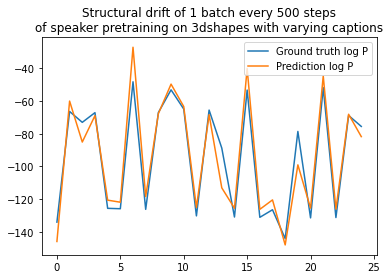

In [78]:
pretrain_drift_summary = pretrain_drift_summary.sort_values("steps_plot_sorted")
plt.plot(range(len(pretrain_drift_summary["steps_plot_sorted"])), pretrain_drift_summary["structural_drift_true"], label="Ground truth log P") # pretrain_drift_summary["steps_plot_sorted"]
plt.plot(range(len(pretrain_drift_summary["steps_plot_sorted"])), pretrain_drift_summary["structural_drift_pred"], label="Prediction log P")

plt.legend()
plt.title("Structural drift of 1 batch every 500 steps\nof speaker pretraining on 3dshapes with varying captions")
plt.show()

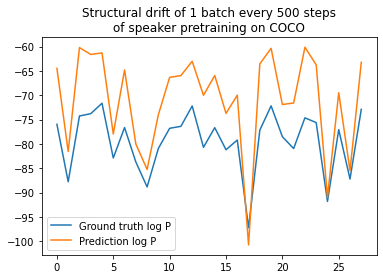

In [9]:
pretrain_drift_summary = pretrain_drift_summary.sort_values("steps_plot_sorted")
plt.plot(range(len(pretrain_drift_summary["steps_plot_sorted"])), pretrain_drift_summary["structural_drift_true"], label="Ground truth log P") # pretrain_drift_summary["steps_plot_sorted"]
plt.plot(range(len(pretrain_drift_summary["steps_plot_sorted"])), pretrain_drift_summary["structural_drift_pred"], label="Prediction log P")

plt.legend()
plt.title("Structural drift of 1 batch every 500 steps\nof speaker pretraining on COCO")
plt.show()

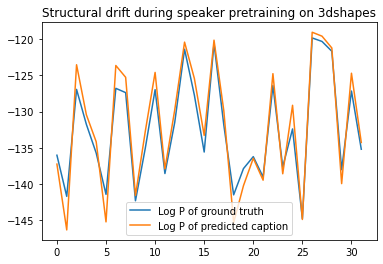

In [78]:
plt.plot(list(range(len(pretrain_drift_summary))), pretrain_drift_summary["structural_drift_true"], label="Log P of ground truth")
plt.plot(list(range(len(pretrain_drift_summary))), pretrain_drift_summary["structural_drift_pred"], label="Log P of predicted caption")
plt.legend()
# plt.title("Structural drift during speaker pretraining on MS COCO")
plt.title("Structural drift during speaker pretraining on 3dshapes")
plt.show()

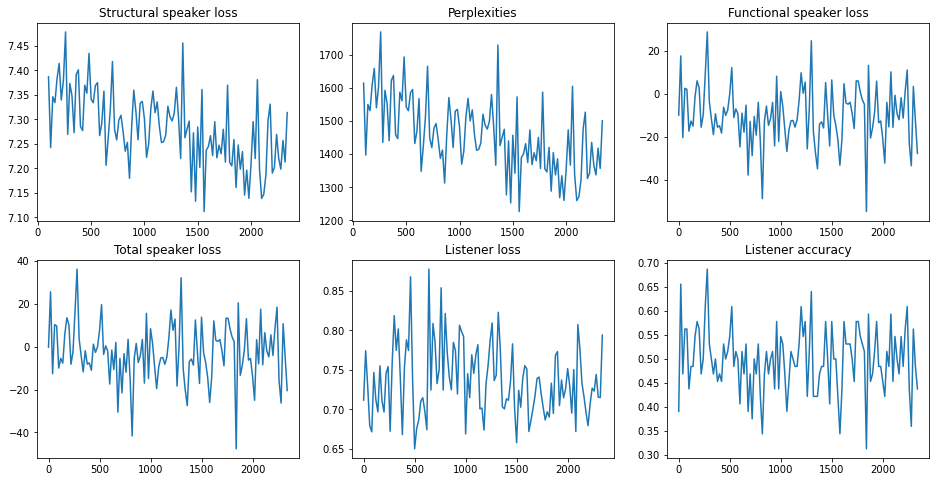

In [58]:
fig = plt.figure(figsize=(16, 8))
columns = 3
rows = 3

fig.add_subplot(2,3, 1)
plt.plot(train_losses_plot["plot_steps"][5:], train_losses_plot['speaker_s'][5:], label="S_s")
plt.title("Structural speaker loss")
fig.add_subplot(2,3, 2)
plt.plot(train_losses_plot["plot_steps"][5:], train_losses_plot['perplexities'][5:], label="PPL")
plt.title("Perplexities")
fig.add_subplot(2,3,3)
plt.plot(train_losses_plot["plot_steps"], train_losses_plot['speaker_f'], label="S_f")
plt.title("Functional speaker loss")

fig.add_subplot(2,3, 4)
plt.plot(train_losses_plot["plot_steps"], train_losses_plot['speaker'], label="Speaker loss")
plt.title("Total speaker loss")
fig.add_subplot(2,3,5)
plt.plot(train_losses_plot["plot_steps"], train_losses_plot['listener'], label="Listener loss")
plt.title("Listener loss")
fig.add_subplot(2,3,6)
plt.plot(train_losses_plot["plot_steps"], train_losses_plot['accuracies'], label="Acc")
plt.title("Listener accuracy")

plt.show()


In [63]:
# plot drift metric
train_metrics = pd.read_csv("../functional_language_drift_metrics_train_epoch_5.csv")

train_metrics["drift_num"] = train_metrics["semantic_drifts"].apply(lambda s: float(re.sub("[^0-9\.-]", "", s)))
train_metrics.head()
metrics_tensor = torch.tensor(train_metrics["drift_num"]).view(-1, 64)
# metrics_tensor.shape # len(train_metrics)
metrics_mean = metrics_tensor.mean(dim=1)
metrics_mean_list = metrics_mean.tolist()
metrics_steps = list(range(0, len(metrics_mean_list)))
# train_metrics.iloc[2, 2]

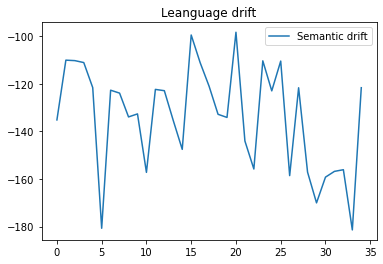

In [64]:
plt.plot(metrics_steps, metrics_mean_list, label="Semantic drift")

plt.legend()
plt.title("Leanguage drift")
plt.show()

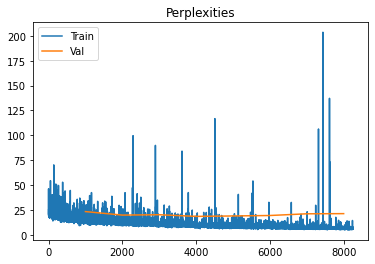

In [9]:
val_perplexities = [np.exp(x) for x in val_losses["val_losses"]]

plt.plot(list(range(0, len(train_losses["perplexities"][500:]))), train_losses['perplexities'][500:], label="Train")
plt.plot(val_steps, val_perplexities, label="Val")
plt.legend()
plt.title("Perplexities")
plt.show()

Ideally, the pretrained speaker model should be evaluated in order to estimate the quality of the base performance, since it is critical for any kinds of changes that could follow from functional training. The evaluation should contain some standard methods like BLEU, and maybe one or two language drift explorations. Some examples should be inspected manually, too.  
In case the performance is bad, the following aspects could be tweaked: train longer (larger early stopping delta), different NN weight initialization, more data. 

In [9]:
# put together the 3dshapes features
f1 = torch.load("../3dshapes_all_ResNet_features_reshaped_23000_first.pt")
f2 = torch.load("../3dshapes_all_ResNet_features_reshaped_240000_first.pt")
f3 = torch.load("../3dshapes_all_ResNet_features_reshaped.pt")

In [10]:
print(f1.shape)
print(f2.shape)
f3.shape

torch.Size([23001, 1, 2048])
torch.Size([240001, 1, 2048])


torch.Size([239999, 1, 2048])

In [25]:
print(480000 - (23001 + 240001))
f1_f2 = torch.cat((f1, f2), dim=0)
f1_f2.shape

216998


torch.Size([263002, 1, 2048])

In [31]:
# np.where(f3 == f1_f2[240001])
print(f3[0])
f1_f2[240000]
480000 - 263002
# 239999 - 216998
f3[23001:].shape

tensor([[0.5921, 0.6009, 0.0884,  ..., 0.0340, 0.0227, 0.3830]])


torch.Size([216998, 1, 2048])

In [32]:
f1_f2_f3 = torch.cat((f1_f2, f3[23001:]), dim=0)
f1_f2_f3.shape

torch.Size([480000, 1, 2048])

In [34]:
# torch.unique(f1_f2_f3, dim=0).shape
# torch.save(f1_f2_f3, "../3dshapes_all_ResNet_features_reshaped_all.pt")

### References

The code was created with the help of [this](https://medium.com/@deepeshrishu09/automatic-image-captioning-with-pytorch-cf576c98d319) and [this](https://medium.com/@thechrisyoon/deriving-policy-gradients-and-implementing-reinforce-f887949bd63) tutorial.

In [70]:
## create a test corpus

# data_loader_val = get_loader(transform=transform_test,
#                          mode='val',
#                          batch_size=1,
#                          vocab_threshold=11,
#                          vocab_from_file=True,
#                          download_dir="../../../data/val", 
#                               vocab_file="vocab.pkl"
# #                          vocab_file='../../../data/vocab.pkl'
#                         )
train_coco = COCO("../../../data/train/annotations/captions_train2014.json") #.anns.keys()
used_val_ids = torch.load("../pretrain_val_img_IDs_2imgs_main.pt").tolist()

loading annotations into memory...
Done (t=0.45s)
creating index...
index created!


In [45]:
len(val_ids)
len(used_val_ids)

3700

In [46]:
# sample 7000 test images and captions which were not used before
possible_test_ids = [x for x in val_ids if x not in used_val_ids]
test_ds = list(np.random.choice(possible_test_ids, 7000))

In [51]:
len(test_ds)

7000

In [52]:
# torch.save(test_ds, "testset_IDs_fromVal_ds.pt")

In [60]:
# create a loop iterating over the test images to compute the BLEU score for two models

torch.manual_seed(42)
transform_test = transforms.Compose([transforms.Resize((224, 224)), \
                                     transforms.ToTensor(), \
                                     transforms.Normalize((0.485, 0.456, 0.406), \
                                                          (0.229, 0.224, 0.225))])
data_loader_test = get_loader(transform=transform_test,
                         mode='val',
                         batch_size=1,
                         vocab_threshold=11,
                         vocab_from_file=True,
                         download_dir="../../../data/val", 
                              vocab_file="vocab.pkl"
#                          vocab_file='../../../data/vocab.pkl'
                        )
encoder_file_prepend = 'encoder-byImage-prepend-1024dim-6000vocab-wResNet-1.pkl' 
decoder_file_prepend = 'decoder-byImage-prepend-1024dim-6000vocab-wResNet-1.pkl'

encoder_file_token0 = 'encoder-byImage-1024dim-6000vocab-wResNet-2.pkl' 
decoder_file_token0 = 'decoder-byImage-1024dim-6000vocab-wResNet-2.pkl'


embed_size = 2048 #512
visual_embed_size = 1024
hidden_size = 512

# The size of the vocabulary.
vocab_size = len(data_loader_test.dataset.vocab)
print("VOCAB: ", vocab_size)
# Initialize the encoder and decoder, and set each to inference mode.
encoder_prepend = EncoderCNN(visual_embed_size)
encoder_prepend.eval()
decoder_prepend = DecoderRNN(embed_size, hidden_size, vocab_size, 1024)
decoder_prepend.eval()

# Load the trained weights.
encoder_prepend.load_state_dict(torch.load(os.path.join('./../models', encoder_file_prepend)))
decoder_prepend.load_state_dict(torch.load(os.path.join('./../models', decoder_file_prepend)))

# Move models to GPU if CUDA is available.
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
encoder_prepend.to(device)
decoder_prepend.to(device)

## second model
encoder_token0 = EncoderCNN(visual_embed_size)
encoder_token0.eval()
decoder_token0 = DecoderRNN_token0(embed_size, hidden_size, vocab_size, 1024)
decoder_token0.eval()

# Load the trained weights.
encoder_token0.load_state_dict(torch.load(os.path.join('./../models', encoder_file_token0)))
decoder_token0.load_state_dict(torch.load(os.path.join('./../models', decoder_file_token0)))

# Move models to GPU if CUDA is available.
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
encoder_token0.to(device)
decoder_token0.to(device)


Vocabulary successfully loaded from vocab.pkl file!
loading annotations into memory...
Done (t=0.21s)
creating index...
index created!
Obtaining caption lengths...
VOCAB:  6039


DecoderRNN_token0(
  (embed): Embedding(6039, 2048)
  (lstm): LSTM(2048, 512, batch_first=True)
  (linear): Linear(in_features=512, out_features=6039, bias=True)
)

In [61]:
# create dicts
orig_captions = []
decoder_token0_captions = []
decoder_prepend_captions = []

# iterate over dataset
for i in range(len(test_ds)):
    test_indices = data_loader_test.dataset.get_func_train_indices() 
    print("Test inds: ", test_indices)
    # Create and assign a batch sampler to retrieve a batch with the sampled indices.
    new_sampler = torch.utils.data.sampler.SubsetRandomSampler(indices=test_indices)
    data_loader_test.batch_sampler.sampler = new_sampler  

    orig_image, dist_image, cap = next(iter(data_loader_test))
    orig_captions.append(cap)
    
    # get the predictions
    # model with prepended images
    features_t_emb, _ = encoder_prepend(orig_image)
    features_d_emb, _ = encoder_prepend(dist_image)
    both_images = torch.cat((features_t_emb, features_d_emb), dim=-1)

    output_prepend, log_p, raw = decoder_prepend.sample(both_images.unsqueeze(1), 27)
    sentence_prepend = clean_sentence(output_prepend)
    decoder_prepend_captions.append(sentence_prepend)
    
    # model with token 0 images
    features_t_emb, _ = encoder_token0(orig_image)
    features_d_emb, _ = encoder_token0(dist_image)
    both_images = torch.cat((features_t_emb, features_d_emb), dim=-1)

    output_token0, log_p, raw = decoder_token0.sample(both_images.unsqueeze(1), 27)
    sentence_token0 = clean_sentence(output_token0)
    decoder_token0_captions.append(sentence_token0)

Test inds:  [(1848, 1785)]
Ann_id in getitem:  42557
Test inds:  [(995, 1005)]
Ann_id in getitem:  23655
Test inds:  [(337, 1525)]
Ann_id in getitem:  8226
Test inds:  [(48, 426)]
Ann_id in getitem:  974
Test inds:  [(492, 2181)]
Ann_id in getitem:  11821
Test inds:  [(2177, 1697)]
Ann_id in getitem:  49079
Test inds:  [(865, 1777)]
Ann_id in getitem:  20910
Test inds:  [(3419, 1826)]
Ann_id in getitem:  78749
Test inds:  [(2198, 1367)]
Ann_id in getitem:  49494
Test inds:  [(2820, 3557)]
Ann_id in getitem:  64986
Test inds:  [(3571, 3646)]
Ann_id in getitem:  82346
Test inds:  [(1831, 1280)]
Ann_id in getitem:  42080
Test inds:  [(2739, 2219)]
Ann_id in getitem:  63066
Test inds:  [(1980, 2835)]
Ann_id in getitem:  45155
Test inds:  [(2078, 1303)]
Ann_id in getitem:  47189
Test inds:  [(595, 617)]
Ann_id in getitem:  14427
Test inds:  [(2211, 588)]
Ann_id in getitem:  49740
Test inds:  [(1574, 305)]
Ann_id in getitem:  37275
Test inds:  [(2543, 4)]
Ann_id in getitem:  57767
Test inds:

Test inds:  [(3546, 611)]
Ann_id in getitem:  81822
Test inds:  [(2136, 3583)]
Ann_id in getitem:  48396
Test inds:  [(3697, 115)]
Ann_id in getitem:  85435
Test inds:  [(235, 2673)]
Ann_id in getitem:  5749
Test inds:  [(1886, 2478)]
Ann_id in getitem:  43376
Test inds:  [(1037, 1390)]
Ann_id in getitem:  24537
Test inds:  [(3301, 2375)]
Ann_id in getitem:  75728
Test inds:  [(2910, 282)]
Ann_id in getitem:  67092
Test inds:  [(3124, 3120)]
Ann_id in getitem:  72017
Test inds:  [(2907, 1060)]
Ann_id in getitem:  67051
Test inds:  [(2877, 2738)]
Ann_id in getitem:  66124
Test inds:  [(402, 1295)]
Ann_id in getitem:  9897
Test inds:  [(1212, 2074)]
Ann_id in getitem:  28241
Test inds:  [(1921, 2782)]
Ann_id in getitem:  43968
Test inds:  [(176, 1849)]
Ann_id in getitem:  4451
Test inds:  [(972, 2369)]
Ann_id in getitem:  22947
Test inds:  [(2738, 795)]
Ann_id in getitem:  63062
Test inds:  [(3397, 561)]
Ann_id in getitem:  78099
Test inds:  [(2849, 3046)]
Ann_id in getitem:  65577
Test 

Test inds:  [(2140, 811)]
Ann_id in getitem:  48460
Test inds:  [(468, 706)]
Ann_id in getitem:  11279
Test inds:  [(1947, 1682)]
Ann_id in getitem:  44320
Test inds:  [(2089, 228)]
Ann_id in getitem:  47397
Test inds:  [(2518, 2206)]
Ann_id in getitem:  57251
Test inds:  [(3067, 2359)]
Ann_id in getitem:  70680
Test inds:  [(198, 2472)]
Ann_id in getitem:  4985
Test inds:  [(1236, 1468)]
Ann_id in getitem:  28894
Test inds:  [(1001, 119)]
Ann_id in getitem:  23725
Test inds:  [(2919, 1852)]
Ann_id in getitem:  67228
Test inds:  [(1287, 1488)]
Ann_id in getitem:  30176
Test inds:  [(1730, 112)]
Ann_id in getitem:  40309
Test inds:  [(702, 2227)]
Ann_id in getitem:  17065
Test inds:  [(602, 3304)]
Ann_id in getitem:  14565
Test inds:  [(20, 3215)]
Ann_id in getitem:  452
Test inds:  [(2390, 1677)]
Ann_id in getitem:  54109
Test inds:  [(867, 2853)]
Ann_id in getitem:  20919
Test inds:  [(3402, 1442)]
Ann_id in getitem:  78308
Test inds:  [(1110, 372)]
Ann_id in getitem:  25767
Test inds

Test inds:  [(2507, 2111)]
Ann_id in getitem:  57060
Test inds:  [(1724, 1222)]
Ann_id in getitem:  40226
Test inds:  [(2436, 733)]
Ann_id in getitem:  55096
Test inds:  [(1004, 3684)]
Ann_id in getitem:  23799
Test inds:  [(1325, 1491)]
Ann_id in getitem:  31012
Test inds:  [(3315, 760)]
Ann_id in getitem:  76162
Test inds:  [(283, 3050)]
Ann_id in getitem:  6647
Test inds:  [(1900, 2653)]
Ann_id in getitem:  43579
Test inds:  [(2143, 913)]
Ann_id in getitem:  48494
Test inds:  [(2334, 845)]
Ann_id in getitem:  52637
Test inds:  [(2831, 2226)]
Ann_id in getitem:  65285
Test inds:  [(940, 130)]
Ann_id in getitem:  22343
Test inds:  [(1091, 1202)]
Ann_id in getitem:  25434
Test inds:  [(2804, 198)]
Ann_id in getitem:  64707
Test inds:  [(2271, 3566)]
Ann_id in getitem:  51386
Test inds:  [(51, 1230)]
Ann_id in getitem:  1037
Test inds:  [(1783, 1501)]
Ann_id in getitem:  41100
Test inds:  [(3431, 2644)]
Ann_id in getitem:  79085
Test inds:  [(760, 2006)]
Ann_id in getitem:  18463
Test i

Test inds:  [(580, 3649)]
Ann_id in getitem:  14091
Test inds:  [(1645, 1429)]
Ann_id in getitem:  38521
Test inds:  [(2683, 1260)]
Ann_id in getitem:  61622
Test inds:  [(1688, 3397)]
Ann_id in getitem:  39530
Test inds:  [(2781, 1680)]
Ann_id in getitem:  64155
Test inds:  [(2962, 2422)]
Ann_id in getitem:  68179
Test inds:  [(2571, 2417)]
Ann_id in getitem:  58628
Test inds:  [(2370, 2253)]
Ann_id in getitem:  53599
Test inds:  [(3302, 1136)]
Ann_id in getitem:  75751
Test inds:  [(3186, 1261)]
Ann_id in getitem:  73364
Test inds:  [(2574, 1125)]
Ann_id in getitem:  58663
Test inds:  [(1270, 643)]
Ann_id in getitem:  29641
Test inds:  [(2143, 3257)]
Ann_id in getitem:  48494
Test inds:  [(2862, 1068)]
Ann_id in getitem:  65761
Test inds:  [(2562, 2551)]
Ann_id in getitem:  58233
Test inds:  [(2990, 2698)]
Ann_id in getitem:  68939
Test inds:  [(1873, 523)]
Ann_id in getitem:  43075
Test inds:  [(2543, 1195)]
Ann_id in getitem:  57767
Test inds:  [(1968, 568)]
Ann_id in getitem:  449

Test inds:  [(1017, 2972)]
Ann_id in getitem:  24110
Test inds:  [(768, 348)]
Ann_id in getitem:  18562
Test inds:  [(845, 1356)]
Ann_id in getitem:  20472
Test inds:  [(629, 25)]
Ann_id in getitem:  15332
Test inds:  [(1835, 991)]
Ann_id in getitem:  42156
Test inds:  [(1223, 1953)]
Ann_id in getitem:  28576
Test inds:  [(1429, 292)]
Ann_id in getitem:  33892
Test inds:  [(2611, 3596)]
Ann_id in getitem:  59841
Test inds:  [(2916, 1487)]
Ann_id in getitem:  67135
Test inds:  [(2034, 776)]
Ann_id in getitem:  46308
Test inds:  [(1290, 3632)]
Ann_id in getitem:  30285
Test inds:  [(1566, 1677)]
Ann_id in getitem:  36993
Test inds:  [(1592, 3174)]
Ann_id in getitem:  37549
Test inds:  [(2842, 3607)]
Ann_id in getitem:  65439
Test inds:  [(3606, 32)]
Ann_id in getitem:  83291
Test inds:  [(939, 937)]
Ann_id in getitem:  22341
Test inds:  [(2572, 170)]
Ann_id in getitem:  58645
Test inds:  [(3131, 2447)]
Ann_id in getitem:  72184
Test inds:  [(2380, 1870)]
Ann_id in getitem:  53783
Test in

Test inds:  [(2611, 1933)]
Ann_id in getitem:  59841
Test inds:  [(3430, 2388)]
Ann_id in getitem:  79058
Test inds:  [(1429, 3110)]
Ann_id in getitem:  33892
Test inds:  [(468, 2304)]
Ann_id in getitem:  11279
Test inds:  [(2875, 3226)]
Ann_id in getitem:  66059
Test inds:  [(2859, 2344)]
Ann_id in getitem:  65727
Test inds:  [(1449, 956)]
Ann_id in getitem:  34312
Test inds:  [(1042, 3197)]
Ann_id in getitem:  24664
Test inds:  [(3098, 3058)]
Ann_id in getitem:  71418
Test inds:  [(2177, 3345)]
Ann_id in getitem:  49079
Test inds:  [(1171, 2745)]
Ann_id in getitem:  27251
Test inds:  [(2505, 1751)]
Ann_id in getitem:  57045
Test inds:  [(2550, 68)]
Ann_id in getitem:  57948
Test inds:  [(3603, 1620)]
Ann_id in getitem:  83130
Test inds:  [(2165, 3484)]
Ann_id in getitem:  48865
Test inds:  [(397, 102)]
Ann_id in getitem:  9769
Test inds:  [(2745, 1590)]
Ann_id in getitem:  63173
Test inds:  [(3218, 1829)]
Ann_id in getitem:  74015
Test inds:  [(3558, 3606)]
Ann_id in getitem:  82054


Test inds:  [(1228, 1048)]
Ann_id in getitem:  28712
Test inds:  [(904, 2000)]
Ann_id in getitem:  21602
Test inds:  [(1359, 3150)]
Ann_id in getitem:  32039
Test inds:  [(2407, 3324)]
Ann_id in getitem:  54427
Test inds:  [(1865, 1261)]
Ann_id in getitem:  42971
Test inds:  [(3517, 114)]
Ann_id in getitem:  81156
Test inds:  [(3010, 1153)]
Ann_id in getitem:  69388
Test inds:  [(476, 2261)]
Ann_id in getitem:  11512
Test inds:  [(650, 499)]
Ann_id in getitem:  15861
Test inds:  [(3501, 259)]
Ann_id in getitem:  80649
Test inds:  [(2613, 3325)]
Ann_id in getitem:  59857
Test inds:  [(2473, 1964)]
Ann_id in getitem:  56274
Test inds:  [(419, 2483)]
Ann_id in getitem:  10187
Test inds:  [(704, 1225)]
Ann_id in getitem:  17085
Test inds:  [(909, 1161)]
Ann_id in getitem:  21647
Test inds:  [(1641, 2007)]
Ann_id in getitem:  38500
Test inds:  [(3523, 2315)]
Ann_id in getitem:  81287
Test inds:  [(3676, 2923)]
Ann_id in getitem:  84764
Test inds:  [(1653, 56)]
Ann_id in getitem:  38727
Test

Test inds:  [(914, 3286)]
Ann_id in getitem:  21788
Test inds:  [(2582, 3457)]
Ann_id in getitem:  58999
Test inds:  [(2776, 3064)]
Ann_id in getitem:  63953
Test inds:  [(32, 1365)]
Ann_id in getitem:  701
Test inds:  [(3591, 860)]
Ann_id in getitem:  82805
Test inds:  [(3292, 2720)]
Ann_id in getitem:  75467
Test inds:  [(985, 850)]
Ann_id in getitem:  23419
Test inds:  [(414, 3137)]
Ann_id in getitem:  10100
Test inds:  [(3330, 1343)]
Ann_id in getitem:  76518
Test inds:  [(2275, 1777)]
Ann_id in getitem:  51424
Test inds:  [(2660, 2613)]
Ann_id in getitem:  61028
Test inds:  [(214, 3514)]
Ann_id in getitem:  5369
Test inds:  [(2822, 469)]
Ann_id in getitem:  65049
Test inds:  [(2799, 1333)]
Ann_id in getitem:  64555
Test inds:  [(953, 72)]
Ann_id in getitem:  22578
Test inds:  [(594, 2172)]
Ann_id in getitem:  14398
Test inds:  [(2179, 2091)]
Ann_id in getitem:  49124
Test inds:  [(1957, 2022)]
Ann_id in getitem:  44503
Test inds:  [(1997, 3568)]
Ann_id in getitem:  45522
Test inds

Test inds:  [(1914, 3157)]
Ann_id in getitem:  43829
Test inds:  [(397, 1721)]
Ann_id in getitem:  9769
Test inds:  [(2271, 3649)]
Ann_id in getitem:  51386
Test inds:  [(3312, 147)]
Ann_id in getitem:  76011
Test inds:  [(2633, 599)]
Ann_id in getitem:  60290
Test inds:  [(773, 2130)]
Ann_id in getitem:  18756
Test inds:  [(202, 1885)]
Ann_id in getitem:  5018
Test inds:  [(2612, 1923)]
Ann_id in getitem:  59845
Test inds:  [(518, 2488)]
Ann_id in getitem:  12357
Test inds:  [(2093, 2067)]
Ann_id in getitem:  47425
Test inds:  [(1153, 2160)]
Ann_id in getitem:  26813
Test inds:  [(1399, 843)]
Ann_id in getitem:  33180
Test inds:  [(923, 1976)]
Ann_id in getitem:  22116
Test inds:  [(2888, 1885)]
Ann_id in getitem:  66440
Test inds:  [(2435, 2681)]
Ann_id in getitem:  55095
Test inds:  [(2678, 3696)]
Ann_id in getitem:  61409
Test inds:  [(1106, 1006)]
Ann_id in getitem:  25701
Test inds:  [(3589, 1354)]
Ann_id in getitem:  82774
Test inds:  [(1616, 3674)]
Ann_id in getitem:  37888
Tes

Test inds:  [(3010, 416)]
Ann_id in getitem:  69388
Test inds:  [(886, 3394)]
Ann_id in getitem:  21159
Test inds:  [(1421, 2230)]
Ann_id in getitem:  33710
Test inds:  [(2433, 304)]
Ann_id in getitem:  55019
Test inds:  [(867, 804)]
Ann_id in getitem:  20919
Test inds:  [(2013, 1626)]
Ann_id in getitem:  45826
Test inds:  [(1483, 2083)]
Ann_id in getitem:  35229
Test inds:  [(360, 1842)]
Ann_id in getitem:  8724
Test inds:  [(242, 522)]
Ann_id in getitem:  5871
Test inds:  [(1749, 1325)]
Ann_id in getitem:  40552
Test inds:  [(1810, 116)]
Ann_id in getitem:  41711
Test inds:  [(1375, 2759)]
Ann_id in getitem:  32506
Test inds:  [(3086, 454)]
Ann_id in getitem:  71201
Test inds:  [(3487, 3309)]
Ann_id in getitem:  80344
Test inds:  [(963, 2496)]
Ann_id in getitem:  22776
Test inds:  [(143, 806)]
Ann_id in getitem:  3464
Test inds:  [(1220, 3462)]
Ann_id in getitem:  28505
Test inds:  [(3468, 3102)]
Ann_id in getitem:  80052
Test inds:  [(434, 555)]
Ann_id in getitem:  10667
Test inds: 

Test inds:  [(974, 1935)]
Ann_id in getitem:  22963
Test inds:  [(3580, 1938)]
Ann_id in getitem:  82483
Test inds:  [(478, 1705)]
Ann_id in getitem:  11519
Test inds:  [(841, 1012)]
Ann_id in getitem:  20304
Test inds:  [(238, 1658)]
Ann_id in getitem:  5795
Test inds:  [(2004, 161)]
Ann_id in getitem:  45648
Test inds:  [(2762, 405)]
Ann_id in getitem:  63517
Test inds:  [(1239, 3454)]
Ann_id in getitem:  28966
Test inds:  [(1530, 866)]
Ann_id in getitem:  36222
Test inds:  [(648, 676)]
Ann_id in getitem:  15817
Test inds:  [(3273, 2610)]
Ann_id in getitem:  74988
Test inds:  [(1966, 908)]
Ann_id in getitem:  44888
Test inds:  [(3542, 1931)]
Ann_id in getitem:  81710
Test inds:  [(1421, 3142)]
Ann_id in getitem:  33710
Test inds:  [(3344, 1816)]
Ann_id in getitem:  76854
Test inds:  [(2576, 2686)]
Ann_id in getitem:  58713
Test inds:  [(4, 2073)]
Ann_id in getitem:  98
Test inds:  [(70, 1554)]
Ann_id in getitem:  1562
Test inds:  [(1568, 2436)]
Ann_id in getitem:  37096
Test inds:  [

Test inds:  [(2281, 2405)]
Ann_id in getitem:  51602
Test inds:  [(3670, 337)]
Ann_id in getitem:  84666
Test inds:  [(1651, 2467)]
Ann_id in getitem:  38642
Test inds:  [(3384, 2607)]
Ann_id in getitem:  77826
Test inds:  [(2106, 3630)]
Ann_id in getitem:  47683
Test inds:  [(1594, 3456)]
Ann_id in getitem:  37627
Test inds:  [(2228, 3321)]
Ann_id in getitem:  50166
Test inds:  [(154, 747)]
Ann_id in getitem:  3765
Test inds:  [(1549, 1589)]
Ann_id in getitem:  36600
Test inds:  [(2133, 3128)]
Ann_id in getitem:  48316
Test inds:  [(1055, 3265)]
Ann_id in getitem:  24930
Test inds:  [(746, 1212)]
Ann_id in getitem:  18027
Test inds:  [(1991, 1986)]
Ann_id in getitem:  45378
Test inds:  [(2867, 3293)]
Ann_id in getitem:  65912
Test inds:  [(3254, 435)]
Ann_id in getitem:  74750
Test inds:  [(1297, 3362)]
Ann_id in getitem:  30406
Test inds:  [(3058, 3170)]
Ann_id in getitem:  70591
Test inds:  [(619, 3572)]
Ann_id in getitem:  15172
Test inds:  [(108, 2882)]
Ann_id in getitem:  2473
Te

Test inds:  [(3381, 2337)]
Ann_id in getitem:  77762
Test inds:  [(3420, 1702)]
Ann_id in getitem:  78757
Test inds:  [(1351, 1628)]
Ann_id in getitem:  31835
Test inds:  [(2345, 1280)]
Ann_id in getitem:  52927
Test inds:  [(122, 2081)]
Ann_id in getitem:  2919
Test inds:  [(1671, 3183)]
Ann_id in getitem:  39137
Test inds:  [(1745, 2100)]
Ann_id in getitem:  40508
Test inds:  [(2673, 1248)]
Ann_id in getitem:  61322
Test inds:  [(1991, 3359)]
Ann_id in getitem:  45378
Test inds:  [(1736, 1141)]
Ann_id in getitem:  40402
Test inds:  [(2521, 1791)]
Ann_id in getitem:  57302
Test inds:  [(2433, 262)]
Ann_id in getitem:  55019
Test inds:  [(3606, 374)]
Ann_id in getitem:  83291
Test inds:  [(729, 877)]
Ann_id in getitem:  17588
Test inds:  [(3638, 1221)]
Ann_id in getitem:  83968
Test inds:  [(2059, 164)]
Ann_id in getitem:  46861
Test inds:  [(3506, 1462)]
Ann_id in getitem:  80903
Test inds:  [(571, 148)]
Ann_id in getitem:  13792
Test inds:  [(2199, 2022)]
Ann_id in getitem:  49505
Te

Test inds:  [(2234, 2122)]
Ann_id in getitem:  50316
Test inds:  [(1285, 1531)]
Ann_id in getitem:  30071
Test inds:  [(1326, 325)]
Ann_id in getitem:  31015
Test inds:  [(3522, 2697)]
Ann_id in getitem:  81276
Test inds:  [(1235, 2736)]
Ann_id in getitem:  28884
Test inds:  [(3636, 1224)]
Ann_id in getitem:  83948
Test inds:  [(2686, 974)]
Ann_id in getitem:  61648
Test inds:  [(133, 656)]
Ann_id in getitem:  3202
Test inds:  [(3129, 777)]
Ann_id in getitem:  72149
Test inds:  [(1152, 833)]
Ann_id in getitem:  26807
Test inds:  [(1330, 1626)]
Ann_id in getitem:  31230
Test inds:  [(1092, 599)]
Ann_id in getitem:  25487
Test inds:  [(1744, 3058)]
Ann_id in getitem:  40485
Test inds:  [(688, 2003)]
Ann_id in getitem:  16752
Test inds:  [(1325, 1978)]
Ann_id in getitem:  31012
Test inds:  [(1013, 3626)]
Ann_id in getitem:  24056
Test inds:  [(423, 948)]
Ann_id in getitem:  10264
Test inds:  [(2194, 1807)]
Ann_id in getitem:  49381
Test inds:  [(3096, 2967)]
Ann_id in getitem:  71328
Test

Test inds:  [(2936, 1456)]
Ann_id in getitem:  67660
Test inds:  [(117, 3361)]
Ann_id in getitem:  2734
Test inds:  [(1691, 2715)]
Ann_id in getitem:  39673
Test inds:  [(3080, 1869)]
Ann_id in getitem:  71062
Test inds:  [(1163, 2484)]
Ann_id in getitem:  27101
Test inds:  [(2039, 1682)]
Ann_id in getitem:  46433
Test inds:  [(3323, 3081)]
Ann_id in getitem:  76368
Test inds:  [(1049, 329)]
Ann_id in getitem:  24779
Test inds:  [(2088, 2315)]
Ann_id in getitem:  47370
Test inds:  [(1437, 2684)]
Ann_id in getitem:  34092
Test inds:  [(2954, 3244)]
Ann_id in getitem:  68034
Test inds:  [(476, 2907)]
Ann_id in getitem:  11512
Test inds:  [(3575, 155)]
Ann_id in getitem:  82426
Test inds:  [(2469, 1301)]
Ann_id in getitem:  56160
Test inds:  [(910, 481)]
Ann_id in getitem:  21662
Test inds:  [(1671, 1456)]
Ann_id in getitem:  39137
Test inds:  [(2931, 3156)]
Ann_id in getitem:  67503
Test inds:  [(1386, 2300)]
Ann_id in getitem:  32931
Test inds:  [(741, 1516)]
Ann_id in getitem:  17964
T

Test inds:  [(2052, 2205)]
Ann_id in getitem:  46731
Test inds:  [(2727, 738)]
Ann_id in getitem:  62746
Test inds:  [(3340, 1345)]
Ann_id in getitem:  76767
Test inds:  [(2361, 1767)]
Ann_id in getitem:  53387
Test inds:  [(2673, 2713)]
Ann_id in getitem:  61322
Test inds:  [(617, 1616)]
Ann_id in getitem:  15161
Test inds:  [(2634, 1784)]
Ann_id in getitem:  60296
Test inds:  [(1803, 6)]
Ann_id in getitem:  41600
Test inds:  [(3243, 1620)]
Ann_id in getitem:  74554
Test inds:  [(550, 263)]
Ann_id in getitem:  13214
Test inds:  [(2078, 3078)]
Ann_id in getitem:  47189
Test inds:  [(191, 3258)]
Ann_id in getitem:  4844
Test inds:  [(2423, 823)]
Ann_id in getitem:  54783
Test inds:  [(1101, 2537)]
Ann_id in getitem:  25609
Test inds:  [(2441, 231)]
Ann_id in getitem:  55355
Test inds:  [(2456, 2769)]
Ann_id in getitem:  55772
Test inds:  [(2335, 1760)]
Ann_id in getitem:  52659
Test inds:  [(2611, 179)]
Ann_id in getitem:  59841
Test inds:  [(3140, 2505)]
Ann_id in getitem:  72439
Test 

Test inds:  [(1105, 1773)]
Ann_id in getitem:  25692
Test inds:  [(3599, 1563)]
Ann_id in getitem:  83057
Test inds:  [(699, 148)]
Ann_id in getitem:  16995
Test inds:  [(2562, 712)]
Ann_id in getitem:  58233
Test inds:  [(2367, 295)]
Ann_id in getitem:  53536
Test inds:  [(3645, 1893)]
Ann_id in getitem:  84145
Test inds:  [(2697, 748)]
Ann_id in getitem:  62007
Test inds:  [(1215, 1925)]
Ann_id in getitem:  28350
Test inds:  [(1777, 969)]
Ann_id in getitem:  41029
Test inds:  [(1776, 1794)]
Ann_id in getitem:  41018
Test inds:  [(2953, 388)]
Ann_id in getitem:  68021
Test inds:  [(718, 457)]
Ann_id in getitem:  17374
Test inds:  [(2428, 279)]
Ann_id in getitem:  54859
Test inds:  [(3388, 2910)]
Ann_id in getitem:  77853
Test inds:  [(2970, 2403)]
Ann_id in getitem:  68330
Test inds:  [(1359, 2883)]
Ann_id in getitem:  32039
Test inds:  [(689, 1960)]
Ann_id in getitem:  16759
Test inds:  [(898, 2429)]
Ann_id in getitem:  21512
Test inds:  [(1957, 1193)]
Ann_id in getitem:  44503
Test 

Test inds:  [(3357, 1577)]
Ann_id in getitem:  77015
Test inds:  [(1350, 2394)]
Ann_id in getitem:  31821
Test inds:  [(463, 693)]
Ann_id in getitem:  11200
Test inds:  [(87, 1952)]
Ann_id in getitem:  2028
Test inds:  [(233, 650)]
Ann_id in getitem:  5653
Test inds:  [(1871, 802)]
Ann_id in getitem:  43067
Test inds:  [(2797, 2127)]
Ann_id in getitem:  64518
Test inds:  [(2205, 732)]
Ann_id in getitem:  49639
Test inds:  [(1801, 475)]
Ann_id in getitem:  41579
Test inds:  [(1217, 3037)]
Ann_id in getitem:  28419
Test inds:  [(83, 3642)]
Ann_id in getitem:  1886
Test inds:  [(37, 2746)]
Ann_id in getitem:  833
Test inds:  [(110, 428)]
Ann_id in getitem:  2599
Test inds:  [(952, 1305)]
Ann_id in getitem:  22575
Test inds:  [(2851, 3661)]
Ann_id in getitem:  65613
Test inds:  [(2542, 3032)]
Ann_id in getitem:  57740
Test inds:  [(194, 1982)]
Ann_id in getitem:  4857
Test inds:  [(2795, 2819)]
Ann_id in getitem:  64487
Test inds:  [(3058, 2063)]
Ann_id in getitem:  70591
Test inds:  [(274

Test inds:  [(3522, 368)]
Ann_id in getitem:  81276
Test inds:  [(2553, 2708)]
Ann_id in getitem:  58014
Test inds:  [(1121, 970)]
Ann_id in getitem:  26049
Test inds:  [(1726, 3622)]
Ann_id in getitem:  40251
Test inds:  [(2385, 1534)]
Ann_id in getitem:  53913
Test inds:  [(114, 752)]
Ann_id in getitem:  2666
Test inds:  [(1419, 767)]
Ann_id in getitem:  33592
Test inds:  [(2306, 425)]
Ann_id in getitem:  52013
Test inds:  [(14, 1739)]
Ann_id in getitem:  342
Test inds:  [(81, 3559)]
Ann_id in getitem:  1865
Test inds:  [(3696, 2081)]
Ann_id in getitem:  85427
Test inds:  [(265, 2661)]
Ann_id in getitem:  6301
Test inds:  [(2695, 86)]
Ann_id in getitem:  61967
Test inds:  [(38, 930)]
Ann_id in getitem:  834
Test inds:  [(2981, 1285)]
Ann_id in getitem:  68777
Test inds:  [(3535, 2791)]
Ann_id in getitem:  81561
Test inds:  [(949, 3408)]
Ann_id in getitem:  22516
Test inds:  [(504, 1026)]
Ann_id in getitem:  12014
Test inds:  [(2829, 35)]
Ann_id in getitem:  65267
Test inds:  [(762, 7

Test inds:  [(3273, 1670)]
Ann_id in getitem:  74988
Test inds:  [(1029, 954)]
Ann_id in getitem:  24278
Test inds:  [(3217, 2504)]
Ann_id in getitem:  73990
Test inds:  [(2253, 2791)]
Ann_id in getitem:  50937
Test inds:  [(3136, 572)]
Ann_id in getitem:  72308
Test inds:  [(1347, 3302)]
Ann_id in getitem:  31739
Test inds:  [(2300, 433)]
Ann_id in getitem:  51858
Test inds:  [(2696, 615)]
Ann_id in getitem:  61994
Test inds:  [(2352, 3629)]
Ann_id in getitem:  53192
Test inds:  [(3583, 359)]
Ann_id in getitem:  82545
Test inds:  [(321, 935)]
Ann_id in getitem:  7911
Test inds:  [(1373, 1961)]
Ann_id in getitem:  32386
Test inds:  [(2117, 2712)]
Ann_id in getitem:  47986
Test inds:  [(2106, 782)]
Ann_id in getitem:  47683
Test inds:  [(501, 1960)]
Ann_id in getitem:  11986
Test inds:  [(1777, 112)]
Ann_id in getitem:  41029
Test inds:  [(546, 1272)]
Ann_id in getitem:  13014
Test inds:  [(2358, 2080)]
Ann_id in getitem:  53318
Test inds:  [(1140, 2314)]
Ann_id in getitem:  26661
Test 

Test inds:  [(3639, 2930)]
Ann_id in getitem:  83970
Test inds:  [(2574, 19)]
Ann_id in getitem:  58663
Test inds:  [(3207, 164)]
Ann_id in getitem:  73741
Test inds:  [(3538, 2026)]
Ann_id in getitem:  81588
Test inds:  [(2428, 3369)]
Ann_id in getitem:  54859
Test inds:  [(70, 295)]
Ann_id in getitem:  1562
Test inds:  [(900, 1688)]
Ann_id in getitem:  21526
Test inds:  [(634, 476)]
Ann_id in getitem:  15425
Test inds:  [(3429, 1368)]
Ann_id in getitem:  79028
Test inds:  [(1372, 3612)]
Ann_id in getitem:  32365
Test inds:  [(1005, 2905)]
Ann_id in getitem:  23874
Test inds:  [(3368, 2258)]
Ann_id in getitem:  77355
Test inds:  [(1453, 2528)]
Ann_id in getitem:  34392
Test inds:  [(3419, 1667)]
Ann_id in getitem:  78749
Test inds:  [(2846, 2316)]
Ann_id in getitem:  65541
Test inds:  [(2307, 2944)]
Ann_id in getitem:  52025
Test inds:  [(2520, 694)]
Ann_id in getitem:  57279
Test inds:  [(2119, 3519)]
Ann_id in getitem:  48004
Test inds:  [(1284, 1885)]
Ann_id in getitem:  30063
Test

Test inds:  [(865, 1567)]
Ann_id in getitem:  20910
Test inds:  [(77, 3619)]
Ann_id in getitem:  1707
Test inds:  [(2941, 3263)]
Ann_id in getitem:  67736
Test inds:  [(753, 441)]
Ann_id in getitem:  18251
Test inds:  [(2493, 3375)]
Ann_id in getitem:  56700
Test inds:  [(2554, 1113)]
Ann_id in getitem:  58015
Test inds:  [(20, 1878)]
Ann_id in getitem:  452
Test inds:  [(19, 3420)]
Ann_id in getitem:  447
Test inds:  [(1440, 3611)]
Ann_id in getitem:  34155
Test inds:  [(2377, 3609)]
Ann_id in getitem:  53753
Test inds:  [(592, 1659)]
Ann_id in getitem:  14358
Test inds:  [(3127, 2475)]
Ann_id in getitem:  72114
Test inds:  [(3353, 800)]
Ann_id in getitem:  76922
Test inds:  [(3673, 2858)]
Ann_id in getitem:  84720
Test inds:  [(1520, 2880)]
Ann_id in getitem:  36030
Test inds:  [(48, 3581)]
Ann_id in getitem:  974
Test inds:  [(197, 1246)]
Ann_id in getitem:  4957
Test inds:  [(3634, 1038)]
Ann_id in getitem:  83867
Test inds:  [(769, 3568)]
Ann_id in getitem:  18639
Test inds:  [(53

Test inds:  [(2629, 3278)]
Ann_id in getitem:  60199
Test inds:  [(2426, 914)]
Ann_id in getitem:  54841
Test inds:  [(1286, 432)]
Ann_id in getitem:  30110
Test inds:  [(287, 2485)]
Ann_id in getitem:  6700
Test inds:  [(3697, 2122)]
Ann_id in getitem:  85435
Test inds:  [(3346, 402)]
Ann_id in getitem:  76881
Test inds:  [(1115, 1839)]
Ann_id in getitem:  25844
Test inds:  [(2855, 1195)]
Ann_id in getitem:  65690
Test inds:  [(1540, 58)]
Ann_id in getitem:  36496
Test inds:  [(3205, 3429)]
Ann_id in getitem:  73728
Test inds:  [(2405, 2052)]
Ann_id in getitem:  54377
Test inds:  [(1243, 2224)]
Ann_id in getitem:  29124
Test inds:  [(2008, 3555)]
Ann_id in getitem:  45701
Test inds:  [(41, 1786)]
Ann_id in getitem:  891
Test inds:  [(2684, 2456)]
Ann_id in getitem:  61636
Test inds:  [(2700, 950)]
Ann_id in getitem:  62024
Test inds:  [(1876, 883)]
Ann_id in getitem:  43156
Test inds:  [(2468, 1342)]
Ann_id in getitem:  56148
Test inds:  [(1679, 2855)]
Ann_id in getitem:  39303
Test i

Test inds:  [(1847, 906)]
Ann_id in getitem:  42519
Test inds:  [(3548, 2211)]
Ann_id in getitem:  81846
Test inds:  [(3354, 1913)]
Ann_id in getitem:  76925
Test inds:  [(867, 2132)]
Ann_id in getitem:  20919
Test inds:  [(2991, 520)]
Ann_id in getitem:  68948
Test inds:  [(1055, 316)]
Ann_id in getitem:  24930
Test inds:  [(1616, 526)]
Ann_id in getitem:  37888
Test inds:  [(1469, 2191)]
Ann_id in getitem:  34786
Test inds:  [(3371, 2947)]
Ann_id in getitem:  77508
Test inds:  [(2159, 2741)]
Ann_id in getitem:  48721
Test inds:  [(1533, 3148)]
Ann_id in getitem:  36312
Test inds:  [(2010, 426)]
Ann_id in getitem:  45719
Test inds:  [(3440, 2835)]
Ann_id in getitem:  79259
Test inds:  [(3306, 3472)]
Ann_id in getitem:  75935
Test inds:  [(867, 567)]
Ann_id in getitem:  20919
Test inds:  [(3062, 2736)]
Ann_id in getitem:  70624
Test inds:  [(2335, 1072)]
Ann_id in getitem:  52659
Test inds:  [(1110, 1919)]
Ann_id in getitem:  25767
Test inds:  [(1950, 1989)]
Ann_id in getitem:  44354
T

Test inds:  [(2510, 1067)]
Ann_id in getitem:  57133
Test inds:  [(2199, 77)]
Ann_id in getitem:  49505
Test inds:  [(2657, 2042)]
Ann_id in getitem:  60988
Test inds:  [(1306, 3410)]
Ann_id in getitem:  30522
Test inds:  [(3671, 3639)]
Ann_id in getitem:  84679
Test inds:  [(1309, 292)]
Ann_id in getitem:  30639
Test inds:  [(1658, 333)]
Ann_id in getitem:  38806
Test inds:  [(2511, 1195)]
Ann_id in getitem:  57146
Test inds:  [(1837, 1210)]
Ann_id in getitem:  42181
Test inds:  [(1454, 2822)]
Ann_id in getitem:  34463
Test inds:  [(1800, 1702)]
Ann_id in getitem:  41577
Test inds:  [(143, 2568)]
Ann_id in getitem:  3464
Test inds:  [(2879, 658)]
Ann_id in getitem:  66209
Test inds:  [(3687, 470)]
Ann_id in getitem:  85147
Test inds:  [(1457, 2231)]
Ann_id in getitem:  34516
Test inds:  [(156, 2863)]
Ann_id in getitem:  3903
Test inds:  [(2853, 1736)]
Ann_id in getitem:  65665
Test inds:  [(1084, 840)]
Ann_id in getitem:  25277
Test inds:  [(1756, 730)]
Ann_id in getitem:  40646
Test 

Test inds:  [(3614, 2285)]
Ann_id in getitem:  83432
Test inds:  [(2392, 221)]
Ann_id in getitem:  54130
Test inds:  [(1922, 1718)]
Ann_id in getitem:  43980
Test inds:  [(2451, 732)]
Ann_id in getitem:  55680
Test inds:  [(767, 80)]
Ann_id in getitem:  18549
Test inds:  [(663, 141)]
Ann_id in getitem:  16179
Test inds:  [(3245, 3183)]
Ann_id in getitem:  74570
Test inds:  [(3533, 2005)]
Ann_id in getitem:  81544
Test inds:  [(1974, 2527)]
Ann_id in getitem:  44994
Test inds:  [(537, 1609)]
Ann_id in getitem:  12746
Test inds:  [(1145, 3468)]
Ann_id in getitem:  26740
Test inds:  [(195, 1506)]
Ann_id in getitem:  4882
Test inds:  [(982, 355)]
Ann_id in getitem:  23306
Test inds:  [(985, 1548)]
Ann_id in getitem:  23419
Test inds:  [(3252, 1230)]
Ann_id in getitem:  74681
Test inds:  [(3256, 1852)]
Ann_id in getitem:  74775
Test inds:  [(3313, 184)]
Ann_id in getitem:  76065
Test inds:  [(1262, 1452)]
Ann_id in getitem:  29544
Test inds:  [(649, 70)]
Ann_id in getitem:  15827
Test inds:

Test inds:  [(313, 2482)]
Ann_id in getitem:  7637
Test inds:  [(3655, 2319)]
Ann_id in getitem:  84414
Test inds:  [(1175, 2776)]
Ann_id in getitem:  27341
Test inds:  [(2295, 3176)]
Ann_id in getitem:  51786
Test inds:  [(3486, 2941)]
Ann_id in getitem:  80301
Test inds:  [(3265, 2863)]
Ann_id in getitem:  74882
Test inds:  [(3214, 3109)]
Ann_id in getitem:  73941
Test inds:  [(988, 1131)]
Ann_id in getitem:  23520
Test inds:  [(2916, 3384)]
Ann_id in getitem:  67135
Test inds:  [(3197, 1816)]
Ann_id in getitem:  73538
Test inds:  [(248, 901)]
Ann_id in getitem:  6023
Test inds:  [(2987, 863)]
Ann_id in getitem:  68923
Test inds:  [(1695, 2971)]
Ann_id in getitem:  39757
Test inds:  [(3113, 969)]
Ann_id in getitem:  71793
Test inds:  [(1186, 1090)]
Ann_id in getitem:  27671
Test inds:  [(2654, 2749)]
Ann_id in getitem:  60806
Test inds:  [(1741, 3237)]
Ann_id in getitem:  40458
Test inds:  [(3111, 3259)]
Ann_id in getitem:  71777
Test inds:  [(3623, 2744)]
Ann_id in getitem:  83592
T

Test inds:  [(586, 1900)]
Ann_id in getitem:  14235
Test inds:  [(1538, 2906)]
Ann_id in getitem:  36453
Test inds:  [(2156, 3363)]
Ann_id in getitem:  48659
Test inds:  [(2243, 3381)]
Ann_id in getitem:  50665
Test inds:  [(1325, 1311)]
Ann_id in getitem:  31012
Test inds:  [(2472, 3288)]
Ann_id in getitem:  56252
Test inds:  [(858, 2211)]
Ann_id in getitem:  20818
Test inds:  [(2495, 2207)]
Ann_id in getitem:  56735
Test inds:  [(3340, 2229)]
Ann_id in getitem:  76767
Test inds:  [(2821, 1300)]
Ann_id in getitem:  65005
Test inds:  [(2239, 3587)]
Ann_id in getitem:  50558
Test inds:  [(508, 339)]
Ann_id in getitem:  12169
Test inds:  [(2037, 1875)]
Ann_id in getitem:  46407
Test inds:  [(314, 1886)]
Ann_id in getitem:  7670
Test inds:  [(978, 3268)]
Ann_id in getitem:  23081
Test inds:  [(1830, 2006)]
Ann_id in getitem:  42053
Test inds:  [(2195, 1230)]
Ann_id in getitem:  49448
Test inds:  [(3544, 3279)]
Ann_id in getitem:  81777
Test inds:  [(3465, 2655)]
Ann_id in getitem:  80003


Test inds:  [(3049, 3245)]
Ann_id in getitem:  70292
Test inds:  [(692, 2999)]
Ann_id in getitem:  16853
Test inds:  [(671, 1085)]
Ann_id in getitem:  16340
Test inds:  [(923, 2977)]
Ann_id in getitem:  22116
Test inds:  [(988, 3696)]
Ann_id in getitem:  23520
Test inds:  [(1304, 2640)]
Ann_id in getitem:  30493
Test inds:  [(237, 2970)]
Ann_id in getitem:  5786
Test inds:  [(447, 680)]
Ann_id in getitem:  10897
Test inds:  [(3291, 2633)]
Ann_id in getitem:  75455
Test inds:  [(3159, 1349)]
Ann_id in getitem:  72813
Test inds:  [(2350, 3260)]
Ann_id in getitem:  53156
Test inds:  [(2550, 2122)]
Ann_id in getitem:  57948
Test inds:  [(3523, 2374)]
Ann_id in getitem:  81287
Test inds:  [(2007, 1066)]
Ann_id in getitem:  45683
Test inds:  [(539, 1860)]
Ann_id in getitem:  12831
Test inds:  [(3345, 799)]
Ann_id in getitem:  76870
Test inds:  [(3078, 2379)]
Ann_id in getitem:  71032
Test inds:  [(908, 2736)]
Ann_id in getitem:  21641
Test inds:  [(925, 3181)]
Ann_id in getitem:  22129
Test 

Test inds:  [(98, 2083)]
Ann_id in getitem:  2158
Test inds:  [(3015, 1566)]
Ann_id in getitem:  69504
Test inds:  [(1194, 455)]
Ann_id in getitem:  27832
Test inds:  [(15, 550)]
Ann_id in getitem:  391
Test inds:  [(1397, 173)]
Ann_id in getitem:  33147
Test inds:  [(1163, 1198)]
Ann_id in getitem:  27101
Test inds:  [(2702, 2298)]
Ann_id in getitem:  62121
Test inds:  [(3516, 2976)]
Ann_id in getitem:  81120
Test inds:  [(2488, 184)]
Ann_id in getitem:  56607
Test inds:  [(2077, 2942)]
Ann_id in getitem:  47186
Test inds:  [(3691, 2180)]
Ann_id in getitem:  85334
Test inds:  [(1208, 33)]
Ann_id in getitem:  28145
Test inds:  [(1500, 778)]
Ann_id in getitem:  35693
Test inds:  [(3386, 461)]
Ann_id in getitem:  77842
Test inds:  [(1596, 3328)]
Ann_id in getitem:  37674
Test inds:  [(3345, 2378)]
Ann_id in getitem:  76870
Test inds:  [(2881, 1562)]
Ann_id in getitem:  66219
Test inds:  [(345, 668)]
Ann_id in getitem:  8357
Test inds:  [(1617, 240)]
Ann_id in getitem:  37890
Test inds:  

Test inds:  [(2993, 3318)]
Ann_id in getitem:  68987
Test inds:  [(3490, 2520)]
Ann_id in getitem:  80401
Test inds:  [(2040, 1712)]
Ann_id in getitem:  46440
Test inds:  [(2244, 2632)]
Ann_id in getitem:  50687
Test inds:  [(795, 98)]
Ann_id in getitem:  19259
Test inds:  [(1975, 1670)]
Ann_id in getitem:  45007
Test inds:  [(1670, 2515)]
Ann_id in getitem:  39069
Test inds:  [(1446, 104)]
Ann_id in getitem:  34252
Test inds:  [(1091, 3347)]
Ann_id in getitem:  25434
Test inds:  [(2370, 1151)]
Ann_id in getitem:  53599
Test inds:  [(34, 875)]
Ann_id in getitem:  754
Test inds:  [(1405, 2446)]
Ann_id in getitem:  33265
Test inds:  [(866, 2349)]
Ann_id in getitem:  20914
Test inds:  [(1417, 2398)]
Ann_id in getitem:  33495
Test inds:  [(3314, 2011)]
Ann_id in getitem:  76128
Test inds:  [(1434, 405)]
Ann_id in getitem:  33991
Test inds:  [(312, 198)]
Ann_id in getitem:  7627
Test inds:  [(1522, 1646)]
Ann_id in getitem:  36046
Test inds:  [(3152, 1661)]
Ann_id in getitem:  72637
Test in

Test inds:  [(3559, 1765)]
Ann_id in getitem:  82087
Test inds:  [(2, 3533)]
Ann_id in getitem:  49
Test inds:  [(3380, 89)]
Ann_id in getitem:  77732
Test inds:  [(549, 2081)]
Ann_id in getitem:  13155
Test inds:  [(623, 609)]
Ann_id in getitem:  15198
Test inds:  [(3177, 3440)]
Ann_id in getitem:  73139
Test inds:  [(3153, 2874)]
Ann_id in getitem:  72644
Test inds:  [(2594, 2584)]
Ann_id in getitem:  59476
Test inds:  [(2657, 3088)]
Ann_id in getitem:  60988
Test inds:  [(1120, 1886)]
Ann_id in getitem:  26024
Test inds:  [(3176, 3171)]
Ann_id in getitem:  73113
Test inds:  [(3465, 1697)]
Ann_id in getitem:  80003
Test inds:  [(2460, 3234)]
Ann_id in getitem:  55940
Test inds:  [(2253, 3439)]
Ann_id in getitem:  50937
Test inds:  [(329, 2476)]
Ann_id in getitem:  8083
Test inds:  [(3512, 1447)]
Ann_id in getitem:  81066
Test inds:  [(2341, 2012)]
Ann_id in getitem:  52808
Test inds:  [(872, 2543)]
Ann_id in getitem:  20982
Test inds:  [(3660, 2816)]
Ann_id in getitem:  84499
Test in

Test inds:  [(1165, 261)]
Ann_id in getitem:  27148
Test inds:  [(3000, 2285)]
Ann_id in getitem:  69126
Test inds:  [(1970, 2314)]
Ann_id in getitem:  44957
Test inds:  [(2024, 2327)]
Ann_id in getitem:  45988
Test inds:  [(3624, 2382)]
Ann_id in getitem:  83639
Test inds:  [(3537, 2828)]
Ann_id in getitem:  81573
Test inds:  [(1735, 959)]
Ann_id in getitem:  40385
Test inds:  [(3081, 2295)]
Ann_id in getitem:  71066
Test inds:  [(2296, 2513)]
Ann_id in getitem:  51800
Test inds:  [(3686, 2421)]
Ann_id in getitem:  85001
Test inds:  [(3577, 1329)]
Ann_id in getitem:  82448
Test inds:  [(2728, 1746)]
Ann_id in getitem:  62756
Test inds:  [(674, 3163)]
Ann_id in getitem:  16395
Test inds:  [(1537, 3356)]
Ann_id in getitem:  36395
Test inds:  [(1289, 638)]
Ann_id in getitem:  30246
Test inds:  [(692, 105)]
Ann_id in getitem:  16853
Test inds:  [(2950, 2557)]
Ann_id in getitem:  67958
Test inds:  [(27, 461)]
Ann_id in getitem:  565
Test inds:  [(893, 2825)]
Ann_id in getitem:  21407
Test 

Test inds:  [(427, 3292)]
Ann_id in getitem:  10533
Test inds:  [(1221, 1854)]
Ann_id in getitem:  28520
Test inds:  [(2231, 2775)]
Ann_id in getitem:  50219
Test inds:  [(225, 883)]
Ann_id in getitem:  5509
Test inds:  [(1001, 905)]
Ann_id in getitem:  23725
Test inds:  [(1720, 764)]
Ann_id in getitem:  40136
Test inds:  [(1243, 585)]
Ann_id in getitem:  29124
Test inds:  [(2578, 2018)]
Ann_id in getitem:  58767
Test inds:  [(354, 291)]
Ann_id in getitem:  8522
Test inds:  [(2226, 2486)]
Ann_id in getitem:  50147
Test inds:  [(538, 1778)]
Ann_id in getitem:  12762
Test inds:  [(63, 138)]
Ann_id in getitem:  1392
Test inds:  [(2911, 2110)]
Ann_id in getitem:  67095
Test inds:  [(1075, 3686)]
Ann_id in getitem:  25173
Test inds:  [(2724, 3154)]
Ann_id in getitem:  62609
Test inds:  [(635, 2927)]
Ann_id in getitem:  15441
Test inds:  [(1272, 3253)]
Ann_id in getitem:  29682
Test inds:  [(2163, 1132)]
Ann_id in getitem:  48782
Test inds:  [(870, 3516)]
Ann_id in getitem:  20955
Test inds:

Test inds:  [(1271, 2666)]
Ann_id in getitem:  29649
Test inds:  [(1419, 1081)]
Ann_id in getitem:  33592
Test inds:  [(2862, 1242)]
Ann_id in getitem:  65761
Test inds:  [(620, 1129)]
Ann_id in getitem:  15185
Test inds:  [(3038, 990)]
Ann_id in getitem:  70026
Test inds:  [(575, 1050)]
Ann_id in getitem:  14008
Test inds:  [(1180, 2774)]
Ann_id in getitem:  27482
Test inds:  [(1825, 2678)]
Ann_id in getitem:  41999
Test inds:  [(3133, 2959)]
Ann_id in getitem:  72259
Test inds:  [(1703, 2753)]
Ann_id in getitem:  39868
Test inds:  [(3115, 1906)]
Ann_id in getitem:  71900
Test inds:  [(1442, 3107)]
Ann_id in getitem:  34192
Test inds:  [(2103, 1982)]
Ann_id in getitem:  47624
Test inds:  [(314, 367)]
Ann_id in getitem:  7670
Test inds:  [(1501, 521)]
Ann_id in getitem:  35694
Test inds:  [(1063, 1640)]
Ann_id in getitem:  24998
Test inds:  [(483, 3664)]
Ann_id in getitem:  11615
Test inds:  [(1577, 407)]
Ann_id in getitem:  37319
Test inds:  [(3145, 3188)]
Ann_id in getitem:  72549
Te

Test inds:  [(911, 1373)]
Ann_id in getitem:  21670
Test inds:  [(1840, 2047)]
Ann_id in getitem:  42233
Test inds:  [(1105, 1246)]
Ann_id in getitem:  25692
Test inds:  [(863, 1537)]
Ann_id in getitem:  20885
Test inds:  [(108, 1233)]
Ann_id in getitem:  2473
Test inds:  [(1390, 856)]
Ann_id in getitem:  33008
Test inds:  [(981, 654)]
Ann_id in getitem:  23182
Test inds:  [(372, 3277)]
Ann_id in getitem:  9113
Test inds:  [(251, 2864)]
Ann_id in getitem:  6079
Test inds:  [(1137, 3192)]
Ann_id in getitem:  26499
Test inds:  [(2063, 873)]
Ann_id in getitem:  46965
Test inds:  [(576, 1567)]
Ann_id in getitem:  14041
Test inds:  [(714, 543)]
Ann_id in getitem:  17325
Test inds:  [(3602, 2344)]
Ann_id in getitem:  83079
Test inds:  [(3051, 3144)]
Ann_id in getitem:  70473
Test inds:  [(3674, 1959)]
Ann_id in getitem:  84726
Test inds:  [(1623, 3469)]
Ann_id in getitem:  38044
Test inds:  [(888, 3400)]
Ann_id in getitem:  21197
Test inds:  [(639, 2646)]
Ann_id in getitem:  15485
Test inds:

Test inds:  [(2709, 2729)]
Ann_id in getitem:  62332
Test inds:  [(2143, 701)]
Ann_id in getitem:  48494
Test inds:  [(1726, 301)]
Ann_id in getitem:  40251
Test inds:  [(2474, 3315)]
Ann_id in getitem:  56288
Test inds:  [(1027, 1569)]
Ann_id in getitem:  24239
Test inds:  [(322, 745)]
Ann_id in getitem:  7941
Test inds:  [(6, 120)]
Ann_id in getitem:  109
Test inds:  [(512, 1869)]
Ann_id in getitem:  12242
Test inds:  [(3051, 1048)]
Ann_id in getitem:  70473
Test inds:  [(988, 831)]
Ann_id in getitem:  23520
Test inds:  [(3192, 683)]
Ann_id in getitem:  73441
Test inds:  [(1582, 3217)]
Ann_id in getitem:  37382
Test inds:  [(928, 3256)]
Ann_id in getitem:  22166
Test inds:  [(577, 1600)]
Ann_id in getitem:  14044
Test inds:  [(3402, 24)]
Ann_id in getitem:  78308
Test inds:  [(2095, 736)]
Ann_id in getitem:  47451
Test inds:  [(2809, 2701)]
Ann_id in getitem:  64750
Test inds:  [(2095, 1147)]
Ann_id in getitem:  47451
Test inds:  [(2099, 2158)]
Ann_id in getitem:  47510
Test inds:  [

Test inds:  [(480, 2687)]
Ann_id in getitem:  11542
Test inds:  [(1706, 716)]
Ann_id in getitem:  39906
Test inds:  [(1642, 1537)]
Ann_id in getitem:  38504
Test inds:  [(3516, 3320)]
Ann_id in getitem:  81120
Test inds:  [(1156, 1103)]
Ann_id in getitem:  26881
Test inds:  [(2102, 2977)]
Ann_id in getitem:  47580
Test inds:  [(2465, 135)]
Ann_id in getitem:  56083
Test inds:  [(1179, 1137)]
Ann_id in getitem:  27439
Test inds:  [(3359, 1991)]
Ann_id in getitem:  77075
Test inds:  [(55, 1511)]
Ann_id in getitem:  1137
Test inds:  [(3034, 1537)]
Ann_id in getitem:  69918
Test inds:  [(854, 813)]
Ann_id in getitem:  20773
Test inds:  [(999, 2756)]
Ann_id in getitem:  23697
Test inds:  [(1328, 599)]
Ann_id in getitem:  31105
Test inds:  [(1768, 1497)]
Ann_id in getitem:  40851
Test inds:  [(1525, 1834)]
Ann_id in getitem:  36111
Test inds:  [(796, 1896)]
Ann_id in getitem:  19268
Test inds:  [(2011, 3218)]
Ann_id in getitem:  45775
Test inds:  [(2874, 3185)]
Ann_id in getitem:  66053
Test

Test inds:  [(1236, 2698)]
Ann_id in getitem:  28894
Test inds:  [(180, 156)]
Ann_id in getitem:  4604
Test inds:  [(2791, 2191)]
Ann_id in getitem:  64441
Test inds:  [(2556, 1571)]
Ann_id in getitem:  58084
Test inds:  [(2690, 2783)]
Ann_id in getitem:  61838
Test inds:  [(2532, 774)]
Ann_id in getitem:  57478
Test inds:  [(3385, 3360)]
Ann_id in getitem:  77829
Test inds:  [(3684, 3619)]
Ann_id in getitem:  84931
Test inds:  [(2600, 930)]
Ann_id in getitem:  59568
Test inds:  [(527, 486)]
Ann_id in getitem:  12564
Test inds:  [(3186, 3439)]
Ann_id in getitem:  73364
Test inds:  [(1266, 3084)]
Ann_id in getitem:  29600
Test inds:  [(1601, 2303)]
Ann_id in getitem:  37728
Test inds:  [(2329, 2761)]
Ann_id in getitem:  52539
Test inds:  [(1627, 3042)]
Ann_id in getitem:  38118
Test inds:  [(2208, 3247)]
Ann_id in getitem:  49698
Test inds:  [(2327, 2008)]
Ann_id in getitem:  52386
Test inds:  [(1959, 1916)]
Ann_id in getitem:  44542
Test inds:  [(3411, 665)]
Ann_id in getitem:  78612
T

Test inds:  [(1941, 28)]
Ann_id in getitem:  44231
Test inds:  [(1869, 3142)]
Ann_id in getitem:  43048
Test inds:  [(2171, 3067)]
Ann_id in getitem:  48943
Test inds:  [(2119, 1622)]
Ann_id in getitem:  48004
Test inds:  [(2002, 3081)]
Ann_id in getitem:  45579
Test inds:  [(1580, 926)]
Ann_id in getitem:  37362
Test inds:  [(3385, 583)]
Ann_id in getitem:  77829
Test inds:  [(2875, 3483)]
Ann_id in getitem:  66059
Test inds:  [(1103, 512)]
Ann_id in getitem:  25651
Test inds:  [(2777, 569)]
Ann_id in getitem:  63977
Test inds:  [(3564, 3285)]
Ann_id in getitem:  82213
Test inds:  [(761, 3527)]
Ann_id in getitem:  18483
Test inds:  [(1519, 666)]
Ann_id in getitem:  35969
Test inds:  [(254, 976)]
Ann_id in getitem:  6108
Test inds:  [(3157, 78)]
Ann_id in getitem:  72771
Test inds:  [(121, 3194)]
Ann_id in getitem:  2884
Test inds:  [(2794, 639)]
Ann_id in getitem:  64476
Test inds:  [(3454, 1930)]
Ann_id in getitem:  79706
Test inds:  [(921, 1424)]
Ann_id in getitem:  22052
Test inds:

Test inds:  [(63, 3209)]
Ann_id in getitem:  1392
Test inds:  [(1929, 1992)]
Ann_id in getitem:  44065
Test inds:  [(1985, 3140)]
Ann_id in getitem:  45252
Test inds:  [(730, 2406)]
Ann_id in getitem:  17696
Test inds:  [(220, 2494)]
Ann_id in getitem:  5431
Test inds:  [(433, 129)]
Ann_id in getitem:  10657
Test inds:  [(1718, 2468)]
Ann_id in getitem:  40106
Test inds:  [(2792, 2784)]
Ann_id in getitem:  64467
Test inds:  [(1228, 407)]
Ann_id in getitem:  28712
Test inds:  [(1269, 2137)]
Ann_id in getitem:  29634
Test inds:  [(3698, 3227)]
Ann_id in getitem:  85452
Test inds:  [(1933, 367)]
Ann_id in getitem:  44105
Test inds:  [(1172, 2100)]
Ann_id in getitem:  27254
Test inds:  [(1193, 2345)]
Ann_id in getitem:  27827
Test inds:  [(2250, 2591)]
Ann_id in getitem:  50843
Test inds:  [(129, 2560)]
Ann_id in getitem:  3106
Test inds:  [(3634, 3639)]
Ann_id in getitem:  83867
Test inds:  [(2253, 3699)]
Ann_id in getitem:  50937
Test inds:  [(1293, 2324)]
Ann_id in getitem:  30350
Test 

Test inds:  [(451, 1529)]
Ann_id in getitem:  10947
Test inds:  [(1322, 2320)]
Ann_id in getitem:  30914
Test inds:  [(3489, 1622)]
Ann_id in getitem:  80394
Test inds:  [(2631, 3549)]
Ann_id in getitem:  60240
Test inds:  [(64, 2170)]
Ann_id in getitem:  1400
Test inds:  [(3626, 922)]
Ann_id in getitem:  83645
Test inds:  [(2210, 337)]
Ann_id in getitem:  49723
Test inds:  [(2775, 2090)]
Ann_id in getitem:  63945
Test inds:  [(1089, 1540)]
Ann_id in getitem:  25412
Test inds:  [(116, 2106)]
Ann_id in getitem:  2688
Test inds:  [(1721, 1273)]
Ann_id in getitem:  40158
Test inds:  [(780, 1695)]
Ann_id in getitem:  18906
Test inds:  [(3418, 1239)]
Ann_id in getitem:  78740
Test inds:  [(3532, 3199)]
Ann_id in getitem:  81499
Test inds:  [(3446, 631)]
Ann_id in getitem:  79388
Test inds:  [(2122, 2397)]
Ann_id in getitem:  48071
Test inds:  [(942, 3587)]
Ann_id in getitem:  22356
Test inds:  [(1217, 782)]
Ann_id in getitem:  28419
Test inds:  [(860, 734)]
Ann_id in getitem:  20842
Test in

Test inds:  [(1750, 1288)]
Ann_id in getitem:  40556
Test inds:  [(3394, 3316)]
Ann_id in getitem:  78013
Test inds:  [(1962, 1888)]
Ann_id in getitem:  44627
Test inds:  [(877, 3445)]
Ann_id in getitem:  21051
Test inds:  [(793, 3084)]
Ann_id in getitem:  19206
Test inds:  [(325, 490)]
Ann_id in getitem:  7993
Test inds:  [(2267, 674)]
Ann_id in getitem:  51199
Test inds:  [(409, 1762)]
Ann_id in getitem:  10030
Test inds:  [(2521, 665)]
Ann_id in getitem:  57302
Test inds:  [(1167, 2196)]
Ann_id in getitem:  27174
Test inds:  [(2304, 2482)]
Ann_id in getitem:  51975
Test inds:  [(3658, 2113)]
Ann_id in getitem:  84486
Test inds:  [(477, 2319)]
Ann_id in getitem:  11517
Test inds:  [(520, 3612)]
Ann_id in getitem:  12426
Test inds:  [(138, 1138)]
Ann_id in getitem:  3365
Test inds:  [(3163, 2459)]
Ann_id in getitem:  72875
Test inds:  [(2137, 2182)]
Ann_id in getitem:  48404
Test inds:  [(2062, 2822)]
Ann_id in getitem:  46911
Test inds:  [(3223, 1907)]
Ann_id in getitem:  74111
Test 

Test inds:  [(2344, 1147)]
Ann_id in getitem:  52889
Test inds:  [(3226, 1360)]
Ann_id in getitem:  74133
Test inds:  [(2951, 537)]
Ann_id in getitem:  68015
Test inds:  [(150, 1479)]
Ann_id in getitem:  3728
Test inds:  [(3560, 1)]
Ann_id in getitem:  82096
Test inds:  [(3677, 225)]
Ann_id in getitem:  84816
Test inds:  [(659, 174)]
Ann_id in getitem:  16114
Test inds:  [(1611, 1132)]
Ann_id in getitem:  37821
Test inds:  [(239, 1670)]
Ann_id in getitem:  5812
Test inds:  [(156, 1118)]
Ann_id in getitem:  3903
Test inds:  [(3486, 2017)]
Ann_id in getitem:  80301
Test inds:  [(3263, 3556)]
Ann_id in getitem:  74856
Test inds:  [(1208, 3630)]
Ann_id in getitem:  28145
Test inds:  [(1283, 2200)]
Ann_id in getitem:  30022
Test inds:  [(3149, 585)]
Ann_id in getitem:  72598
Test inds:  [(3343, 3348)]
Ann_id in getitem:  76833
Test inds:  [(3167, 3509)]
Ann_id in getitem:  72946
Test inds:  [(178, 1197)]
Ann_id in getitem:  4571
Test inds:  [(1894, 2266)]
Ann_id in getitem:  43476
Test inds

In [70]:
from torchtext.data.metrics import bleu_score 
from nltk import word_tokenize

decoder_token0_captions_tokenized = [word_tokenize(s) for s in decoder_token0_captions]
decoder_prepend_captions_tokenized = [word_tokenize(s) for s in decoder_prepend_captions]
orig_captions_cleaned = [word_tokenize(clean_sentence(s)) for s in orig_captions]


TypeError: expected string or bytes-like object

In [79]:
bleu_token0 = bleu_score(decoder_token0_captions_tokenized, orig_captions_cleaned, max_n=2, weights=[0.5, 0.5])
bleu_prepend = bleu_score(decoder_prepend_captions_tokenized, orig_captions_cleaned, max_n=2, weights=[0.5, 0.5])
print("BLEU score for token0 model: ", bleu_token0)
print("BLEU score for prepending model: ", bleu_prepend)

BLEU score for token0 model:  0.0
BLEU score for prepending model:  0.0


In [80]:
bleu_df = pd.DataFrame({"ground_truth": [clean_sentence(s) for s in orig_captions],
                       "prepend_model": decoder_prepend_captions,
                       "token0_model": decoder_token0_captions})
bleu_df.to_csv("decoder_test_BLEU_eval.csv")

In [85]:
bleu_df.head(20)

,ground_truth,prepend_model,token0_model
0,A bathroom with a sink and a toilet,Toilet and a toilet in a bathroom . end . end ...,A bathroom with a toilet and sink in it . end ...
1,A bathroom with a black and white checkered fl...,Bathroom with a toilet and a toilet . end . en...,A bathroom with a sink and a mirror . end . en...
2,An older man unk up a truck with a bicycle in ...,Red truck is parked in a parking lot . end . e...,A person is standing next to a car . end . end...
3,A brown purse is sitting on a green bench .,Cat is sitting on a bench . end . end . end . ...,A woman is sitting on a bench in front of a mi...
4,A desk with multiple computer screens forming ...,Desk with a laptop computer on a desk . end . ...,A desk with a laptop computer and a keyboard ....
5,A man in a red shirt and black pants resting o...,Man is standing on a bench . end . end . end ....,A woman is sitting on a bench in the rain . en...
6,A lap top computer next to a computer monitor ...,Laptop computer on a desk with a laptop comput...,A laptop computer sitting on a desk . end . en...
7,A black cat standing in front of a motorcycle,Black and white dog standing next to a motorcy...,A black and white photo of a train on a track ...
8,A well decorated toilet seat with unk surround...,White toilet sitting on a table . end . end . ...,A bathroom with a toilet and sink in it end . ...
9,Three adults and one child skiing on a snow co...,Group of skiers skiers skiers on skis . end . ...,A man is skiing down a hill on skis . end . en...


In [71]:
# count occurences of images in the sampled img IDs
train_ids = torch.load("../pretrain_img_IDs_2imgs_512dim_100000imgs.pt").tolist()

In [72]:
train_img_ids = [train_coco.anns[i]["image_id"] for i in train_ids]

In [74]:
train_img_ids[:10]

[246376, 83328, 302129, 561180, 12224, 184371, 137836, 552052, 263600, 105768]

In [89]:
train_counter = Counter(train_img_ids)
train_counter.items()
train_counter_singletons = [c for c in list(train_counter.items()) if c[1] == 1]

In [83]:
sorted(train_counter.items(), key=lambda item: item[1], reverse = True)[:70]

[(505113, 5),
 (121557, 5),
 (72646, 5),
 (75450, 5),
 (280494, 5),
 (10321, 5),
 (108293, 5),
 (518124, 5),
 (314044, 5),
 (481120, 5),
 (456035, 5),
 (43971, 5),
 (354268, 5),
 (78667, 5),
 (473462, 5),
 (172012, 5),
 (119979, 5),
 (159723, 5),
 (268105, 5),
 (236759, 5),
 (325206, 5),
 (63109, 5),
 (4978, 5),
 (462261, 5),
 (362591, 5),
 (326750, 5),
 (121589, 5),
 (31017, 5),
 (173482, 5),
 (479949, 5),
 (188482, 5),
 (87234, 5),
 (450212, 5),
 (342681, 5),
 (424867, 5),
 (222411, 5),
 (369230, 5),
 (382958, 5),
 (234000, 5),
 (487245, 5),
 (507828, 5),
 (127268, 5),
 (482984, 5),
 (295280, 5),
 (85731, 5),
 (40732, 5),
 (79513, 5),
 (526312, 5),
 (226899, 5),
 (418135, 5),
 (525660, 5),
 (64350, 5),
 (355629, 5),
 (266486, 5),
 (237903, 5),
 (209304, 5),
 (438479, 5),
 (550353, 5),
 (399001, 5),
 (288397, 5),
 (521775, 5),
 (399332, 5),
 (34039, 5),
 (106874, 5),
 (197780, 5),
 (134712, 5),
 (125699, 5),
 (556763, 5),
 (190084, 4),
 (563986, 4)]

In [90]:
len(train_counter_singletons)

33051

In [72]:
# index the train image features with ann ids
saved_fts = torch.load("../COCO_train_ResNet_features_reshaped.pt")
raw_ann_ids = list(coco_train.anns.keys())

In [88]:
# len(raw_ann_ids)
raw_ann_ids[0]
saved_fts.shape

48

In [86]:
# create dict
saved_fts_dict = {}
for num, i in enumerate(raw_ann_ids):
    saved_fts_dict[str(i)] = saved_fts[num, :].squeeze(0)

In [87]:
list(saved_fts_dict.keys())[0]
saved_fts_dict['48'].shape

'48'

In [91]:
torch.save(saved_fts_dict, "../COCO_train_ResNet_features_reshaped_dict.pt")

In [93]:
with open("../imgID2annID.json", "r") as fp:
    f = json.load(fp)


In [95]:
f['507882']

[693783, 695214, 698544, 699405, 702189]

In [96]:
len(f.keys())

82783